In [351]:
"""
Based off of:

https://github.com/jamesmcinerney/vi_ibp/
"""
import numpy as np
import random
from scipy.special import psi, gamma
import sys
import os
import time

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

np.random.seed(111)

# Indian Buffet Prior with Matrix Fact

In [352]:
class IBP:
    
    def __init__(self, alpha, K, N, X, D, sigma_A, sigma_n):
        # Setup
        self.alpha = alpha
        self.K = K
        self.N = N
        self.X = X
        self.D = D
        self.sigma_A = sigma_A
        self.sigma_n = sigma_n
        
        # Variational params
        self.phi = np.random.uniform(0, 1, (K, D))
        self.Phi = 0.1 * np.ones((D, D, K))
        self.nu = np.random.uniform(0, 1, (N, K))
        self.nu = self.nu/np.sum(self.nu, axis=1).reshape((-1,1)) # want contributions from features space to sum to 1
        self.tau = np.random.uniform(0, 1, (K, 2))
        
        #storage
        self.elbos = []
        self.predictive_lls = []
        
    def predictive_ll(self):
        """ Doshi-Velez does predictive ll
        
        Return:
            ll - scalar
        """
        ll = -0.5*self.D*self.N*np.log(2*np.pi*(self.sigma_n**2))
        for n in range(self.N):
            ll += -0.5*(1.0/(self.sigma_n**2)) * np.dot(self.X[n,:], self.X[n,:])

        for n in range(self.N):
            for k in range(self.K):
                ll += (1.0/(self.sigma_n**2)) * (self.nu[n, k] * np.dot(self.phi[k, :], self.X[n, :]))

        for n in range(self.N):
            for _k in range(self.K):
                for k in range(_k):
                    ll += -(1.0/(self.sigma_n**2))*(self.nu[n, k]*self.nu[n, _k]*np.dot(self.phi[k, :],\
                                                                                          self.phi[_k, :]))
    
        for k in range(self.K):
            ll += -0.5*(1.0/(self.sigma_n**2))*np.sum(self.nu[:,k]*(np.trace(self.Phi[:,:,k]) +\
                                                                      np.dot(self.phi[k, :], self.phi[k, :])))
            
        return ll
        
    def elbo(self):
        """ELBO calculation
        
        Return:
            loss - scalar
        """
        # equation 6 from Doshi

        tmp1 = self.K*np.log(self.alpha / self.K) + np.sum(((self.alpha/self.K)-1)*(psi(self.tau[:, 0]) -\
                                                                                    psi(self.tau[:, 0] +\
                                                                                        self.tau[:, 1])))

        tmp2 = np.sum(self.nu * psi(self.tau[:, 0]) + (1-self.nu)*psi(self.tau[:, 1]) - psi(self.tau[:, 0] +\
                                                                                            self.tau[:, 1]))

        tmp3 = -0.5 * self.D * self.K * np.log(2*np.pi*(self.sigma_A**2))
        for k in range(self.K):
            tmp3 += -0.5*(1.0/(self.sigma_A**2))*(np.trace(self.Phi[:, :, k]) +\
                                                  np.dot(self.phi[k, :], self.phi[k, :]))

        # predictive ll term
        tmp4 = self.predictive_ll()
        
        # entropy terms
        tmp5 = np.sum(np.log((gamma(self.tau[:, 0])*gamma(self.tau[:, 1])) / gamma(self.tau[:, 0] + self.tau[:, 1])) -\
                      (self.tau[:, 0] - 1)*psi(self.tau[:, 0]) - (self.tau[:, 1] -1)*psi(self.tau[:, 1]) +\
                      (self.tau[:, 0] + self.tau[:,1] - 2)*psi(self.tau[:, 0] + self.tau[:, 1]))

        tmp6 = 0
        for k in range(self.K):
            tmp6 += 0.5*np.log(((2*np.pi*np.exp(1.0))**self.D)*np.linalg.det(self.Phi[:, :, k]))
        
        epsilon = 1e-8
        tmp6 = np.sum(-self.nu*np.log(self.nu+epsilon) - (1 - self.nu)*np.log(1-self.nu+epsilon))

        return tmp1+tmp2+tmp3+tmp4+tmp5+tmp6
    
    def param_updates(self, rounds, debug=True):
        for t in range(rounds):
            if t % 100 == 0:
                print("Iter: {}".format(t))

            A = np.zeros((self.N, self.K))
            P = self.X - np.dot(self.nu, self.phi) # N x D
            v = np.zeros((self.N, self.K))
            for k in range(self.K):
                # eqn on p 28 of Doshi
                # for all n and k!
                A[:, k] = np.dot(self.phi[k, :], # D
                                 np.transpose(P + np.outer(self.nu[:, k], self.phi[k, :]))
                                 ) # D x (N x D) = N

                v[:, k] = psi(self.tau[k, 0]) + psi(self.tau[k, 1]) -\
                            (0.5/(self.sigma_n**2))*(np.trace(self.Phi[:,:,k]) +\
                            np.dot(self.phi[k, :], self.phi[k, :])) + (1/(self.sigma_n**2))*A[:,k]

                self.nu[:, k] = 1.0 / (1.0 + np.exp(-v[:, k]))    
            # Update the variational parameters for the Gaussian dictionary    
            # eqn on page 27 of Doshi 
            # for all k
            for k in range(self.K):
                self.Phi[:, :, k] = (1.0/((1/(self.sigma_A**2))+\
                                          (1/(self.sigma_n**2)) * np.sum(self.nu[:,k]))) * np.identity(self.D)
                self.phi[k, :] = (1/self.sigma_n**2) * \
                                   np.dot(self.nu[:, k].T, self.X - np.dot(self.nu, self.phi) +\
                                          np.outer(self.nu[:, k], self.phi[k, :])) *\
                                   self.Phi[0, 0, k]

            # Update variational Beta parameters
            # eqn on page 28 of Doshi
            nu_sum = np.sum(self.nu, axis=0)
            self.tau[:, 0] = self.alpha/self.K + nu_sum
            self.tau[:, 1] = self.N + 1 - nu_sum
                
            if t % 10 == 0:
                self.predictive_lls.append(self.predictive_ll())
                self.elbos.append(self.elbo())
                
                if debug:
                    plt.hist(self.tau.flatten())
                    plt.show()
                    
    def batched_param_updates(self, rounds, B, debug=True, tau0 = 128, kappa = 0.7):
        """
        TODO:
        * function
        * elbo calculation at batch level
        """
        # re-initialise nus
        self.nu = np.random.uniform(0, 1, (N, K))
        self.nu = self.nu/np.sum(self.nu, axis=1).reshape((-1, 1)) # want contributions from features space to sum to 1
      
        for t in range(rounds):
            if t % 100 == 0:
                print("Iter: {}".format(t))
            
            # sample minibatch
            b = np.random.choice(N, B)
            A = np.zeros((B, self.K))
            P = self.X[b, :] - np.dot(self.nu, self.phi) # B x D
            v = np.zeros((B, self.K))
            for k in range(self.K):
                # eqn on p 28 of Doshi
                # for all n and k!
                A[:, k] = np.dot(self.phi[k, :], # D
                                 np.transpose(P + np.outer(self.nu[:, k], self.phi[k, :]))
                                 ) # D x (B x D) = B

                v[:, k] = psi(self.tau[k, 0]) + psi(self.tau[k, 1]) -\
                            (0.5/(self.sigma_n**2))*(np.trace(self.Phi[:,:,k]) +\
                            np.dot(self.phi[k, :], self.phi[k, :])) + (1/(self.sigma_n**2))*A[:,k]

                self.nu[:, k] = 1.0 / (1.0 + np.exp(-v[:, k]))
            
            # Update the variational parameters for the Gaussian dictionary    
            # eqn on page 27 of Doshi 
            # for all k
            # Variational params
            self.phi_im = np.random.uniform(0, 1, (K, D))
            self.Phi_im = 0.1 * np.ones((D, D, K))
            self.tau_im = np.random.uniform(0, 1, (K, 2))
            sf = N/float(B) # scale factor
            for k in range(self.K):
                self.Phi_im[:, :, k] = (1.0/((1/(self.sigma_A**2))+\
                                          (1/(self.sigma_n**2)) * sf * np.sum(self.nu[:,k]))) * np.identity(self.D)
                self.phi_im[k, :] = (1/self.sigma_n**2) * sf * \
                                   np.dot(self.nu[:, k].T, self.X - np.dot(self.nu, self.phi) +\
                                          np.outer(self.nu[:, k], self.phi[k, :])) *\
                                   self.Phi[0, 0, k]

            # Update variational Beta parameters
            # eqn on page 28 of Doshi
            nu_sum = np.sum(self.nu, axis=0)
            self.tau_im[:, 0] = self.alpha/self.K + sf*nu_sum
            self.tau_im[:, 1] = self.N + 1 - sf*nu_sum
            
            # perform gradient updates
            lr = (tau0 + t)**(-kappa)
            self.Phi = (1-lr)*self.Phi + lr*self.Phi_im
            self.phi = (1-lr)*self.phi + lr*self.phi_im
            self.tau = (1-lr)*self.tau + lr*self.tau_im
                
            if t % 10 == 0:
                self.predictive_lls.append(self.predictive_ll())
                self.elbos.append(self.elbo())
                
                if debug:
                    plt.hist(self.tau.flatten())
                    plt.show()
        

# Image dataset

In [353]:
def generate_synthetic_data(N, K, d1, d2):
    """
    Generates synthetic dataset of images with a fixed basis
    
    X = Zs
    X \in NxD
    Z \in NxK
    s \in KxD
    
    D = d1xd2
    
    Args:
        N: number of points in the data set
        K: number of underlying features
        d1: length of first dimension
        d2: length of second dimension
        
    Returns:
        s: array K x D dictionary of features
        X: synthetically generated dataset
        
    """
    D = d1*d2
    
    #define some shapes
    s = np.zeros((K,D))

    assert K == 8, "we have 8 dims for K"

    s[0,:] = np.array([[0,0,1,0],
                       [1,1,1,1],
                       [0,0,1,0],
                       [0,0,0,0]]).flatten()
    s[1,:] = np.array([[0,1,0,0],
                       [0,1,0,0],
                       [0,1,0,0],
                       [0,1,0,0]]).flatten()
    s[2,:] = np.array([[1,1,1,1],
                       [0,0,0,0],
                       [0,0,0,0],
                       [0,0,0,0]]).flatten()
    s[3,:] = np.array([[1,0,0,0],
                       [0,1,0,0],
                       [0,0,1,0],
                       [0,0,0,1]]).flatten()
    s[4,:] = np.array([[0,0,0,0],
                       [0,0,0,0],
                       [1,1,0,0],
                       [1,1,0,0]]).flatten()
    s[5,:] = np.array([[1,1,1,1],
                       [1,0,0,1],
                       [1,0,0,1],
                       [1,1,1,1]]).flatten()
    s[6,:] = np.array([[0,0,0,0],
                       [0,1,1,0],
                       [0,1,1,0],
                       [0,0,0,0]]).flatten()
    s[7,:] = np.array([[0,0,0,1],
                       [0,0,0,1],
                       [0,0,0,1],
                       [0,0,0,1]]).flatten()

    pr_z = 0.2
    w = np.random.uniform(0.5, 1.0, K) # weight of features
    mut = w[:,np.newaxis]*s
    z = np.random.binomial(1, pr_z, (N, K)) # each feature occurs with prob 0.2 independently 
    X = np.dot(z,mut) + np.random.randn(N, D)*0.1 

    return s, X

def lof(nu, probs=True):
    """Left ordering of binary matrix
    """
    if probs:
        Z = np.random.binomial(1, nu, nu.shape)
    else:
        Z = np.copy(nu)
    x = np.linspace(0, nu.shape[0]-1, nu.shape[0])
    xx, yy = np.meshgrid(x, x)
    exponent = nu.shape[0]-1-yy[:, :nu.shape[1]]
    magnitude = np.multiply(2**exponent, Z)
    full_Z = Z[:, np.sum(magnitude, axis=0).argsort()[::-1]] # reverse the sorting so that largest first!
    idx = np.flatnonzero(np.sum(full_Z, axis=0))
    return full_Z[:, idx]

In [354]:
def plot_grid(X, d1, d2, final=0, title='', order='C'):
    #takes a NxD matrix and plots N d1xd2 images (where d1xd2==D)
    (N,D) = np.shape(X)
    n1 = int(np.sqrt(N))+1
    fig, ax = plt.subplots(n1, n1)
    n = 0
    for i in range(n1):
        for j in range(n1):
            if n >= N: break
            imgplot = ax[i,j].imshow(np.reshape(X[n,:], (d1,d2), order=order).T,
                                     cmap=cm.Greys_r) #, vmin=0, vmax=2)
            imgplot.set_interpolation('nearest')
            n += 1 
    fig.suptitle(title)
    fig.show()

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


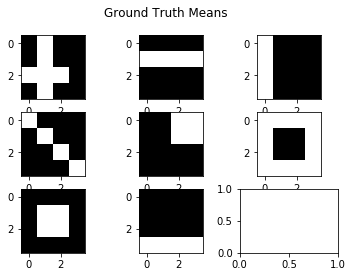

In [355]:
##################################
## Generate synthetic dataset 1 ##
##################################
N = 100
d1, d2 = 4, 4
D = d1*d2
K = 8
dictionary, X = generate_synthetic_data(N, K, d1, d2)
plot_grid(dictionary, d1, d2, title='Ground Truth Means')

In [356]:
#######################
## Model Hyperparams ##
#######################
K = 15
sigma_A = 0.1
sigma_n = 0.1
#alpha = 0.7
alphas = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]


#############################
## Optimization parameters ##
#############################
rounds = 500
#elbos = []
elbos = {alpha: [] for alpha in alphas}
lls = {alpha: [] for alpha in alphas}
phis = {}
nus = {}
starts = 5

######################
## Run Optimization ##
######################

for alpha in alphas:
    for i in range(starts):
        ibp_model = IBP(alpha, K, N, X, D, sigma_A, sigma_n)
        ibp_model.param_updates(rounds, debug=False)
        elbos[alpha].append(ibp_model.elbos)
        lls[alpha].append(ibp_model.predictive_lls)
    phis[alpha] = ibp_model.phi
    nus[alpha] = ibp_model.nu

Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 0
Iter: 100
Iter: 200
Iter: 300
It

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


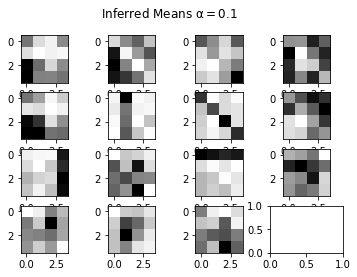

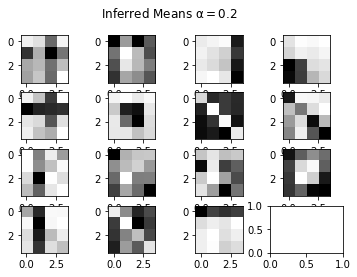

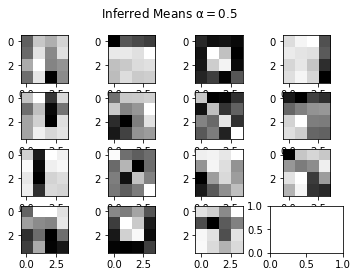

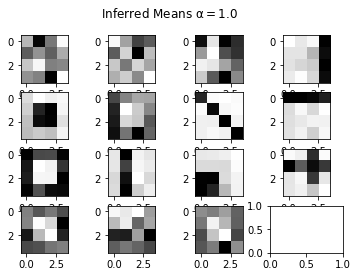

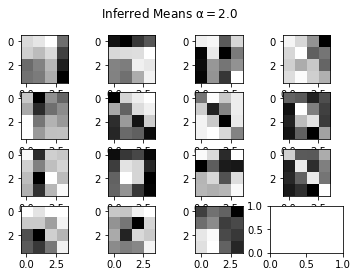

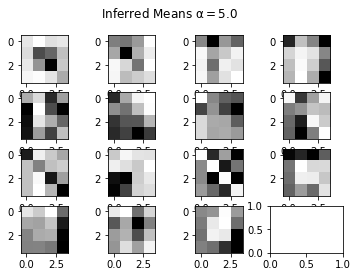

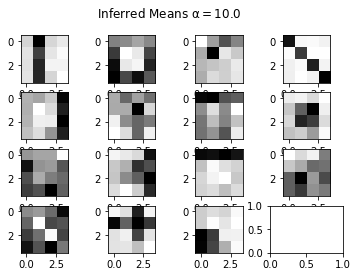

In [357]:
# The means of the Gaussian dictionary should contain the
# useful for the second synthetic example.
for alpha in alphas:
    plot_grid(phis[alpha], d1, d2, title='Inferred Means $\\alpha = {}$'.format(alpha), order='F')

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


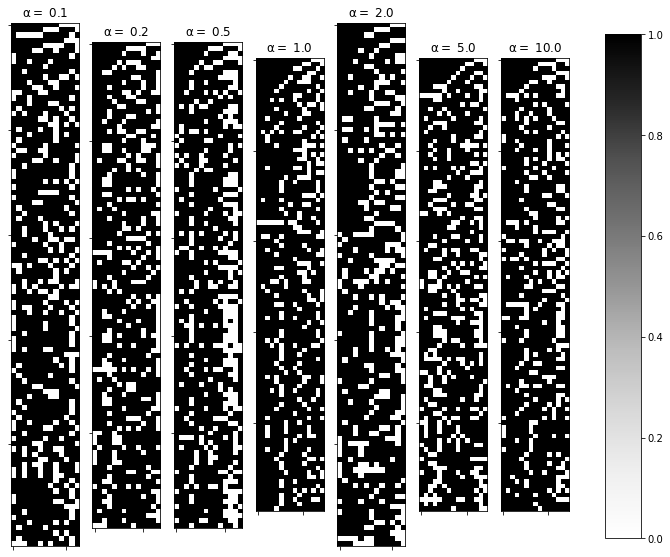

In [358]:
fig, ax = plt.subplots(1, len(alphas), figsize=(10, 10))
n = 0
for i in range(len(alphas)):
    alpha = alphas[i]
    imgplot = ax[i].imshow(lof(nus[alpha], probs=True), cmap=cm.Greys, vmin=0, vmax=1) # cmap=cm.Greys_r,
    #imgplot.set_interpolation('nearest')
    ax[i].set_title('$\\alpha = $ {}'.format(alpha))
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    #ax[i].set_aspect('equal')
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(imgplot, cax=cbar_ax)
fig.show()

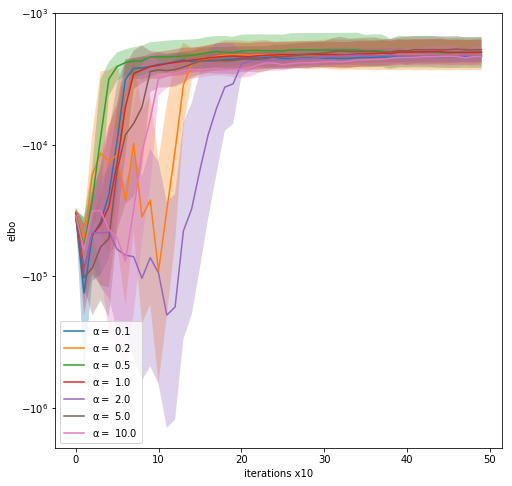

In [359]:
def transform(theta):
    return np.log(-theta)

def delta_method(se, theta):
    return se / theta

def back_transform(phi):
    return -np.exp(phi)

means = {}
stds = {}
stds_trans_upper = {}
stds_trans_lower = {}
for alpha in alphas:
    thetas = [np.mean(a) for a in zip(*elbos[alpha])]
    stds_theta = [np.std(a) for a in zip(*elbos[alpha])]
    means[alpha] = thetas
    stds[alpha] = stds_theta
    stds_phi = [delta_method(se, theta) for se, theta in zip(stds_theta, thetas)]
    phi_upper = [transform(ll) + ll_sd_phi for ll, ll_sd_phi in zip(thetas, stds_phi)]
    phi_lower = [transform(ll) - ll_sd_phi for ll, ll_sd_phi in zip(thetas, stds_phi)]
    theta_trains_upper = [back_transform(phi) for phi in phi_upper]
    theta_trans_lower = [back_transform(phi) for phi in phi_lower]
    stds_trans_upper[alpha] = theta_trains_upper
    stds_trans_lower[alpha] = theta_trans_lower
    
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for alpha in alphas:
    ax.plot(means[alpha], label='$\\alpha = $ {}'.format(alpha))
    ax.fill_between(list(range(len(means[alpha]))),
                   stds_trans_upper[alpha],
                   stds_trans_lower[alpha], alpha=0.3)
ax.set_yscale('symlog')
plt.xlabel("iterations x10")
plt.ylabel("elbo")
plt.legend()
plt.show()

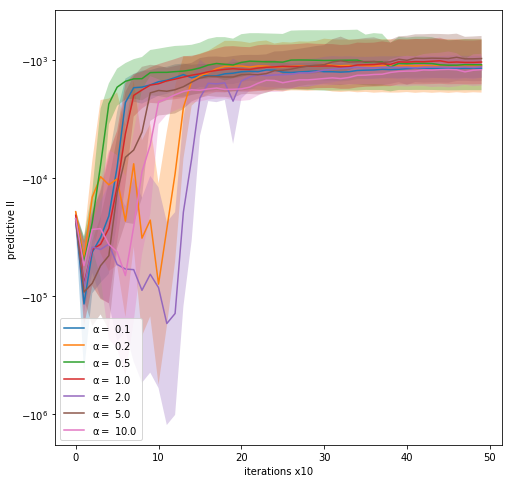

In [360]:
means = {}
stds = {}
stds_trans_upper = {}
stds_trans_lower = {}
for alpha in alphas:
    thetas = [np.mean(a) for a in zip(*lls[alpha])]
    stds_theta = [np.std(a) for a in zip(*lls[alpha])]
    means[alpha] = thetas
    stds[alpha] = stds_theta
    stds_phi = [delta_method(se, theta) for se, theta in zip(stds_theta, thetas)]
    phi_upper = [transform(ll) + ll_sd_phi for ll, ll_sd_phi in zip(thetas, stds_phi)]
    phi_lower = [transform(ll) - ll_sd_phi for ll, ll_sd_phi in zip(thetas, stds_phi)]
    theta_trains_upper = [back_transform(phi) for phi in phi_upper]
    theta_trans_lower = [back_transform(phi) for phi in phi_lower]
    stds_trans_upper[alpha] = theta_trains_upper
    stds_trans_lower[alpha] = theta_trans_lower
    
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for alpha in alphas:
    ax.plot(means[alpha], label='$\\alpha = $ {}'.format(alpha))
    ax.fill_between(list(range(len(means[alpha]))),
                   stds_trans_upper[alpha],
                   stds_trans_lower[alpha], alpha=0.3)
    
ax.set_yscale('symlog')
plt.xlabel("iterations x10")
plt.ylabel("predictive ll ")
plt.legend()
plt.show()

# Matrix Fact Dataset

In [361]:
def generate_synthetic_data2(N, K, D, alpha = 10.0, sigma_A = 0.5, sigma_n = 0.1):
    """Generates data from known dist.
    """
    pi = np.random.beta(alpha/K, 1, size=K) # \in K
    Z = np.zeros((N, K))
    for n in range(N):
        Z[n, :] = np.random.binomial(1, pi, size=K)
    A = np.random.normal(0.0, sigma_A**2, size=(K, D))
    X = np.random.normal(np.dot(Z, A), sigma_n**2)
    return A, X, Z

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


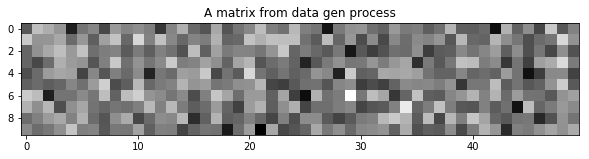

In [362]:
##################################
## Generate synthetic dataset 1 ##
##################################
N = 100
K = 10
D = 50
alpha = 10.0
sigma_A = 0.5
sigma_n = 0.1
dictionary, X, Z = generate_synthetic_data2(N, K, D)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
imgplot = ax.imshow(dictionary, cmap=cm.Greys_r) #, vmin=0, vmax=2)
imgplot.set_interpolation('nearest')
ax.set_title("A matrix from data gen process")
fig.show()

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


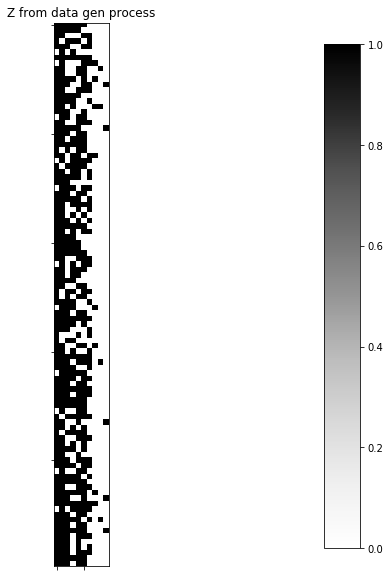

In [363]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
imgplot = ax.imshow(lof(Z, probs=False)[:100,:], cmap=cm.Greys, vmin=0, vmax=1)
ax.set_title('Z from data gen process')
ax.set_xticklabels([])
ax.set_yticklabels([])
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(imgplot, cax=cbar_ax)
fig.show()

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


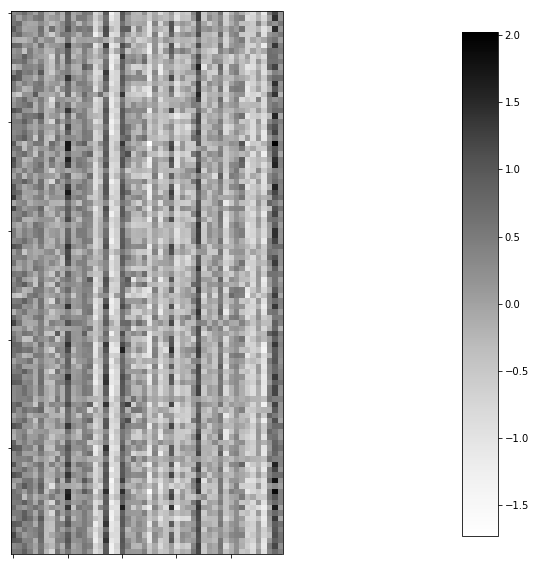

In [364]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
imgplot = ax.imshow(X, cmap=cm.Greys)#, vmin=0, vmax=1)
#ax.set_title('Z from data gen process')
ax.set_xticklabels([])
ax.set_yticklabels([])
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(imgplot, cax=cbar_ax)
fig.show()

Iter: 0


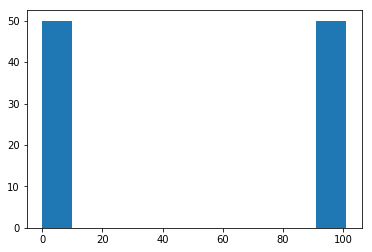

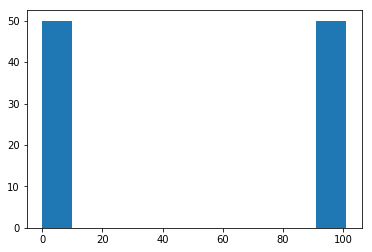

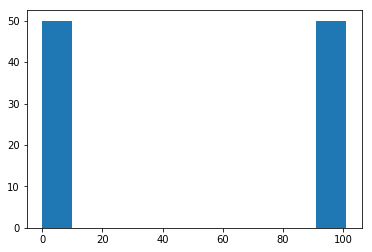

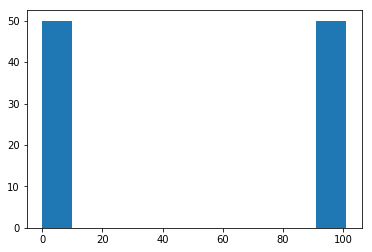

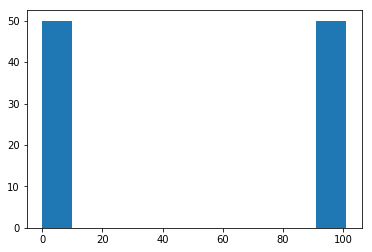

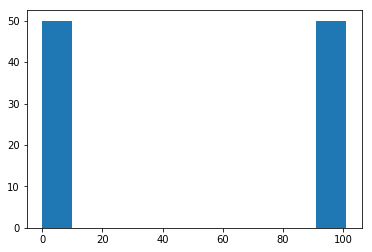

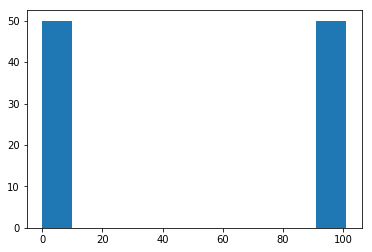

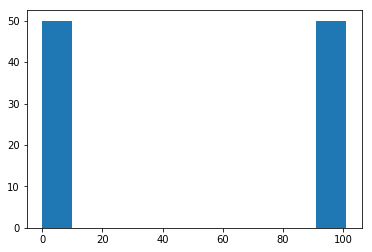

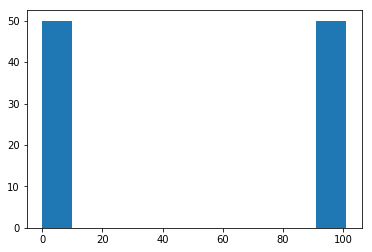

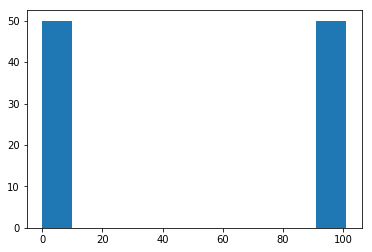

Iter: 100


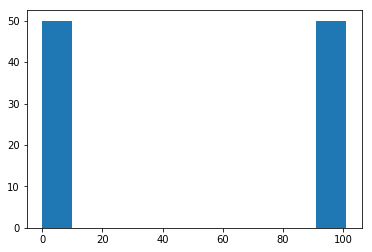

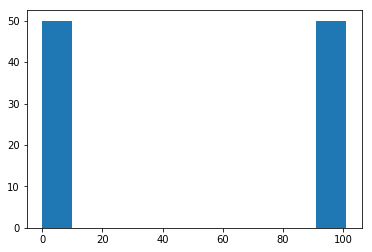

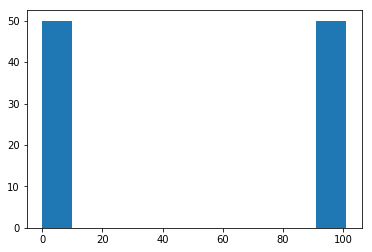

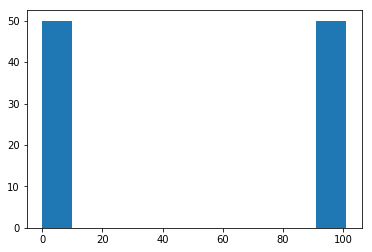

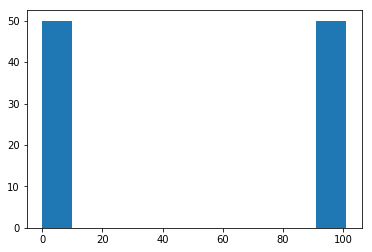

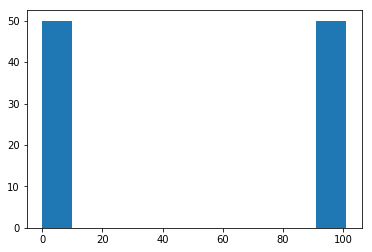

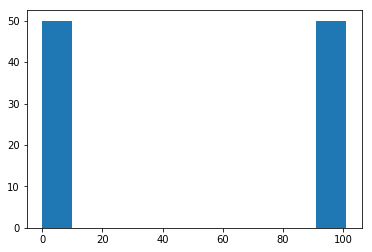

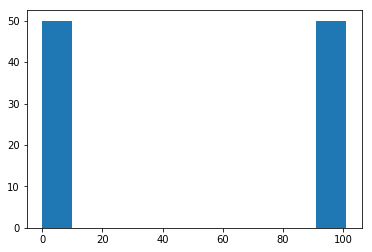

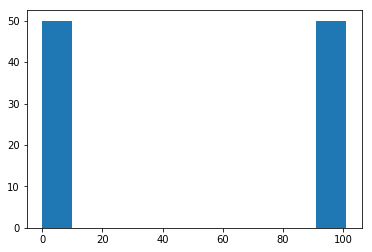

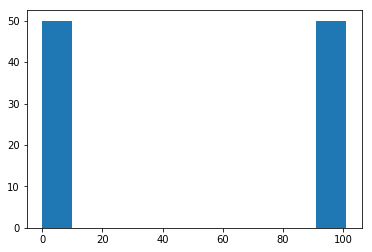

Iter: 200


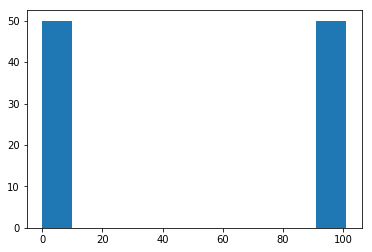

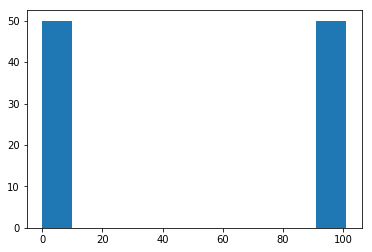

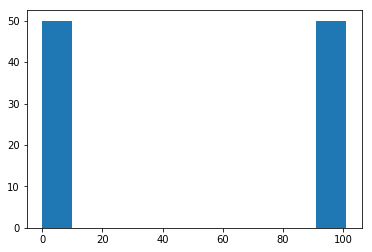

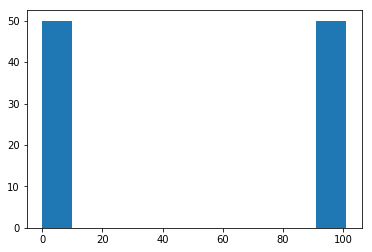

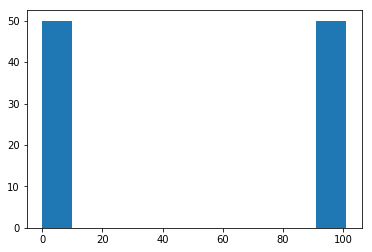

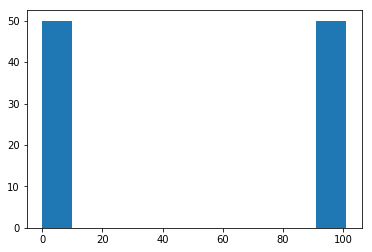

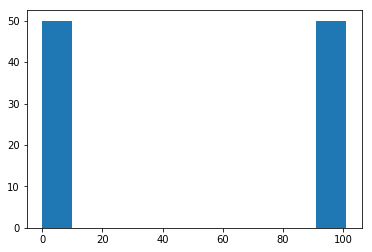

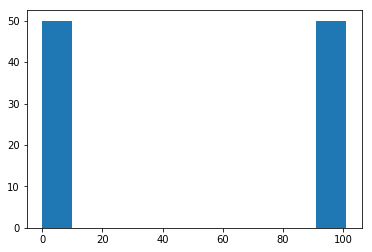

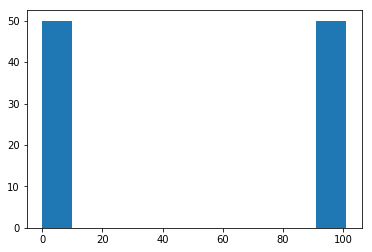

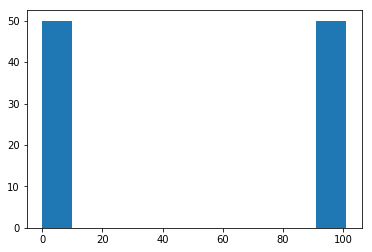

Iter: 300


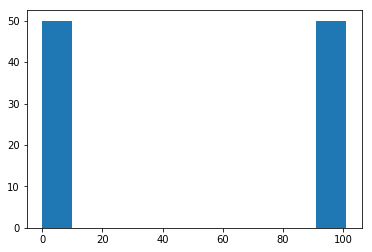

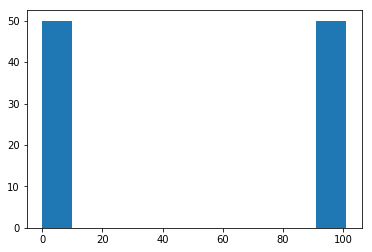

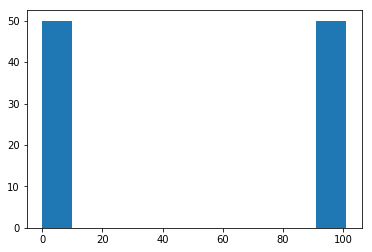

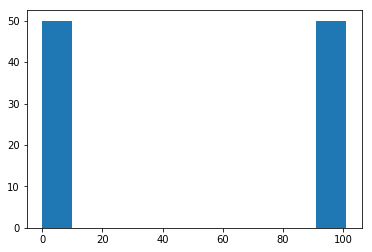

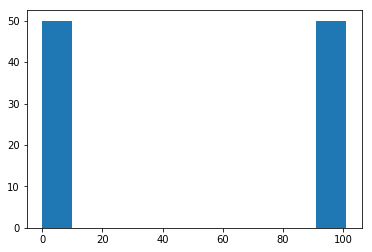

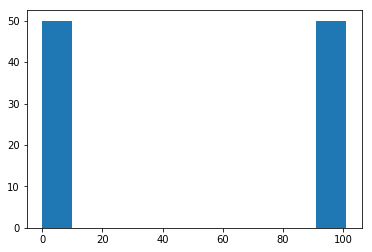

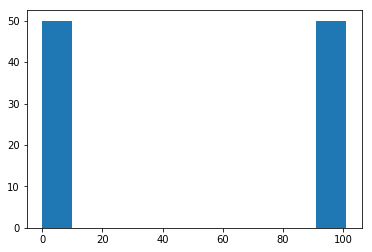

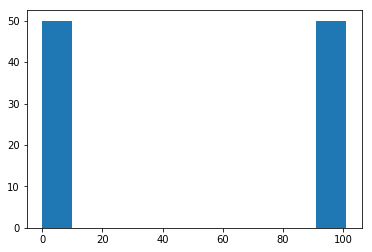

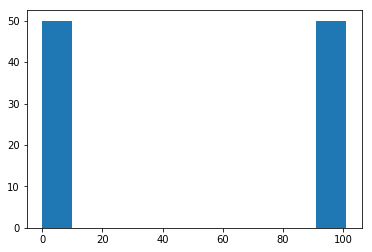

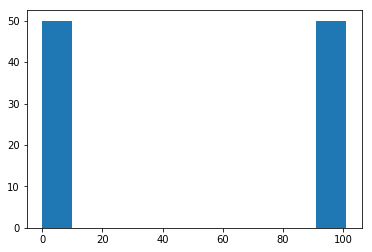

Iter: 400


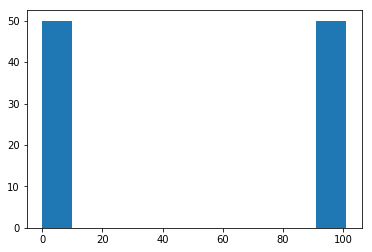

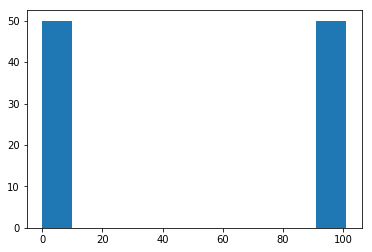

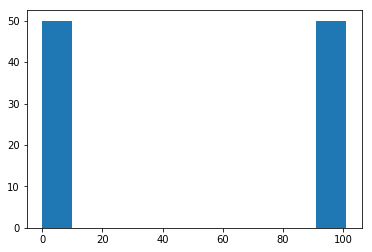

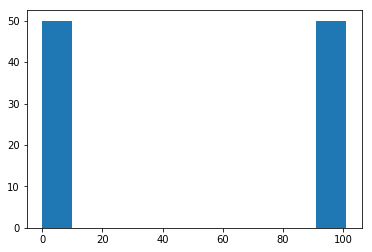

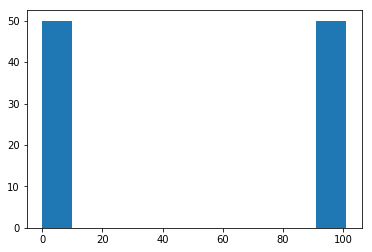

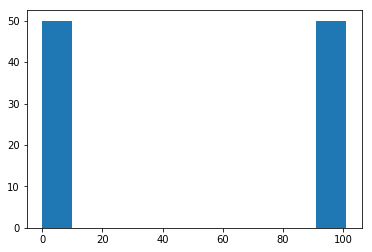

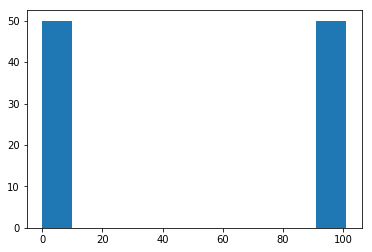

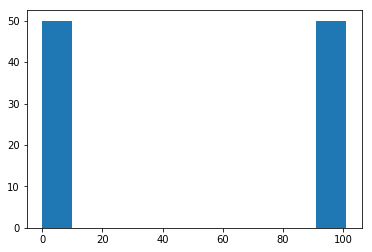

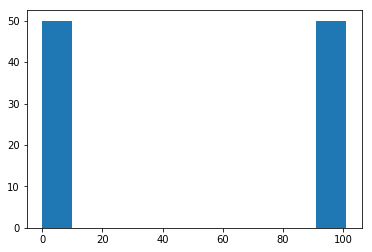

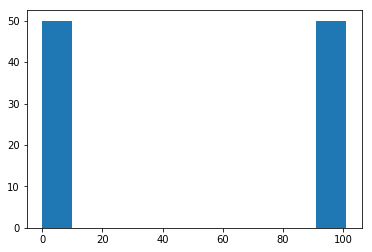

Iter: 500


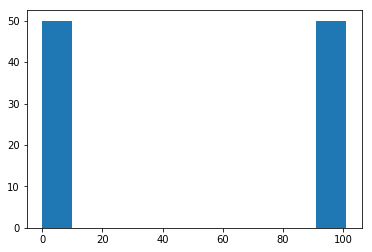

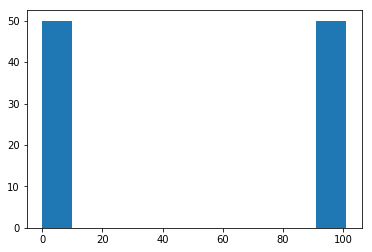

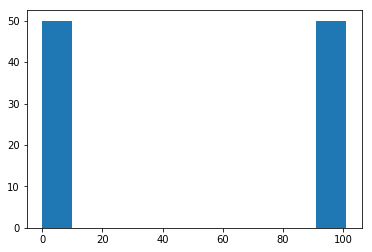

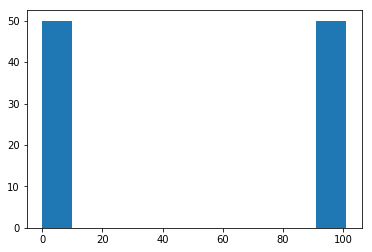

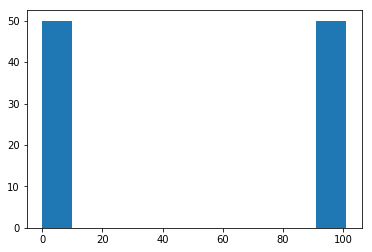

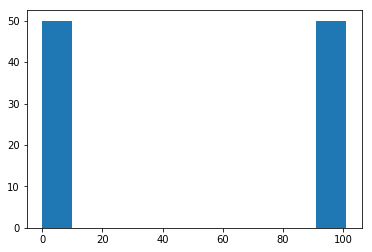

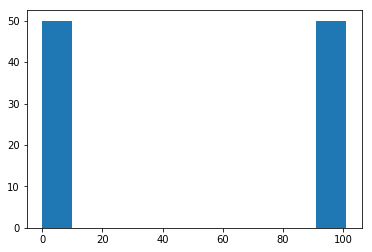

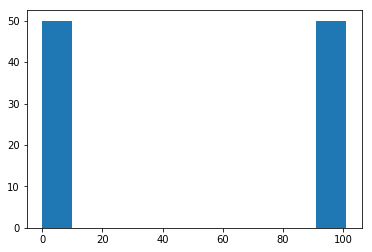

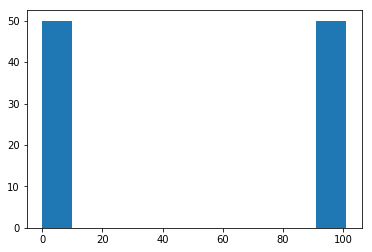

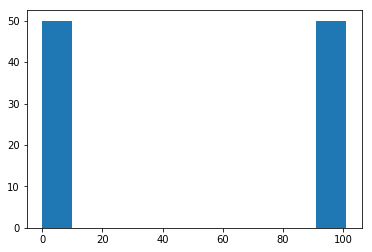

Iter: 600


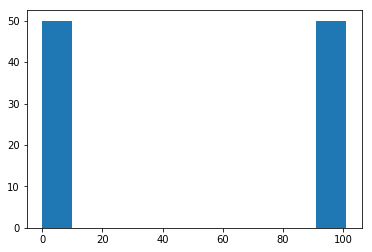

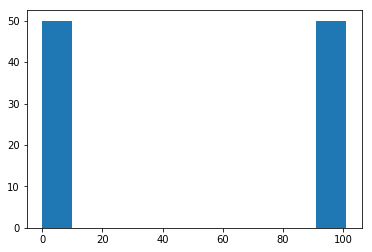

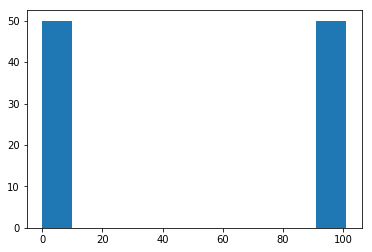

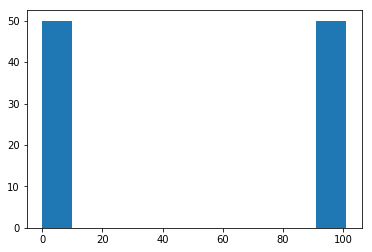

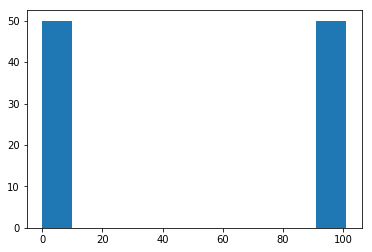

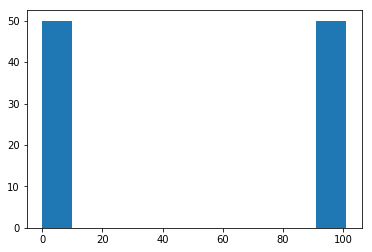

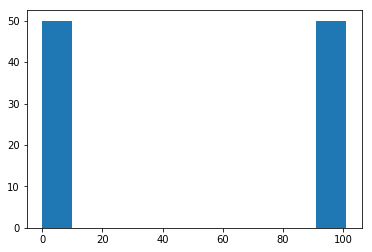

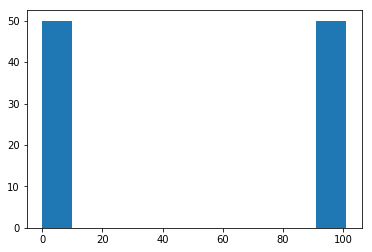

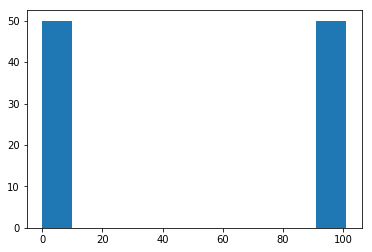

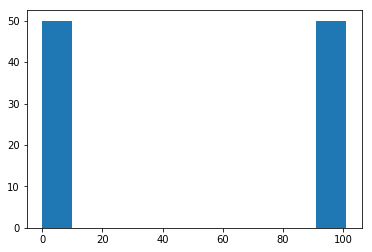

Iter: 700


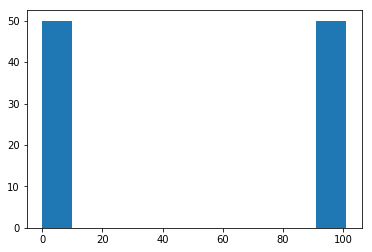

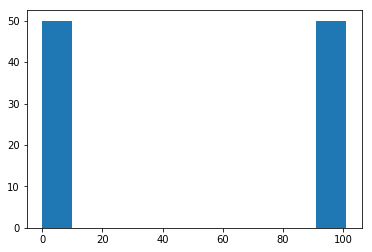

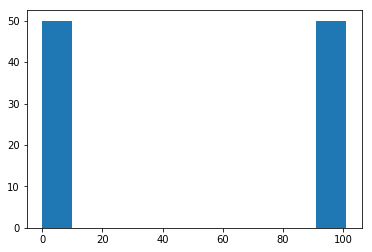

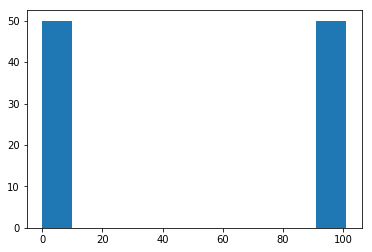

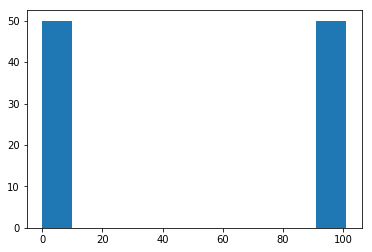

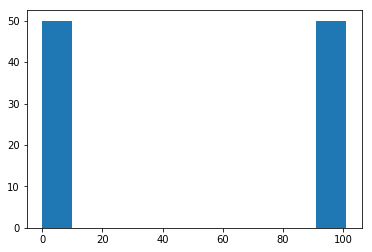

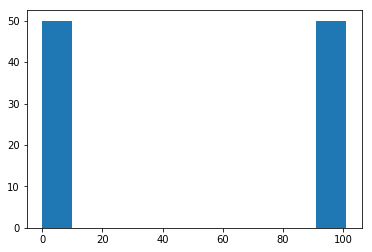

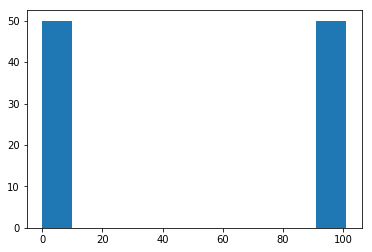

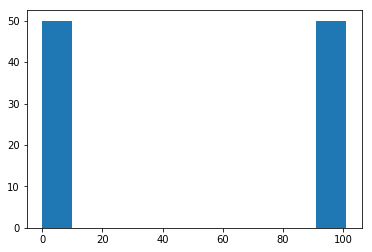

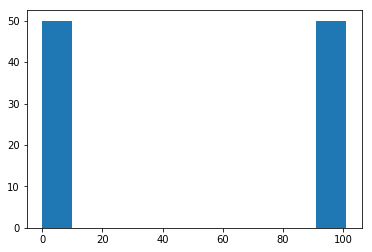

Iter: 800


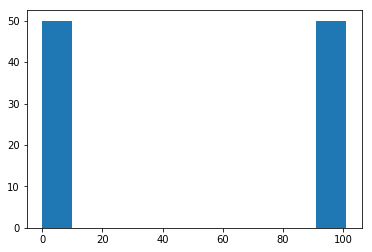

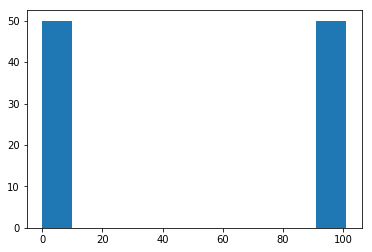

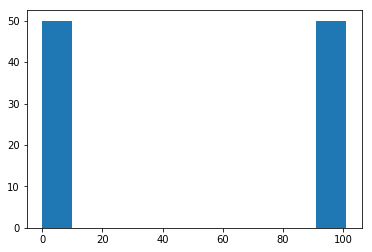

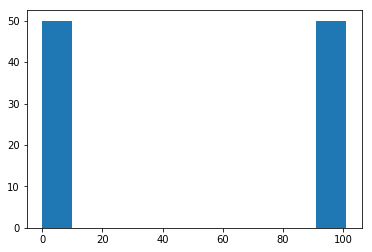

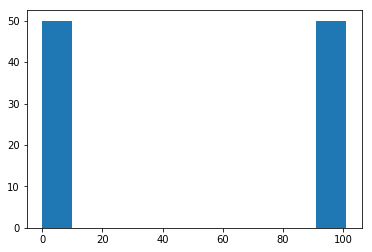

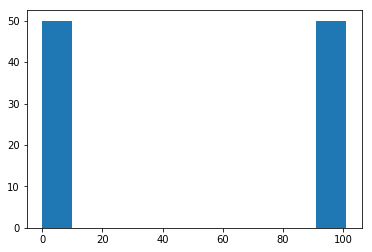

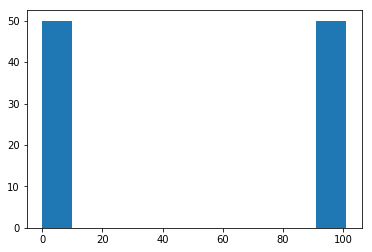

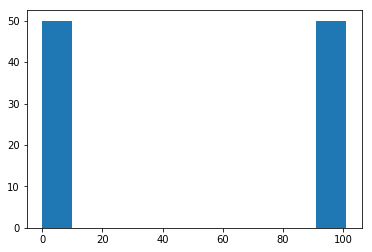

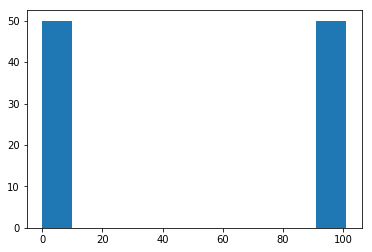

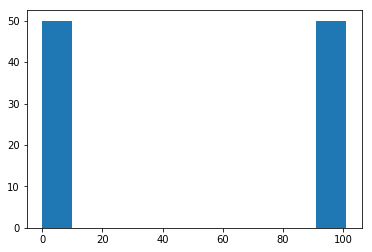

Iter: 900


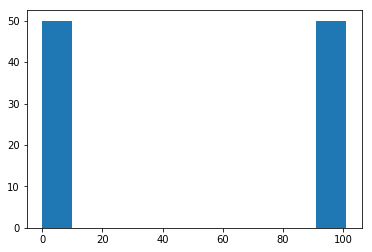

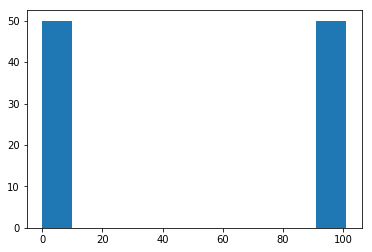

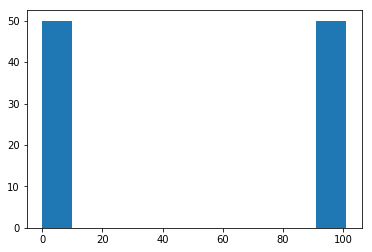

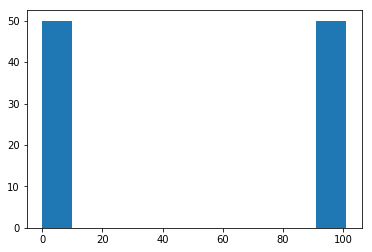

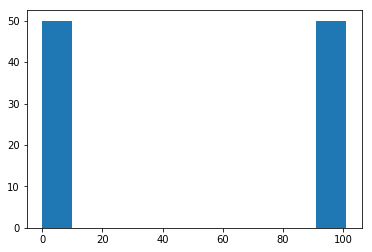

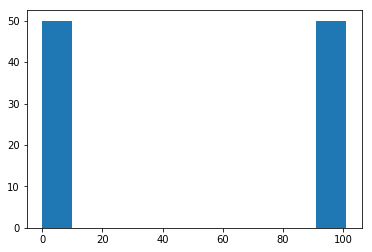

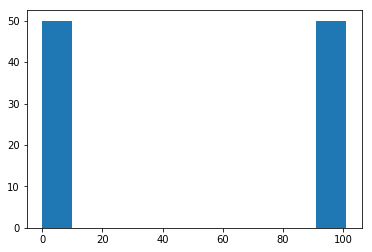

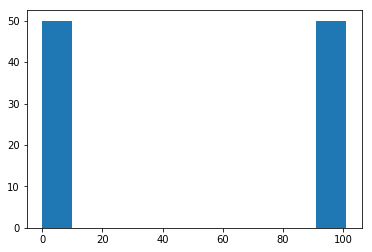

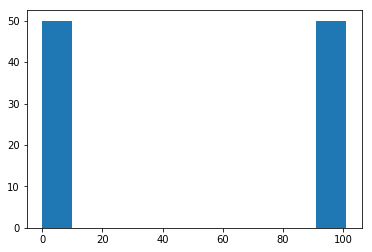

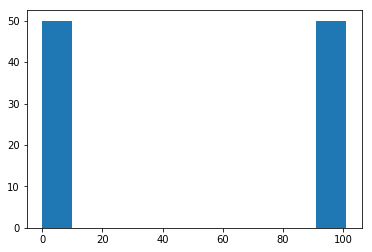

Iter: 0


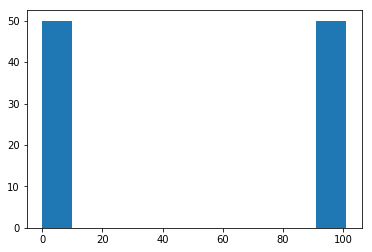

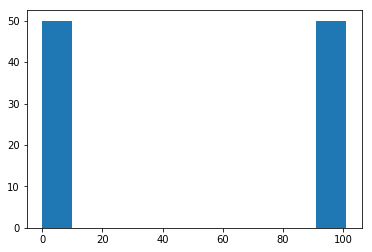

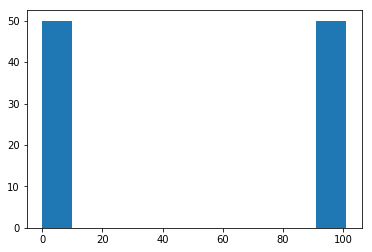

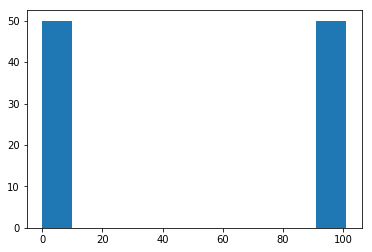

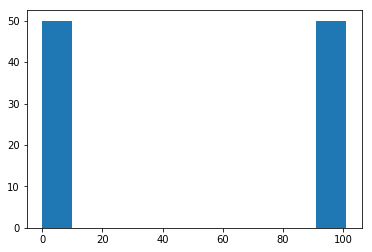

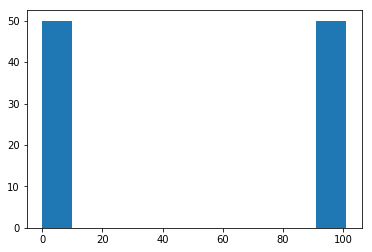

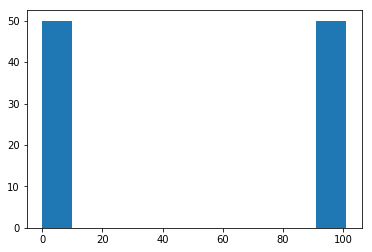

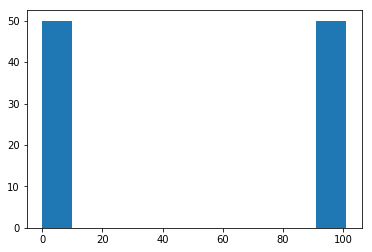

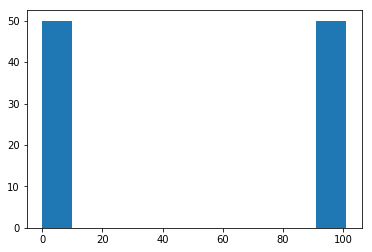

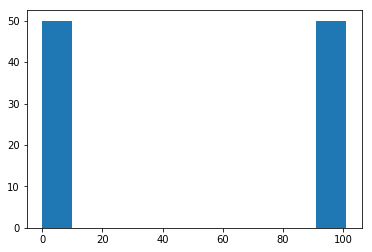

Iter: 100


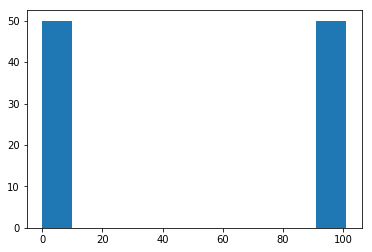

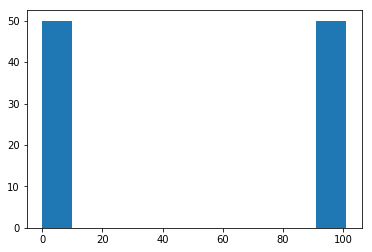

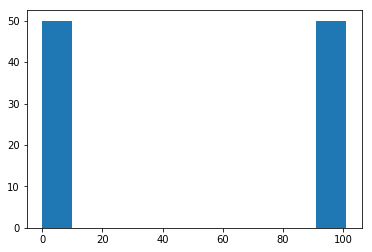

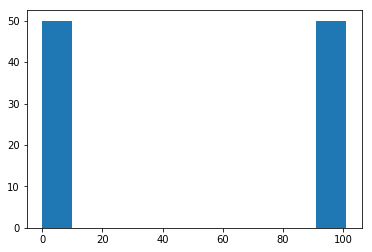

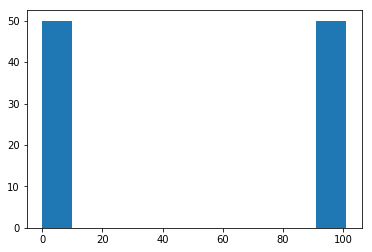

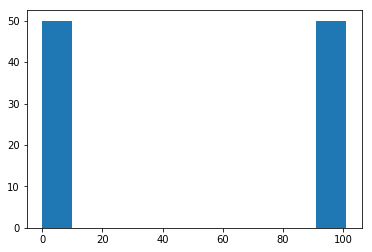

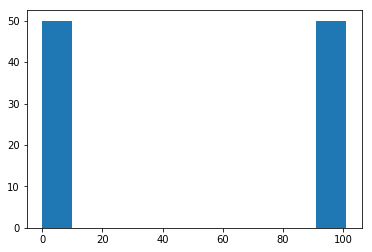

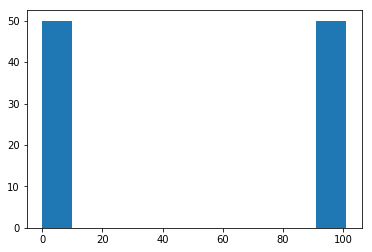

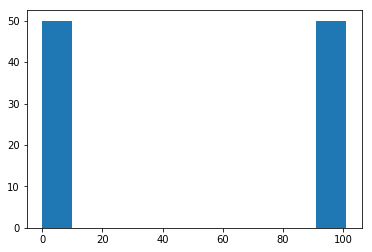

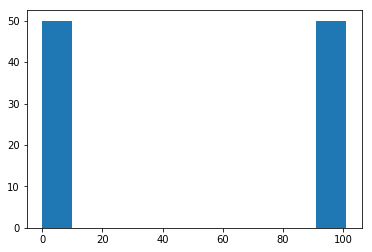

Iter: 200


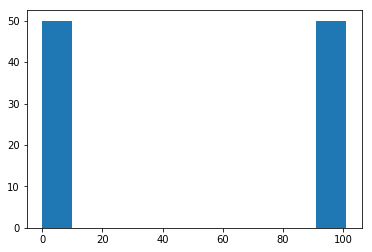

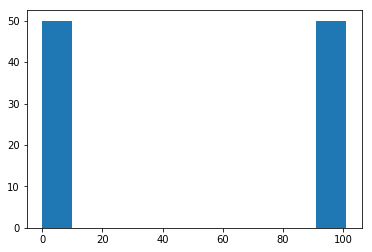

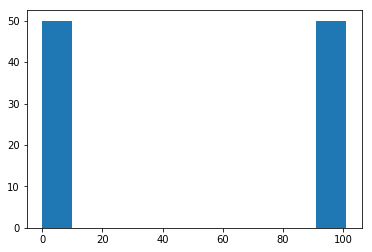

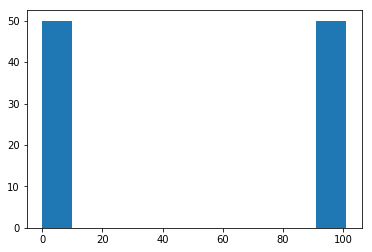

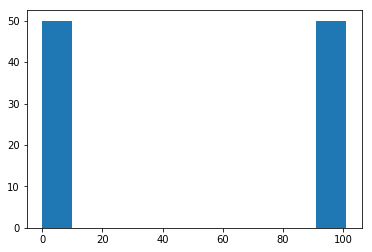

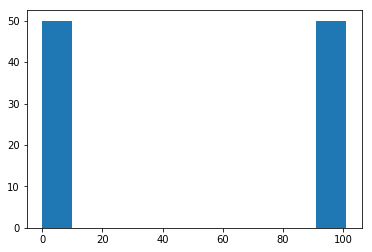

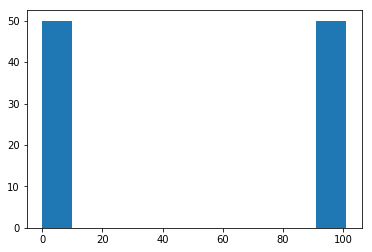

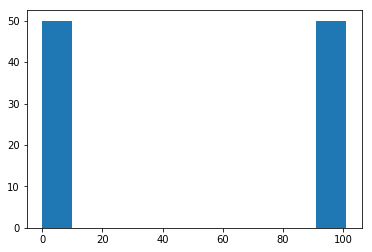

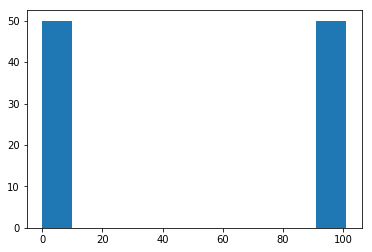

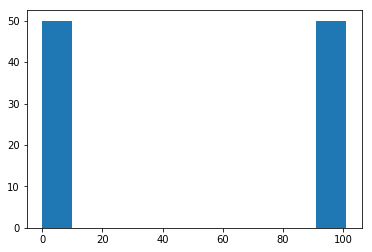

Iter: 300


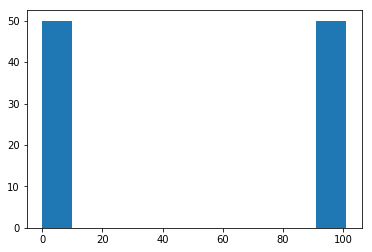

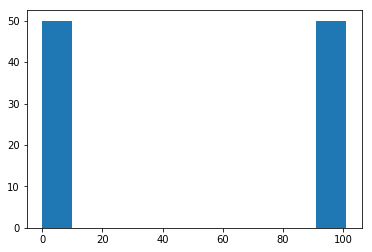

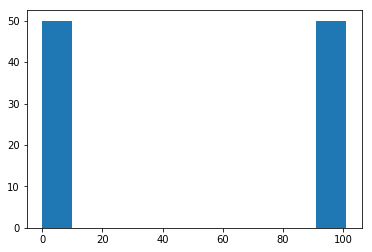

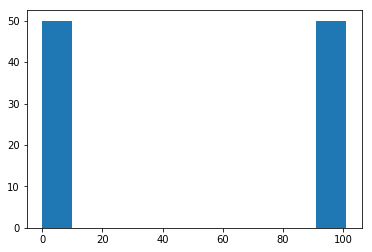

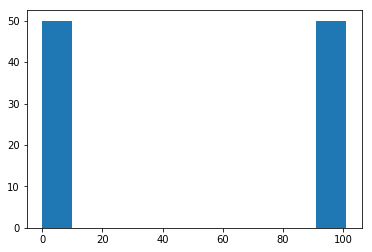

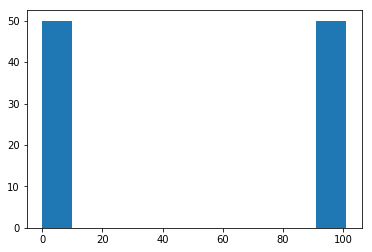

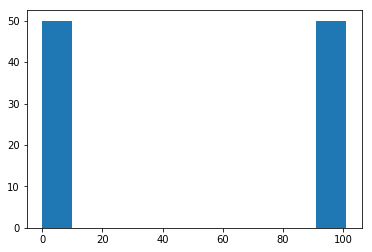

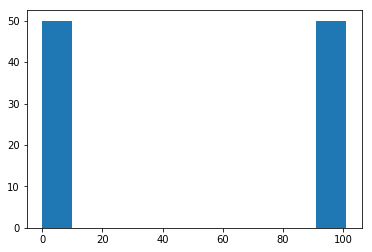

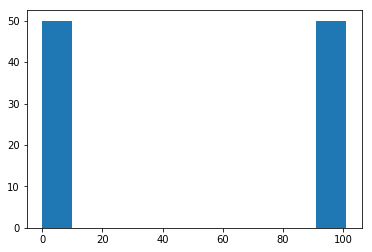

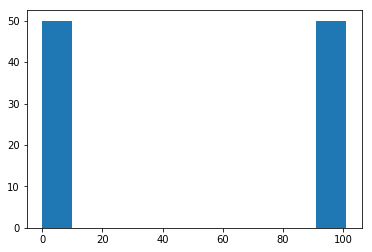

Iter: 400


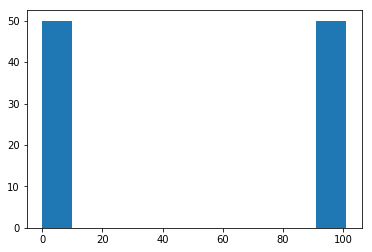

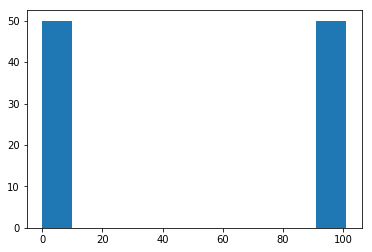

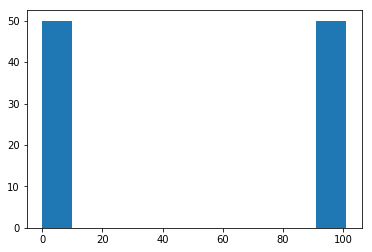

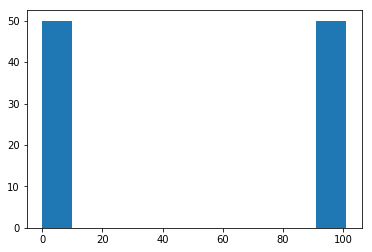

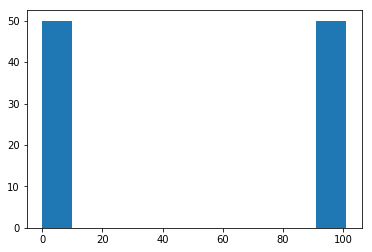

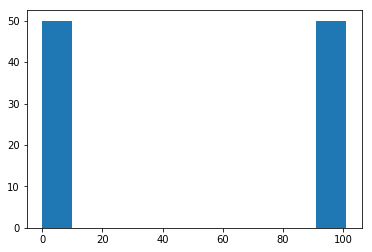

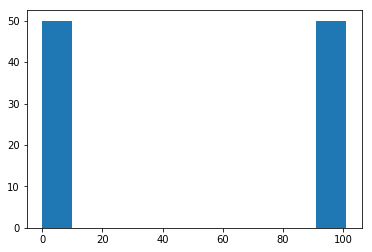

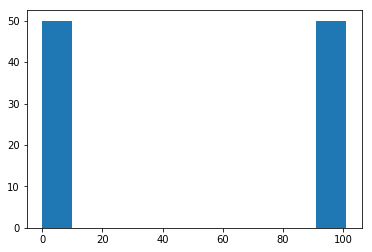

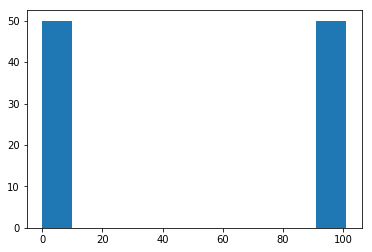

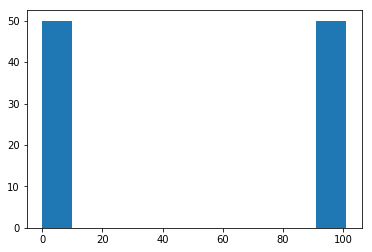

Iter: 500


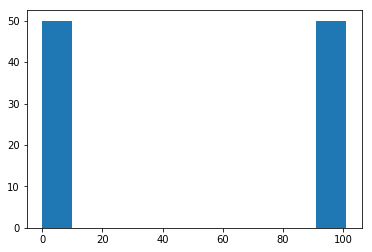

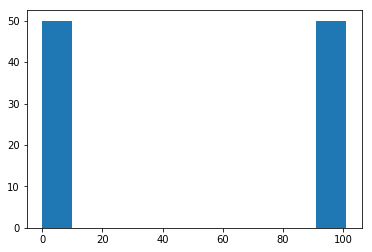

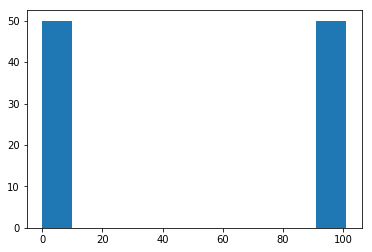

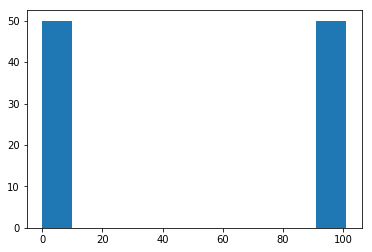

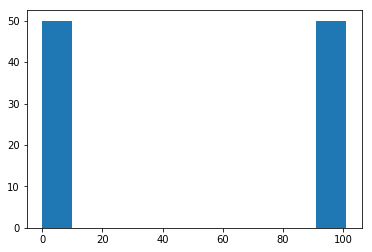

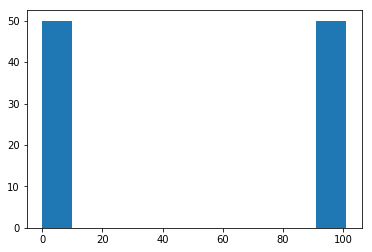

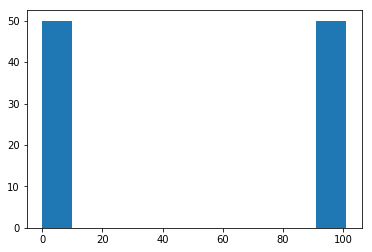

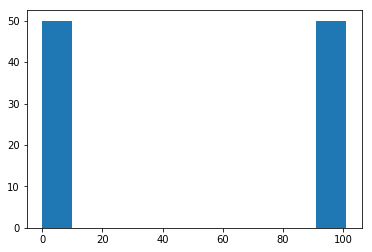

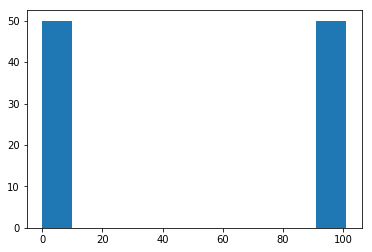

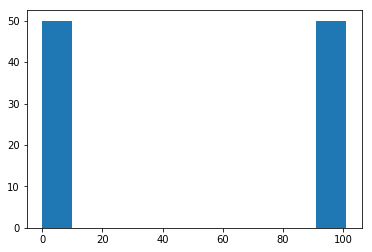

Iter: 600


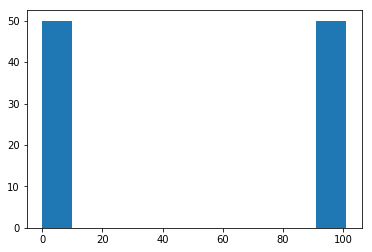

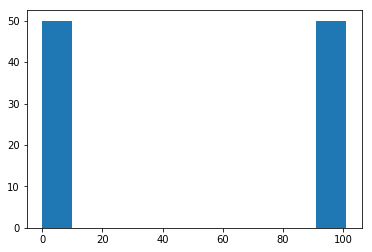

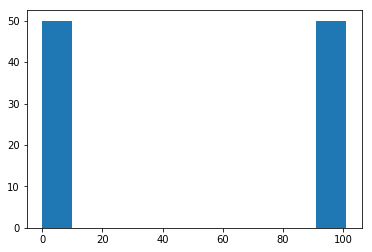

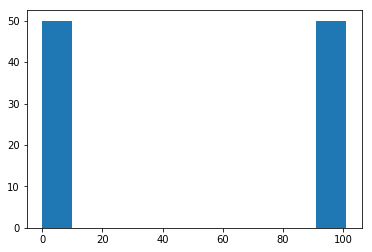

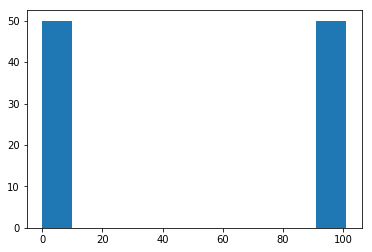

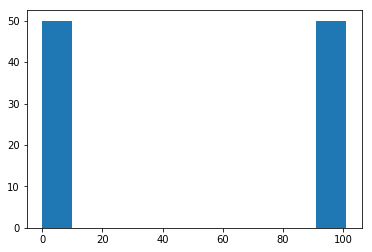

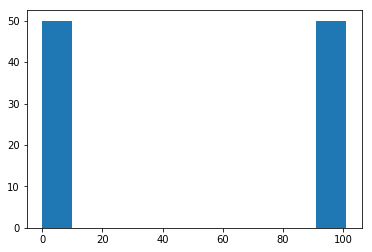

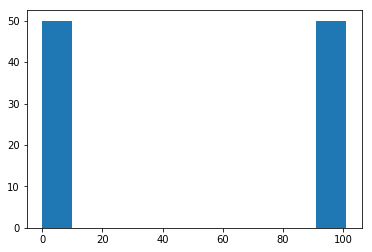

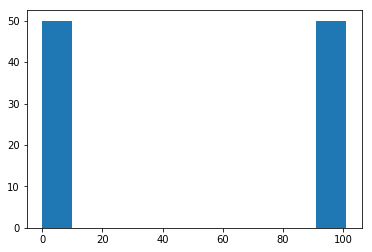

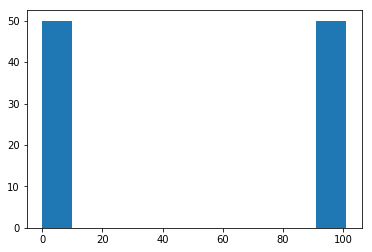

Iter: 700


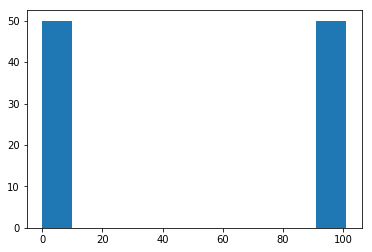

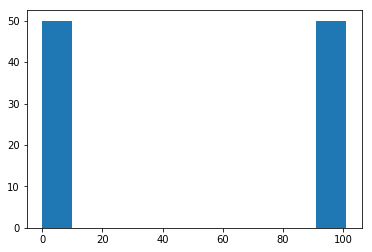

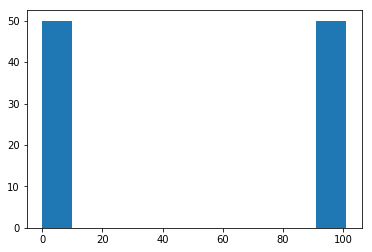

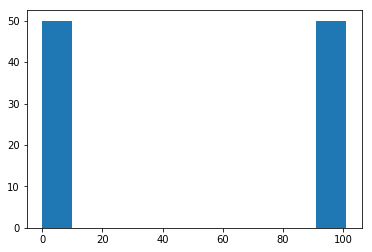

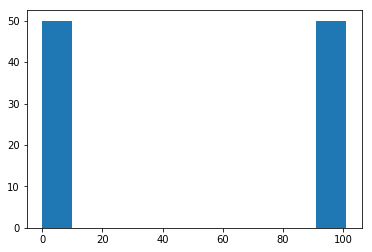

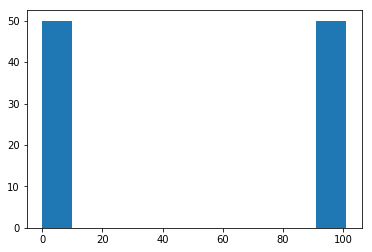

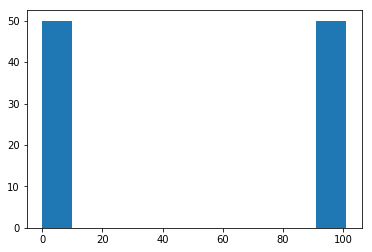

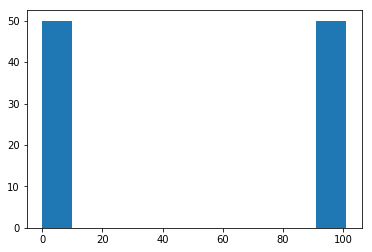

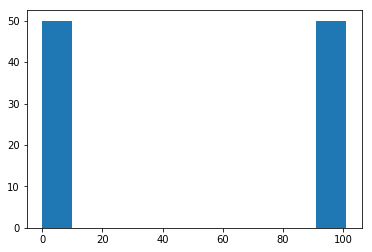

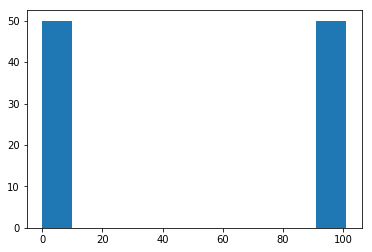

Iter: 800


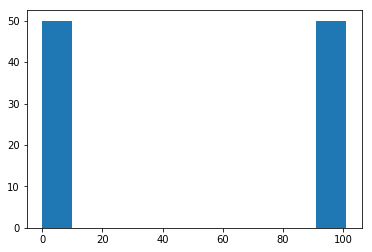

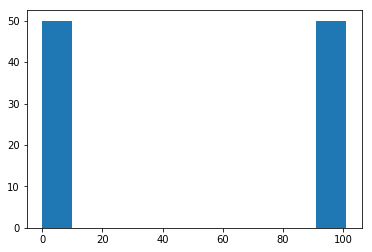

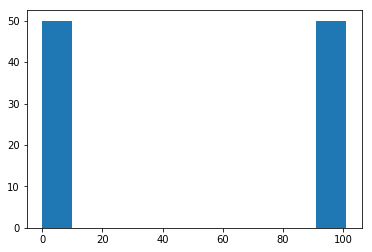

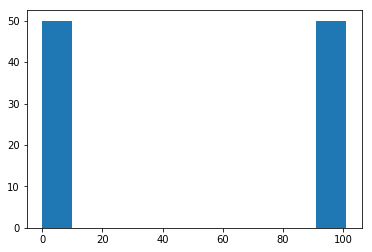

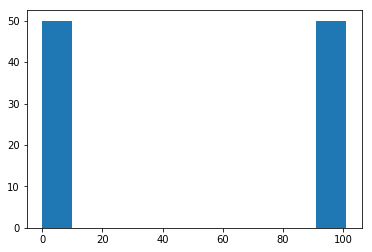

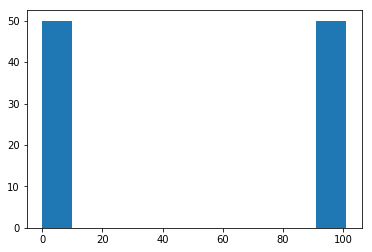

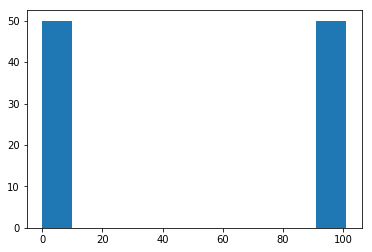

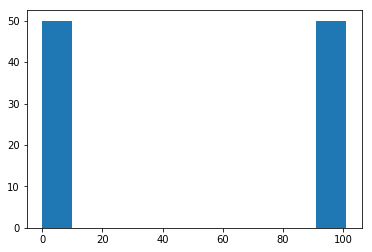

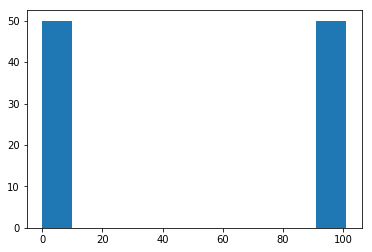

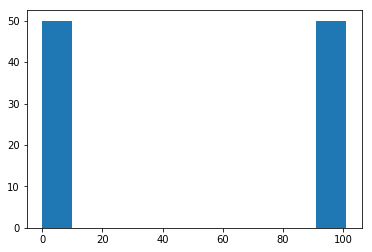

Iter: 900


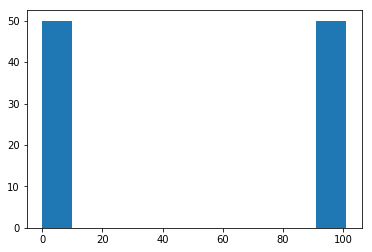

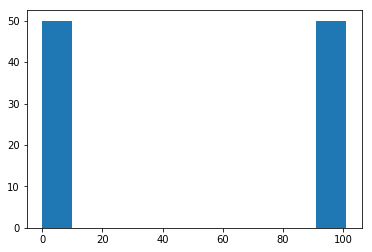

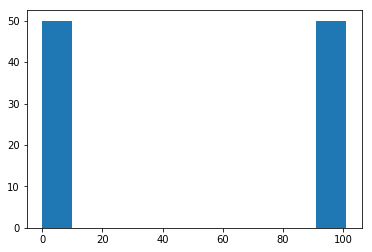

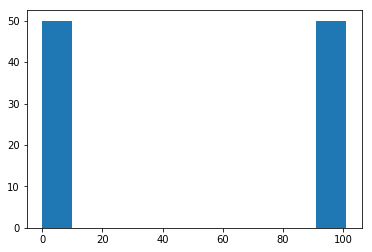

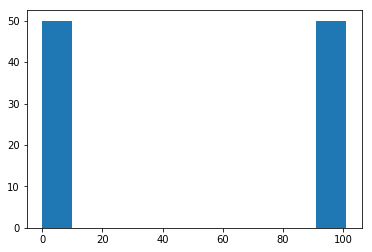

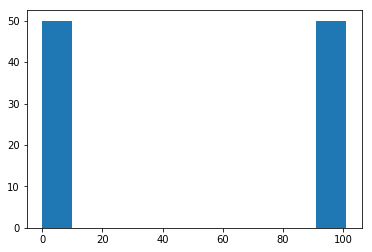

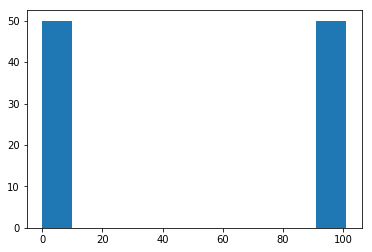

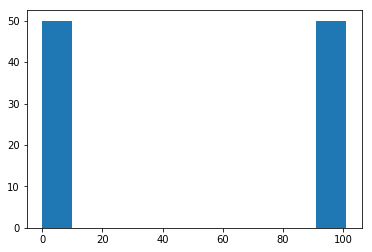

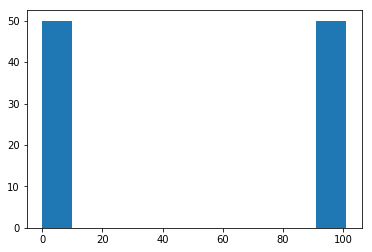

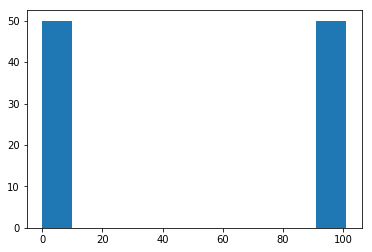

Iter: 0


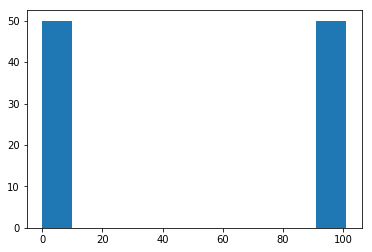

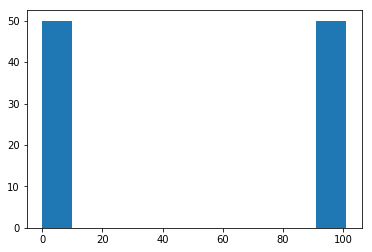

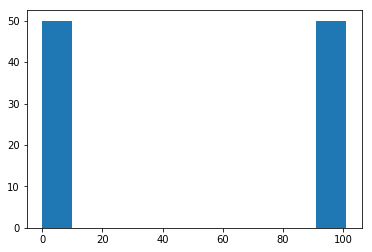

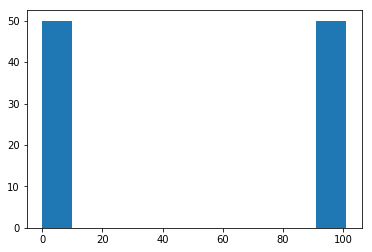

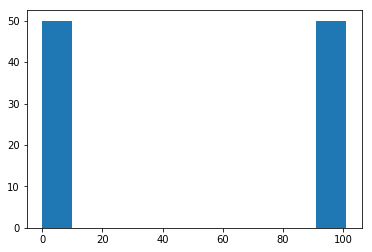

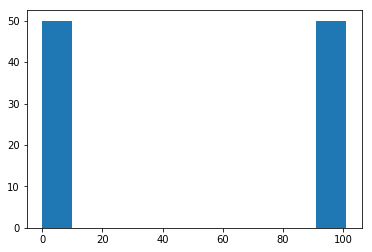

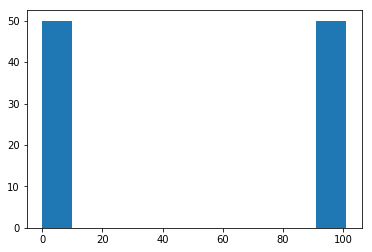

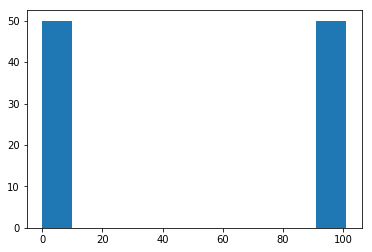

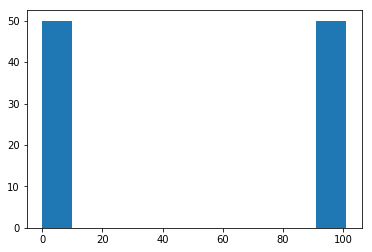

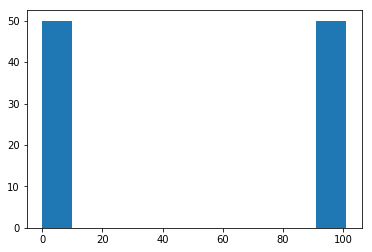

Iter: 100


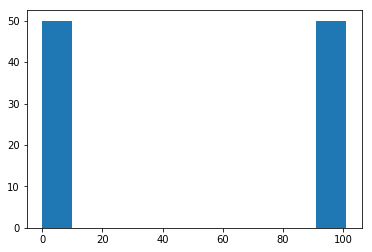

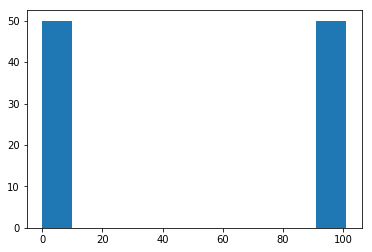

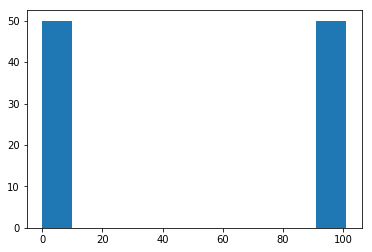

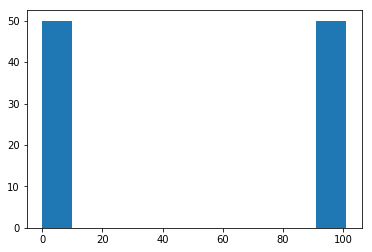

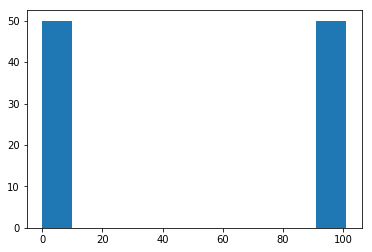

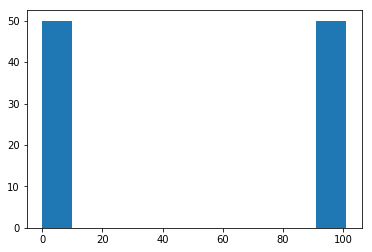

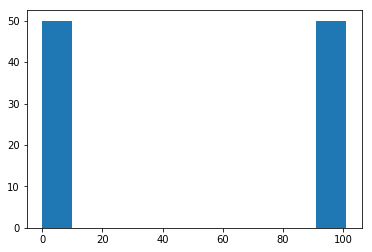

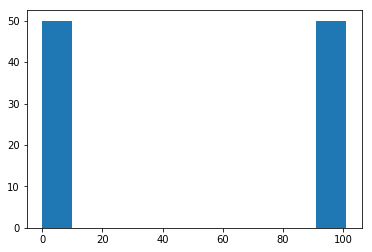

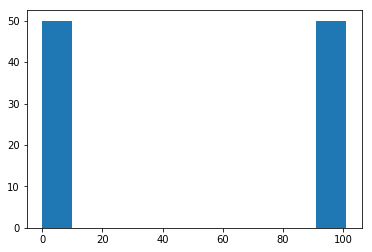

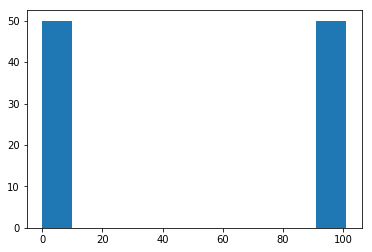

Iter: 200


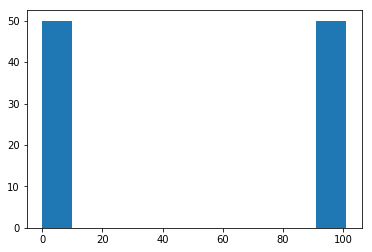

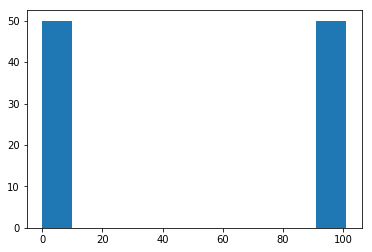

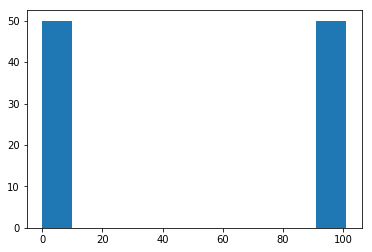

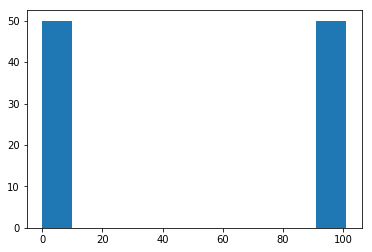

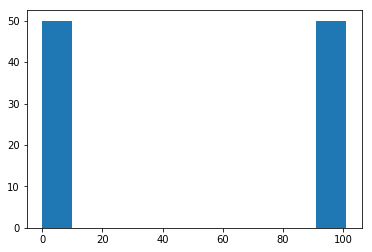

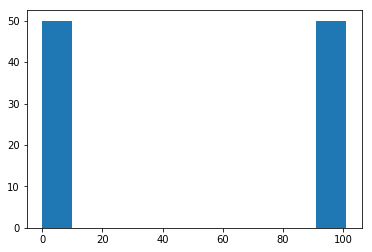

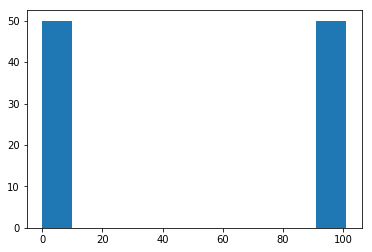

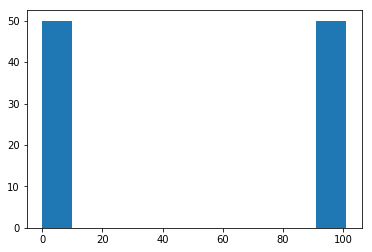

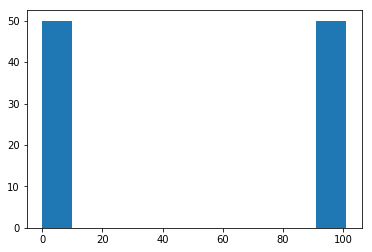

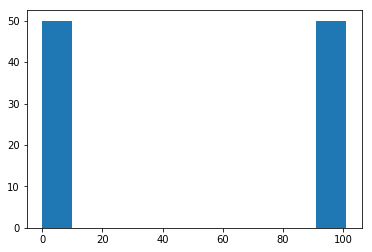

Iter: 300


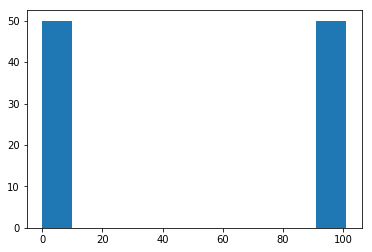

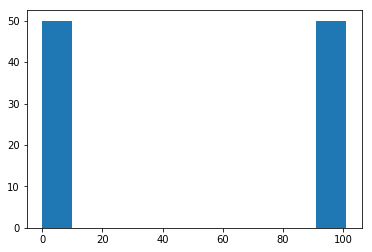

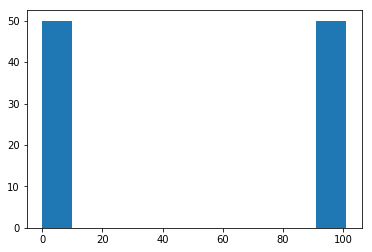

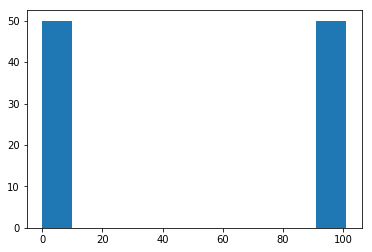

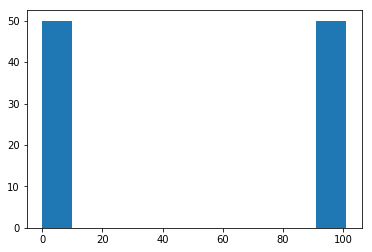

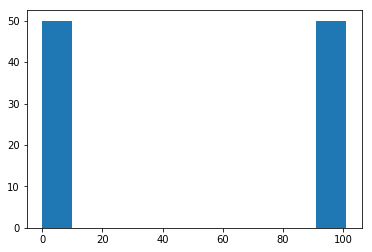

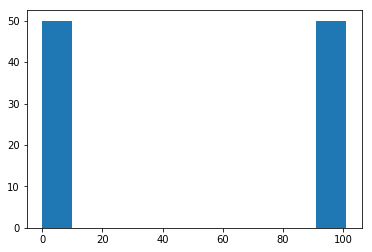

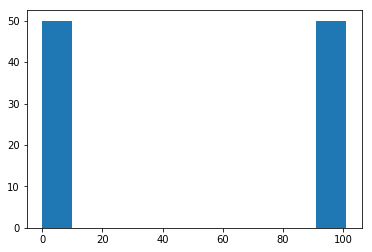

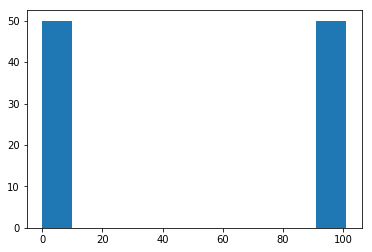

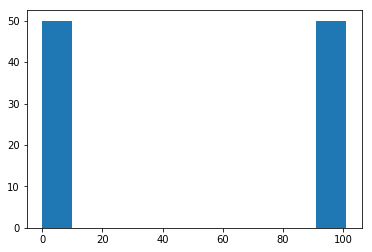

Iter: 400


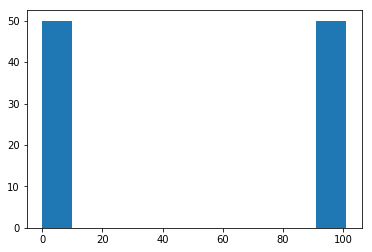

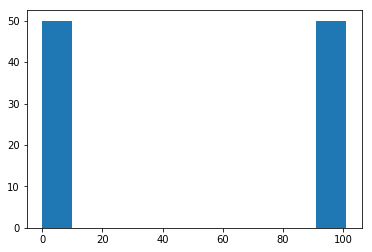

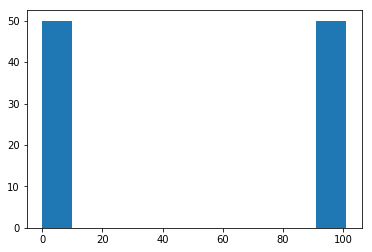

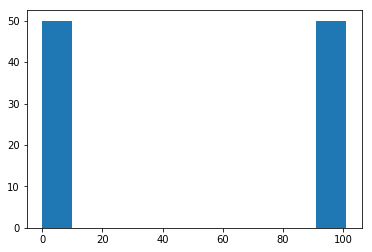

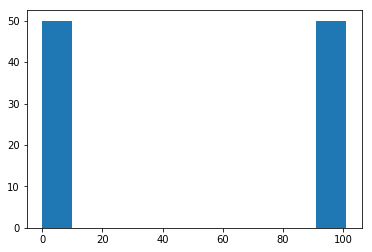

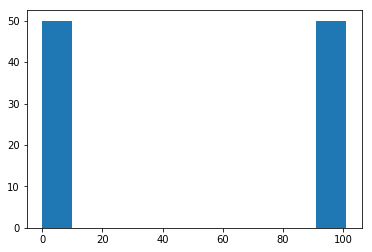

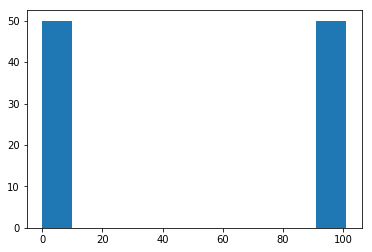

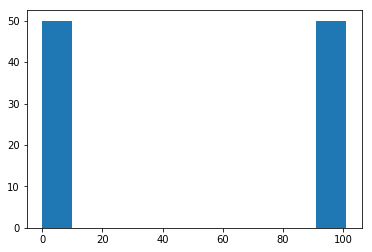

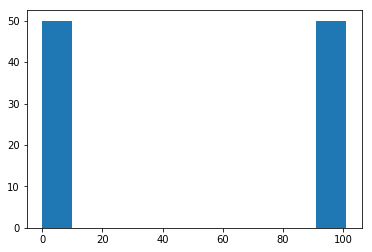

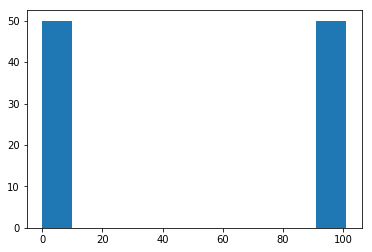

Iter: 500


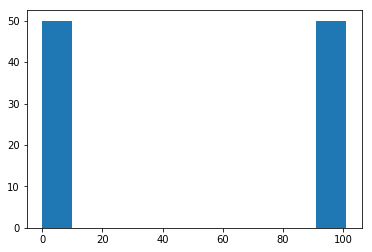

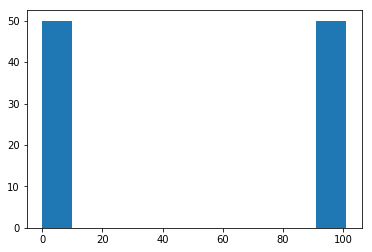

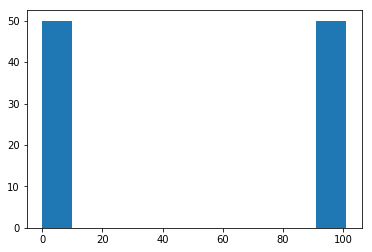

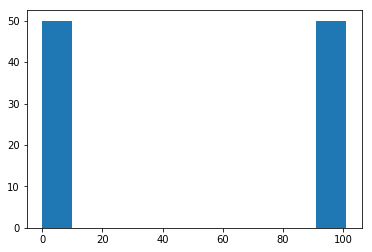

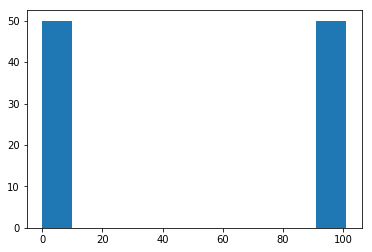

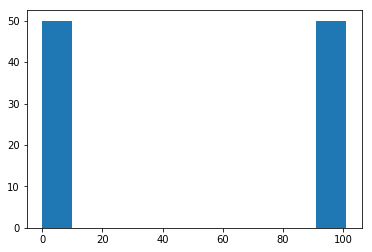

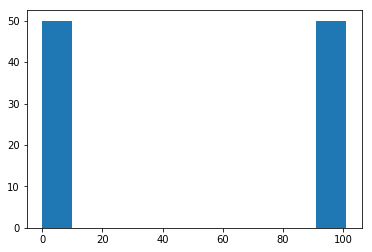

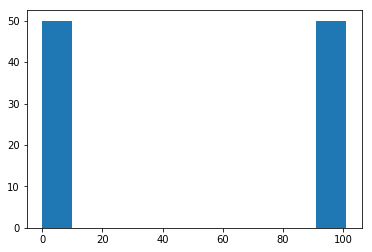

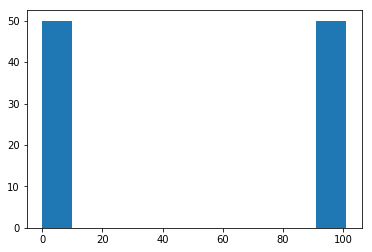

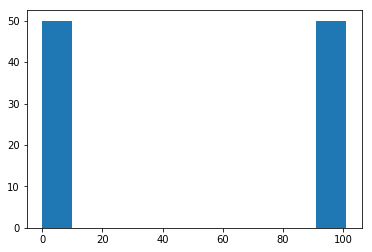

Iter: 600


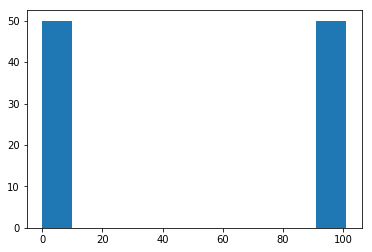

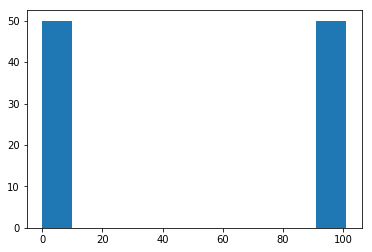

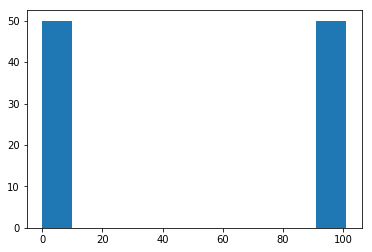

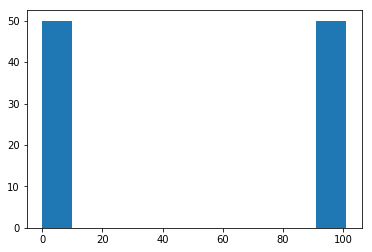

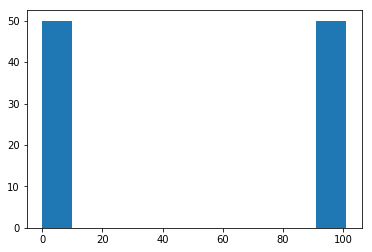

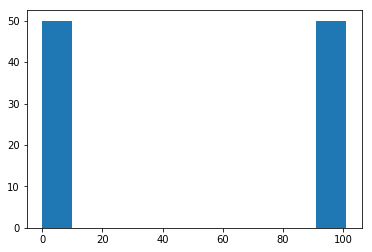

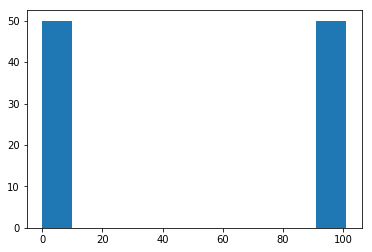

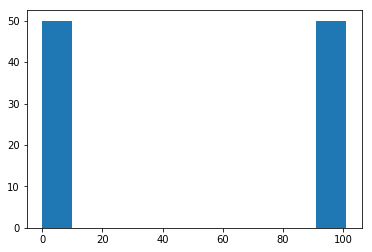

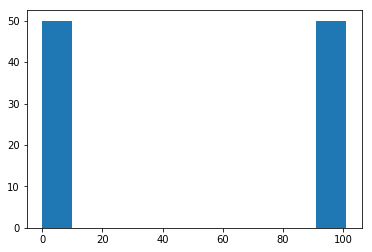

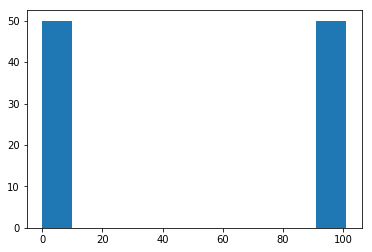

Iter: 700


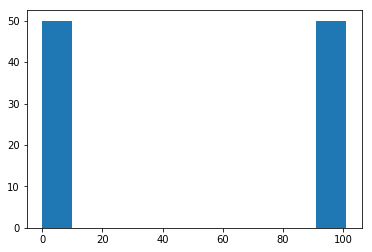

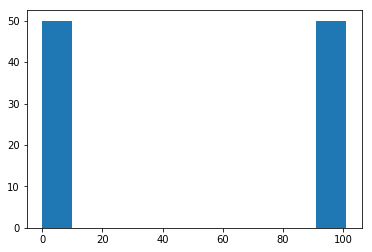

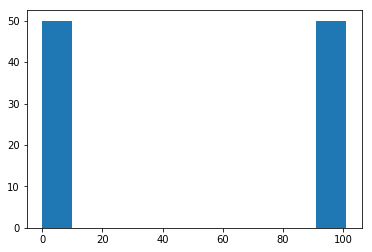

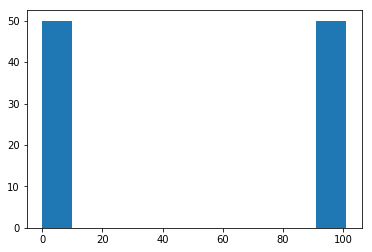

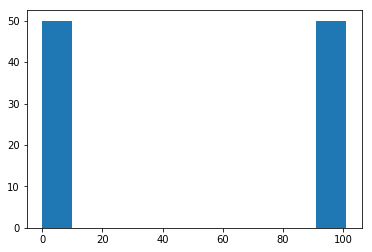

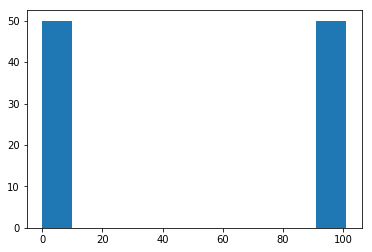

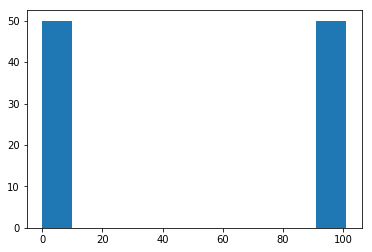

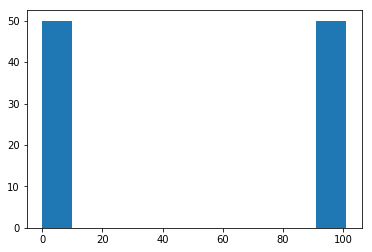

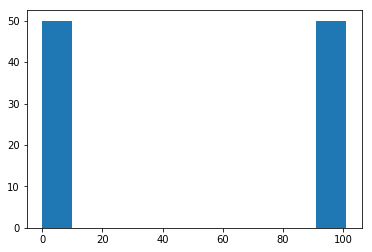

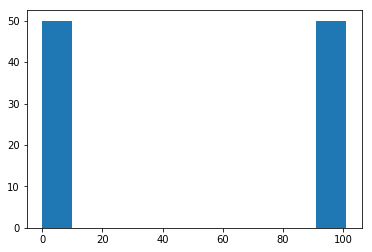

Iter: 800


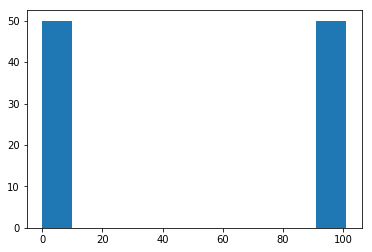

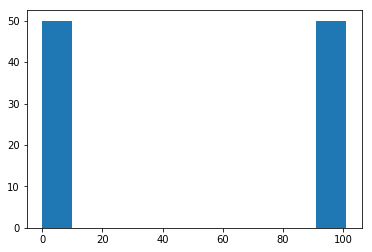

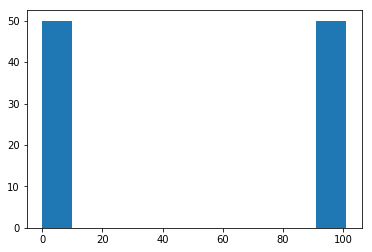

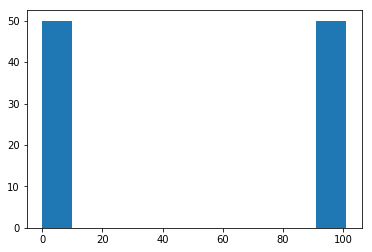

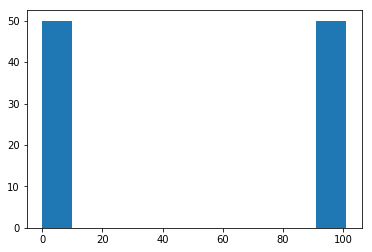

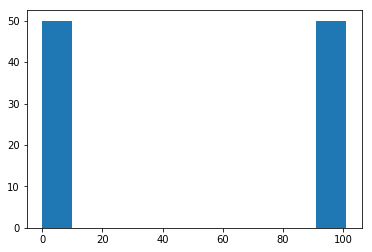

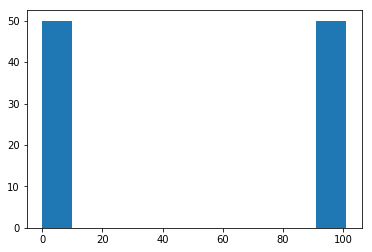

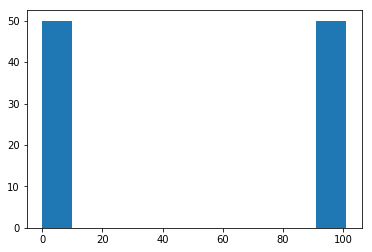

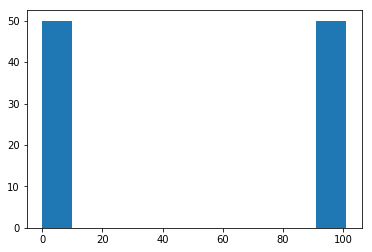

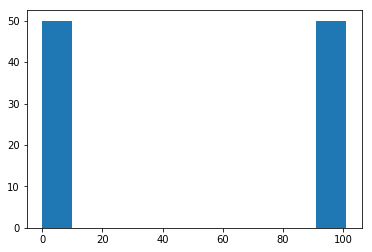

Iter: 900


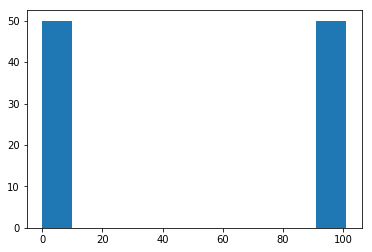

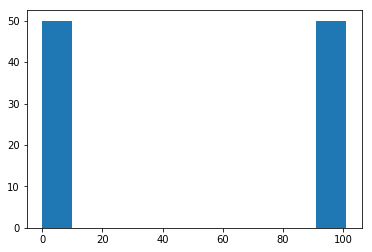

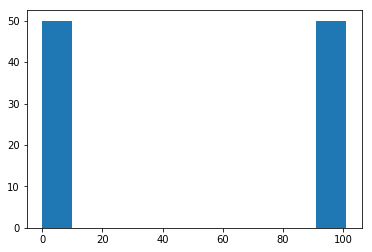

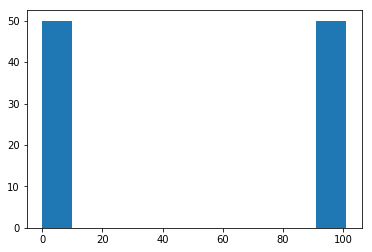

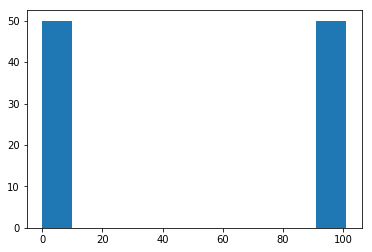

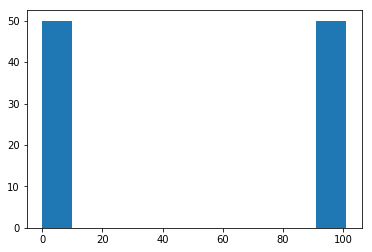

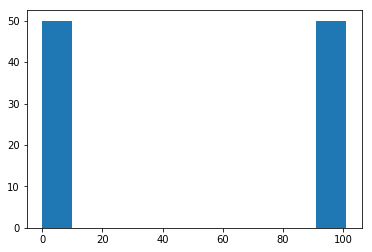

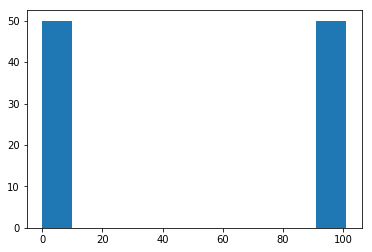

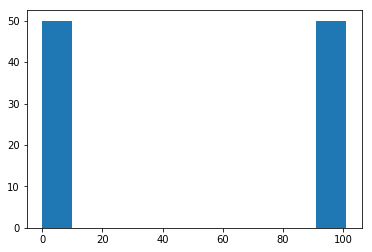

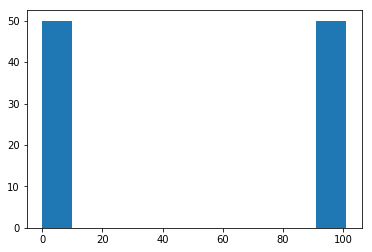

Iter: 0


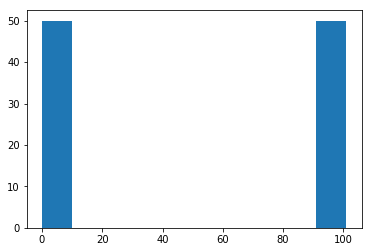

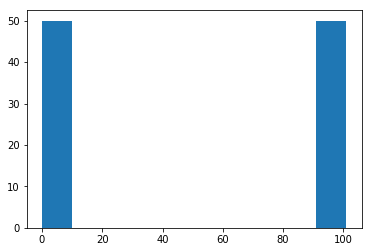

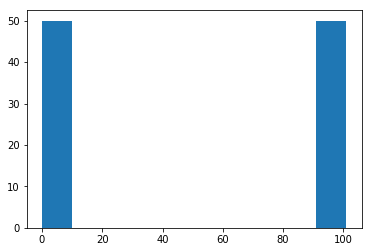

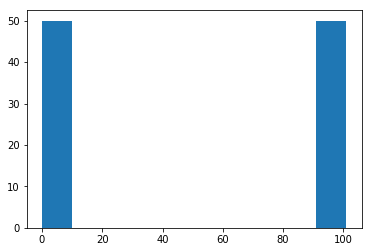

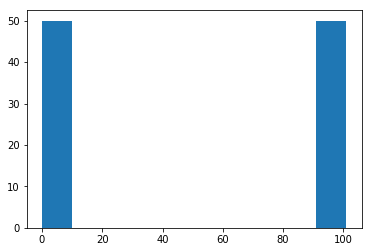

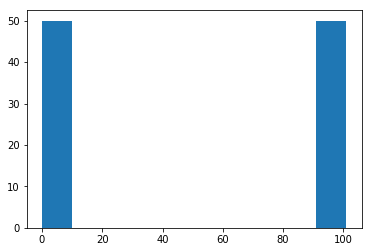

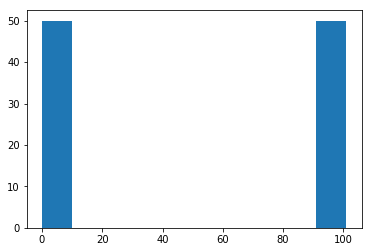

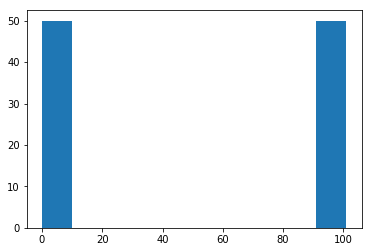

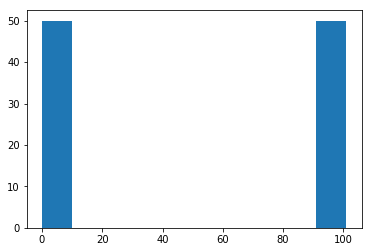

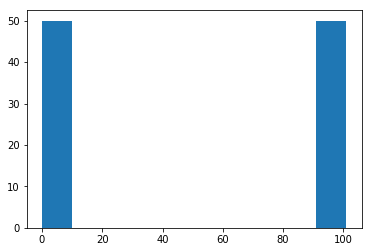

Iter: 100


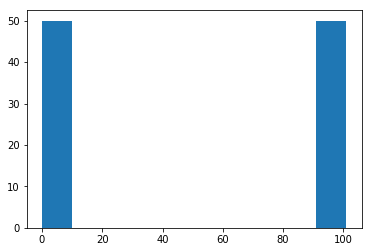

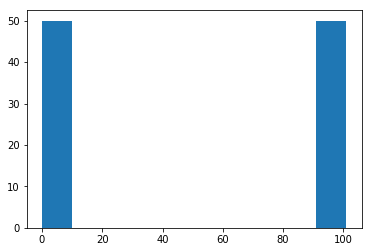

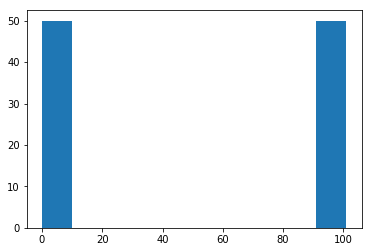

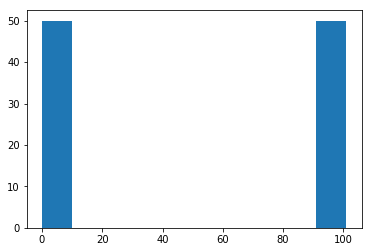

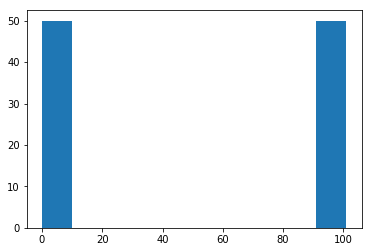

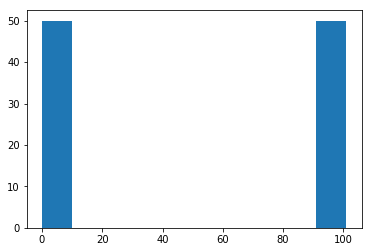

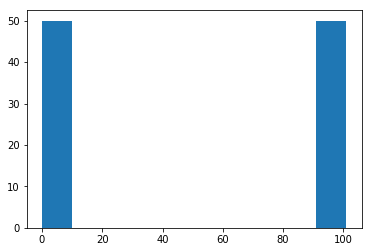

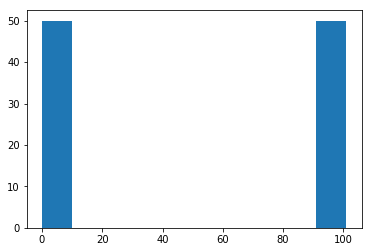

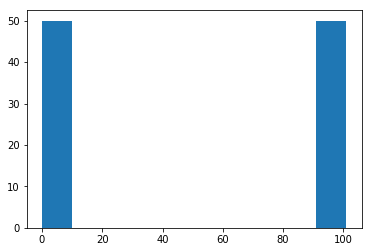

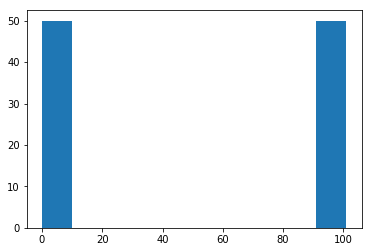

Iter: 200


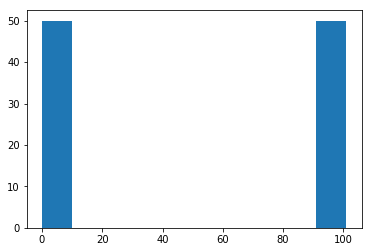

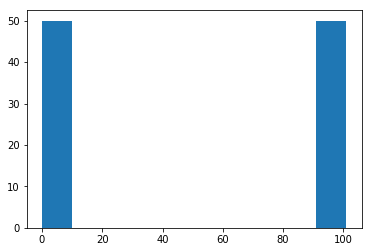

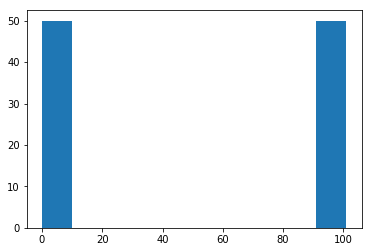

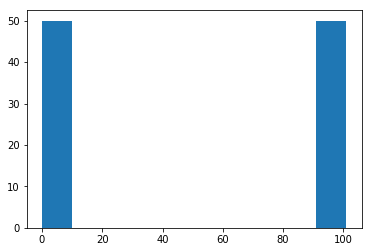

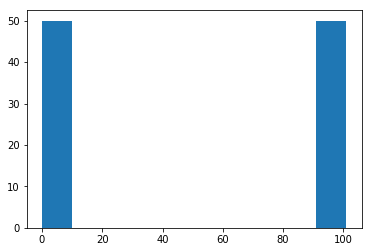

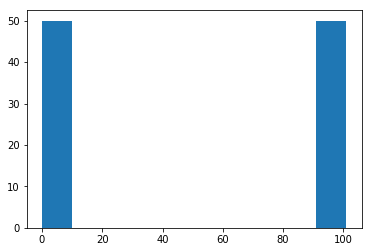

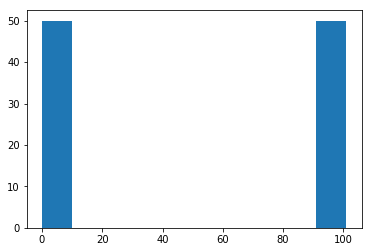

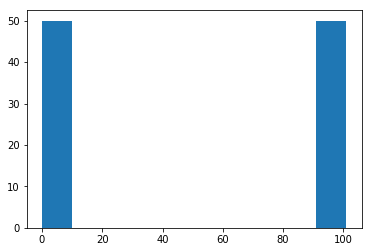

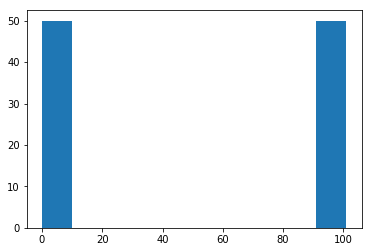

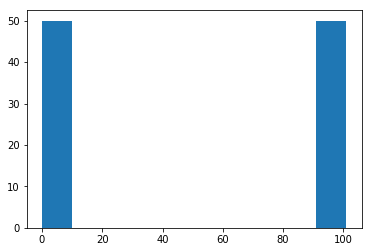

Iter: 300


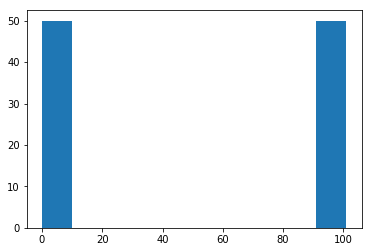

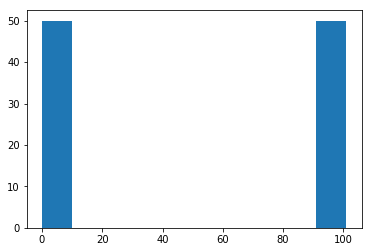

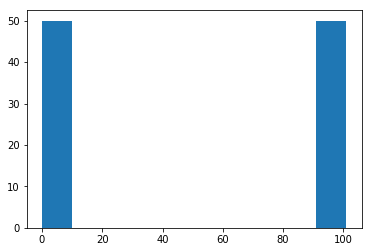

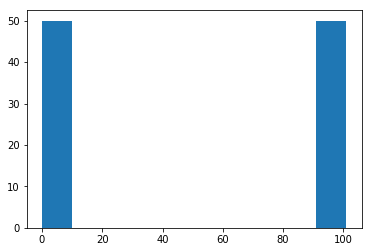

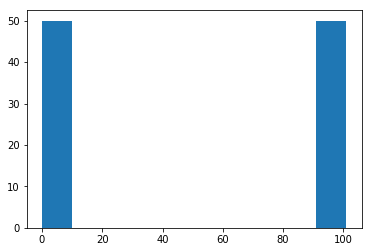

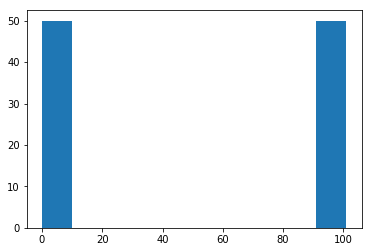

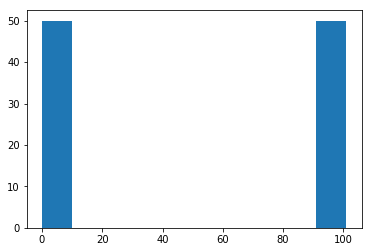

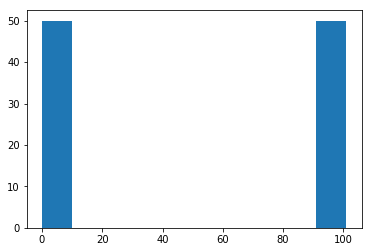

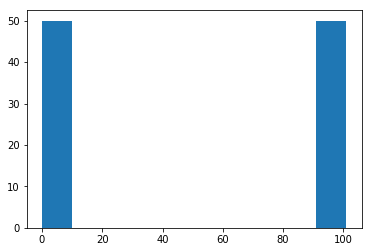

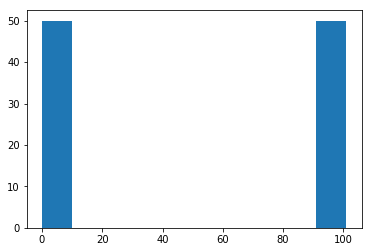

Iter: 400


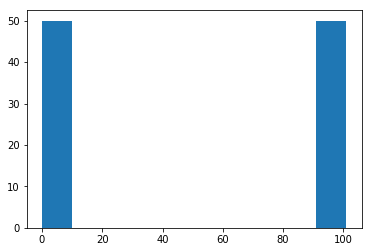

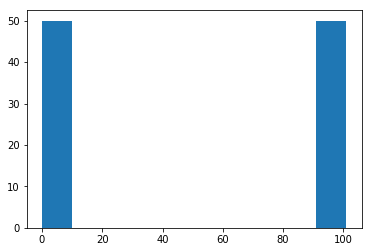

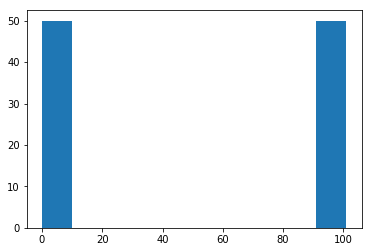

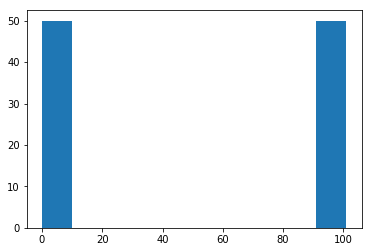

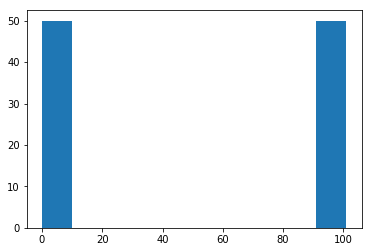

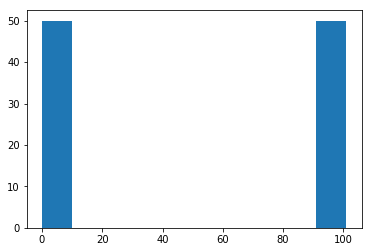

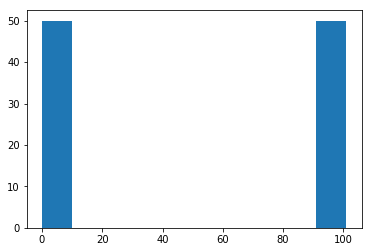

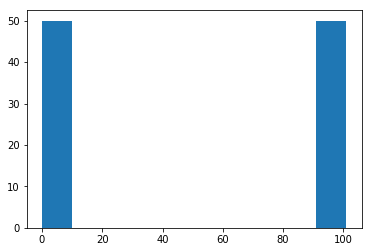

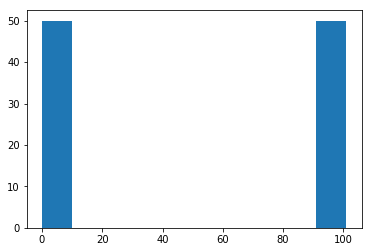

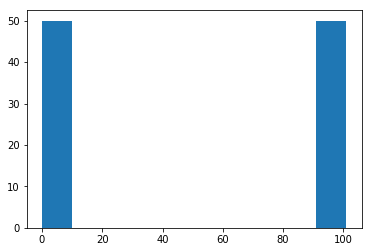

Iter: 500


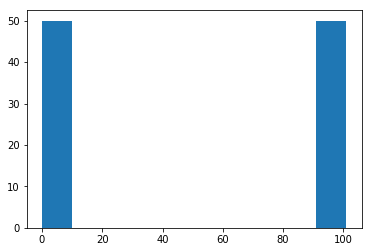

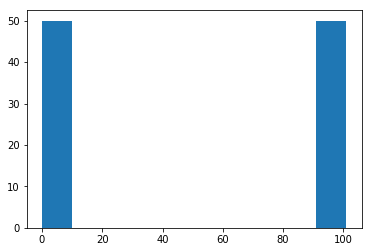

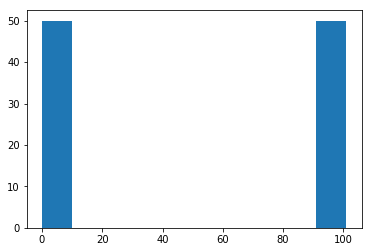

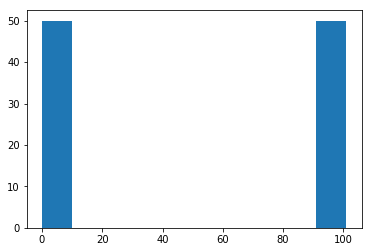

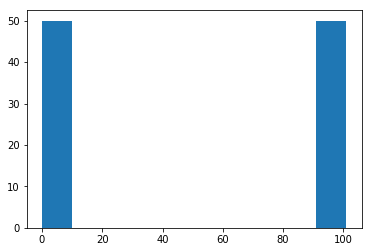

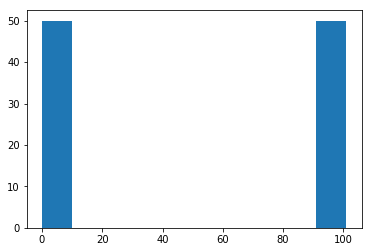

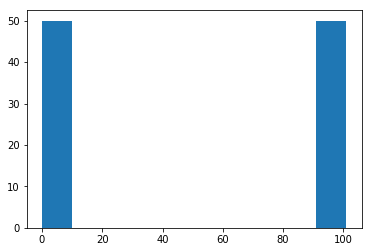

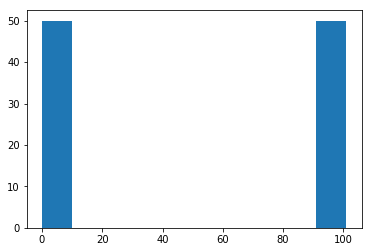

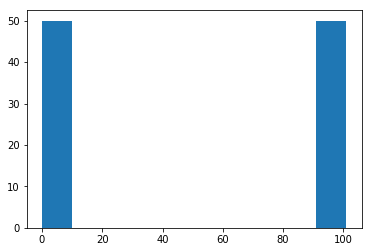

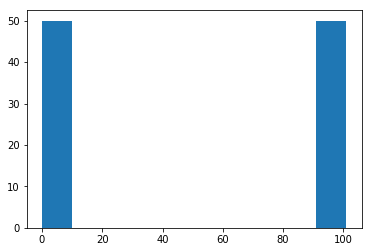

Iter: 600


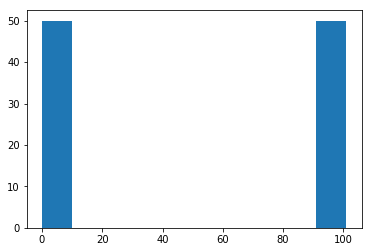

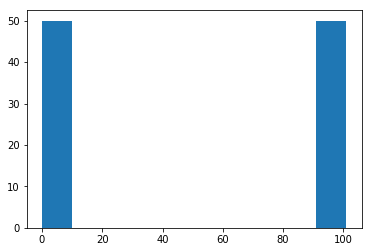

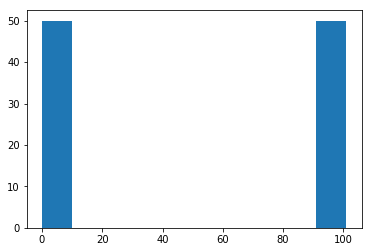

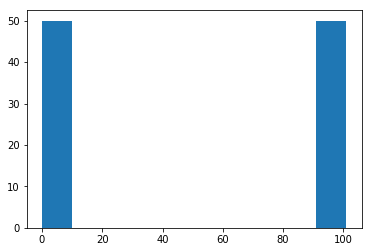

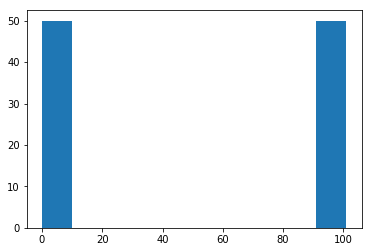

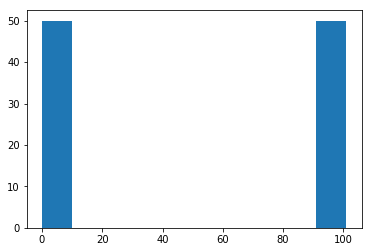

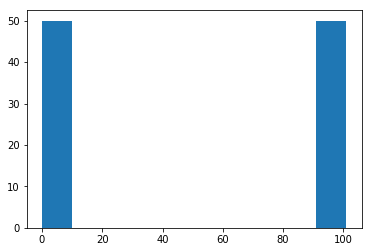

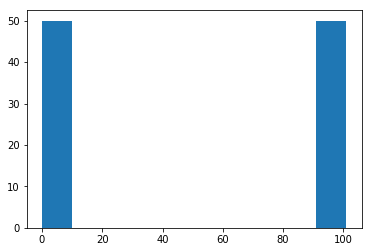

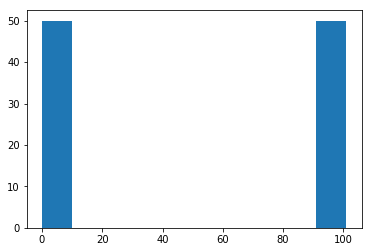

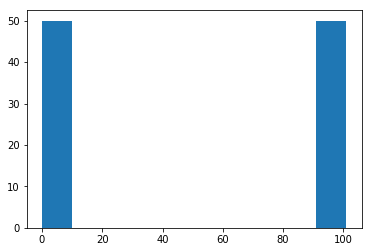

Iter: 700


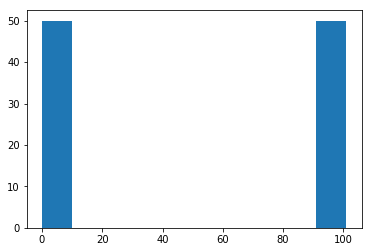

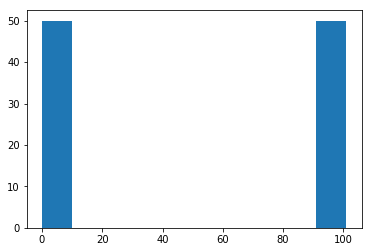

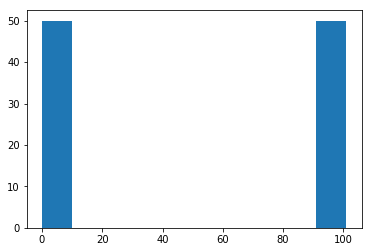

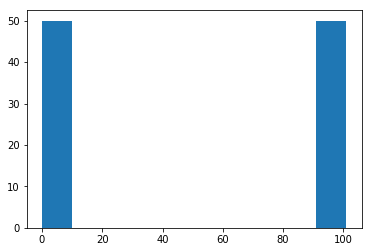

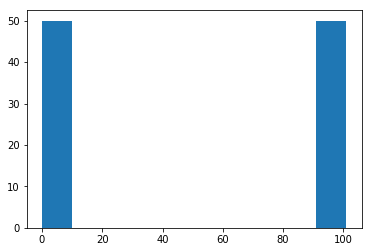

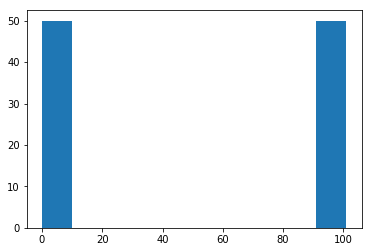

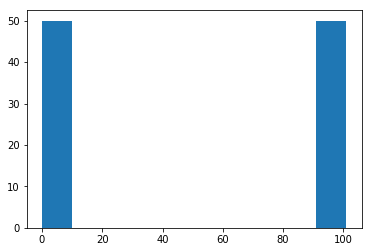

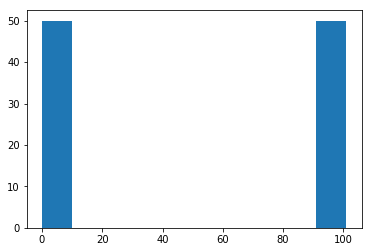

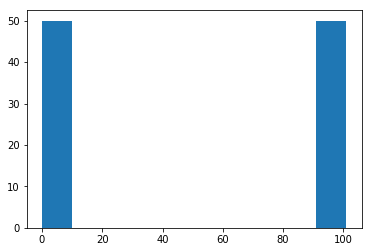

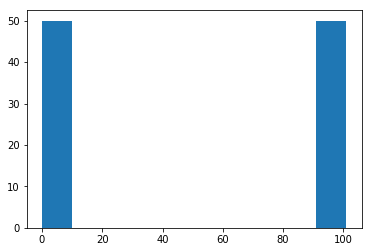

Iter: 800


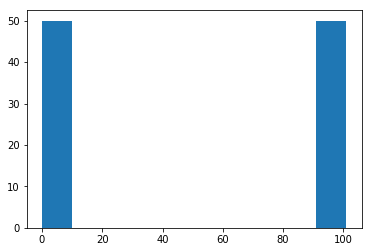

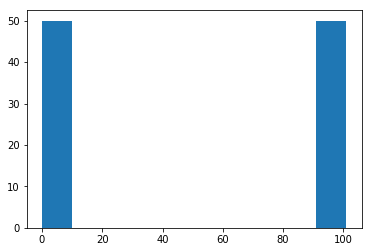

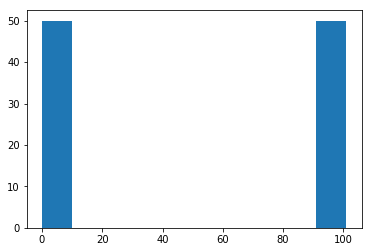

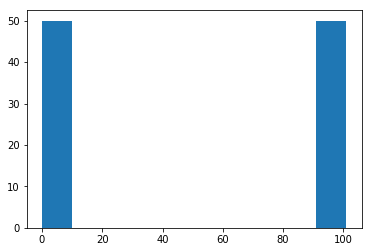

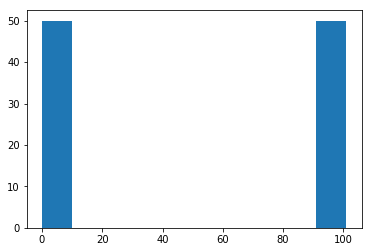

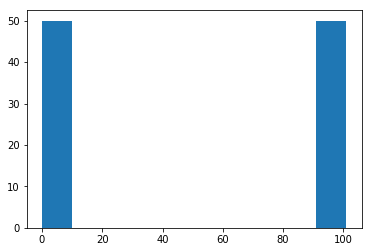

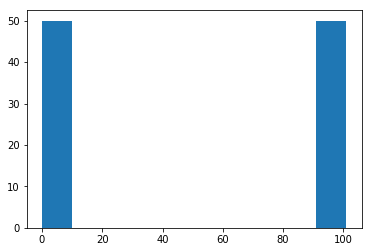

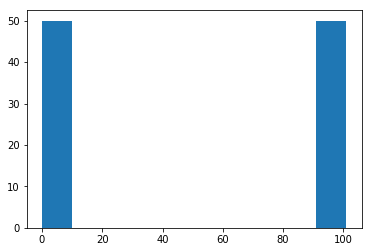

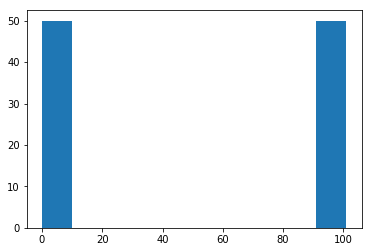

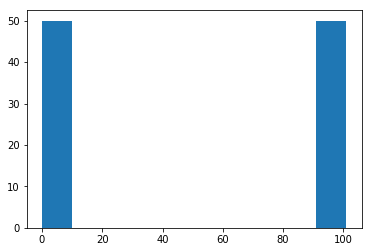

Iter: 900


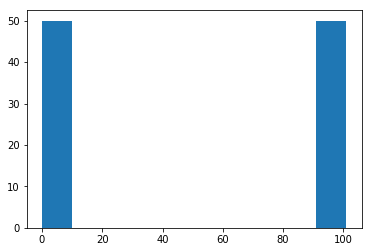

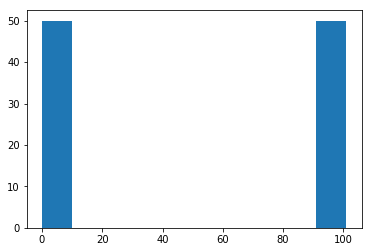

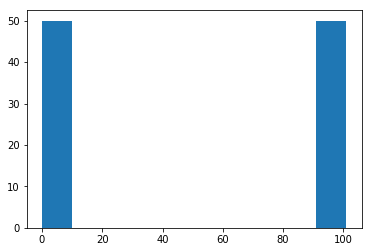

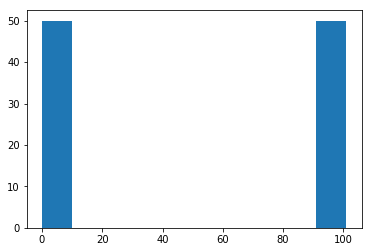

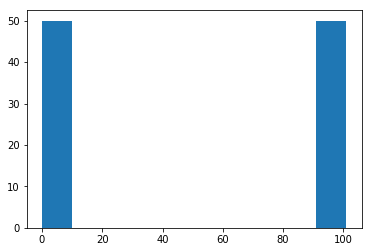

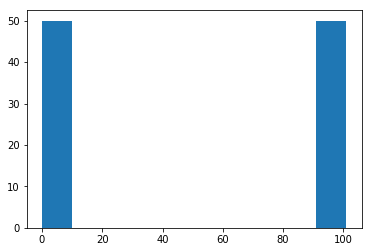

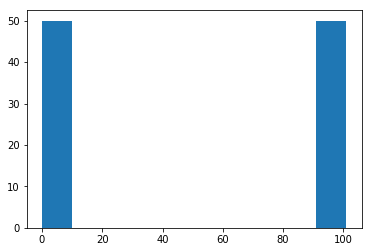

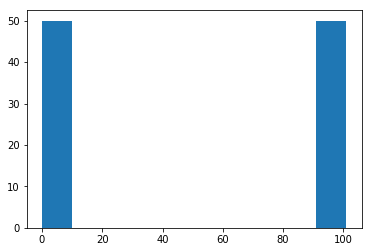

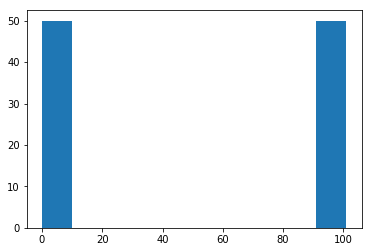

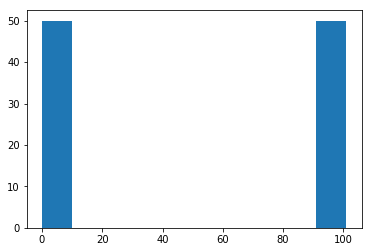

Iter: 0


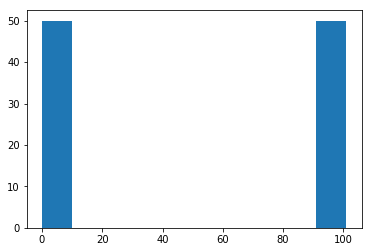

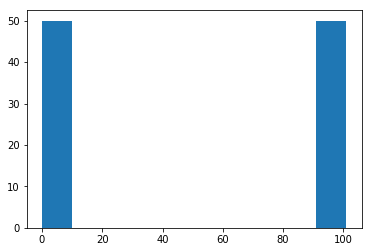

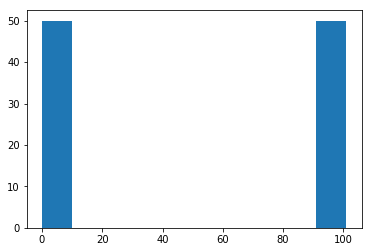

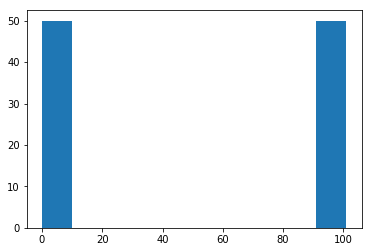

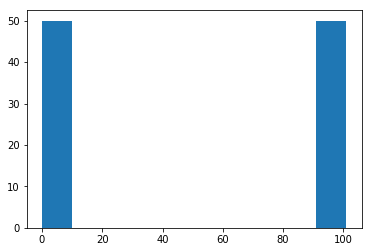

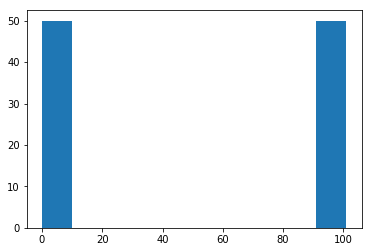

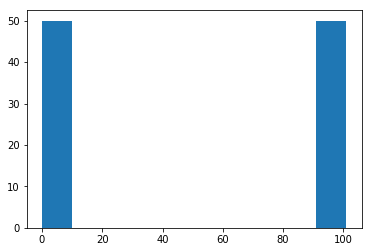

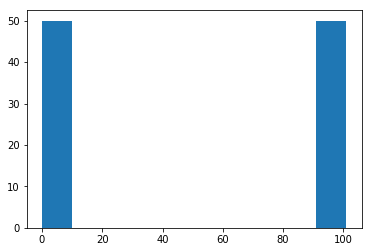

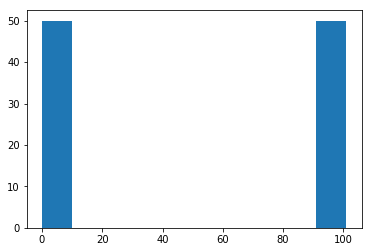

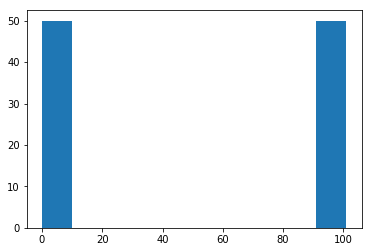

Iter: 100


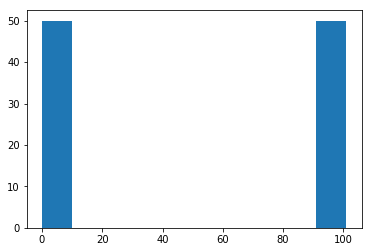

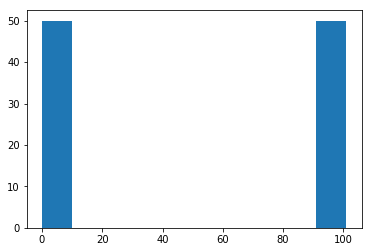

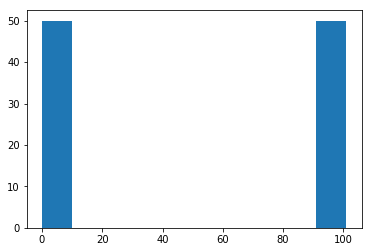

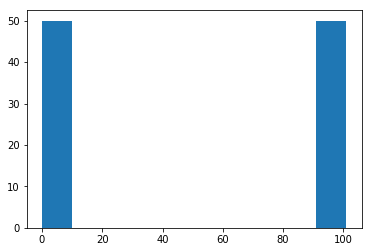

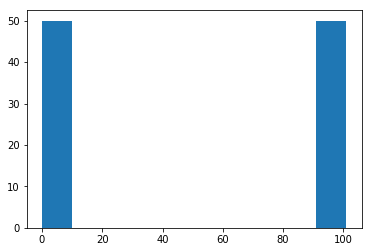

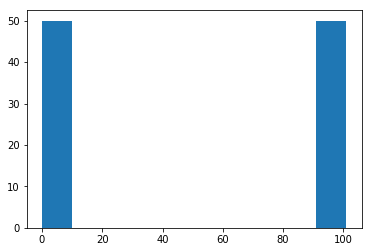

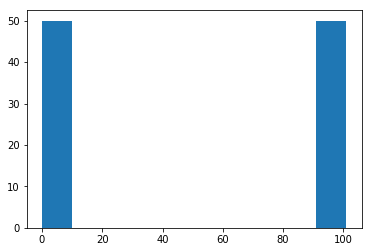

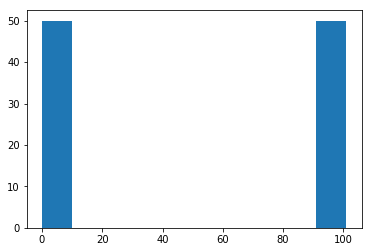

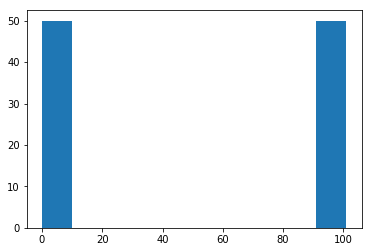

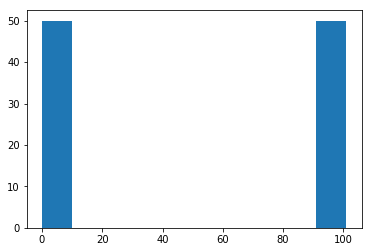

Iter: 200


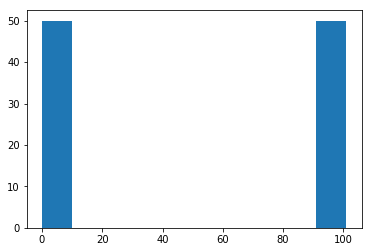

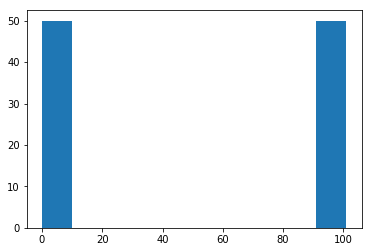

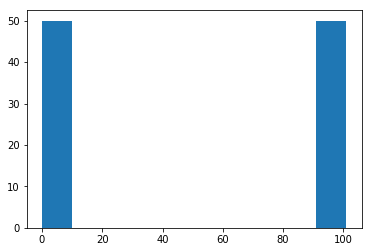

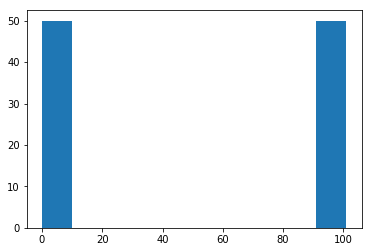

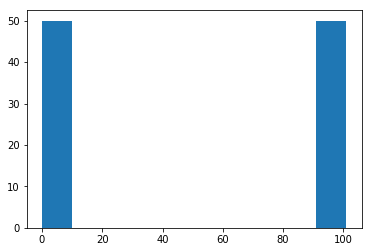

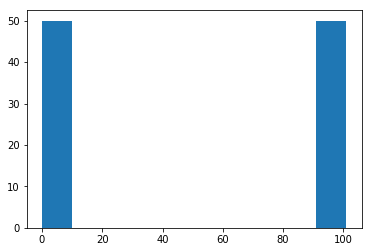

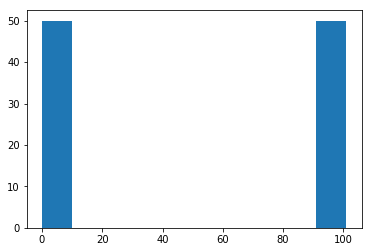

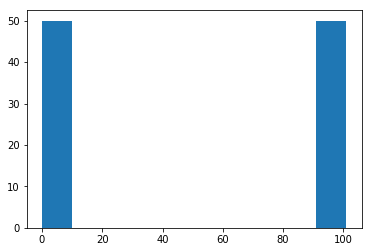

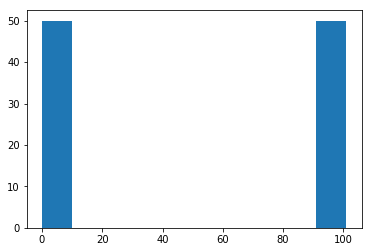

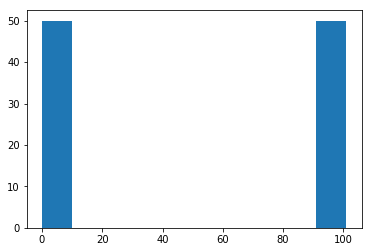

Iter: 300


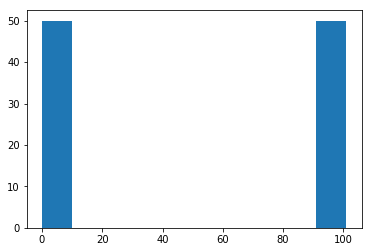

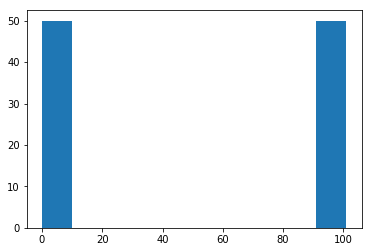

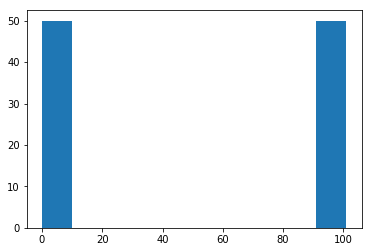

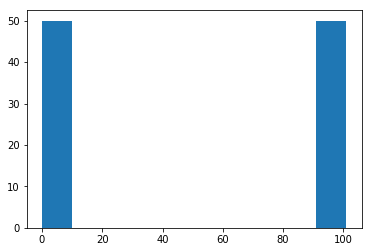

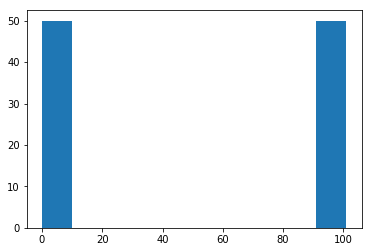

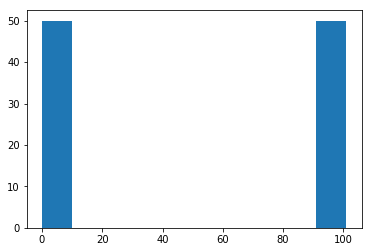

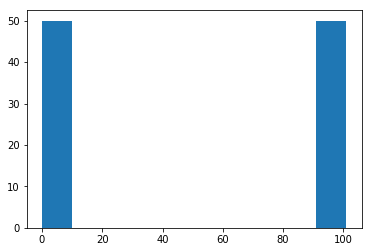

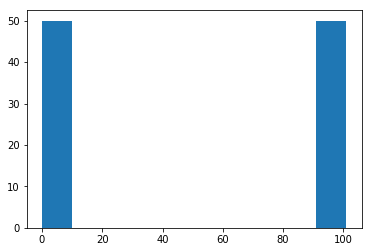

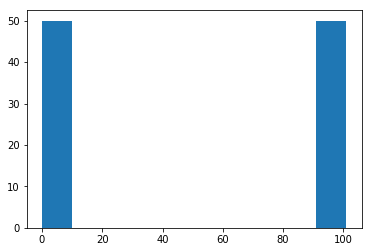

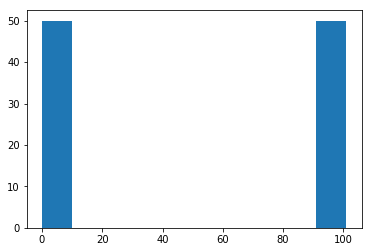

Iter: 400


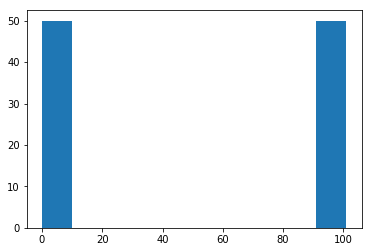

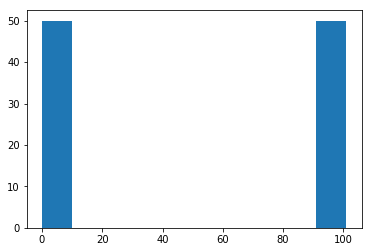

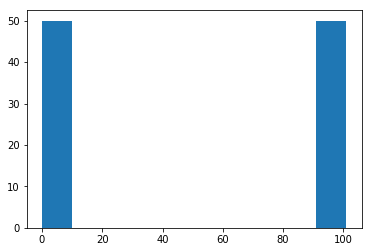

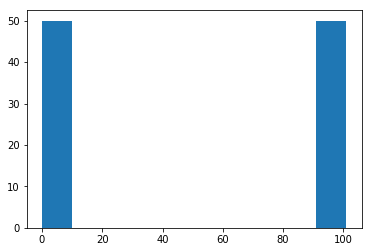

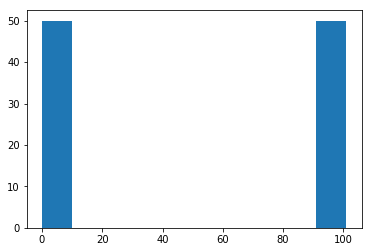

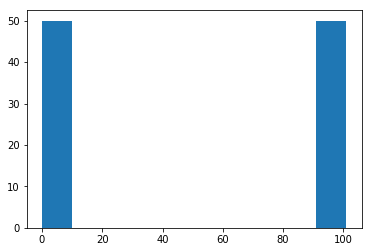

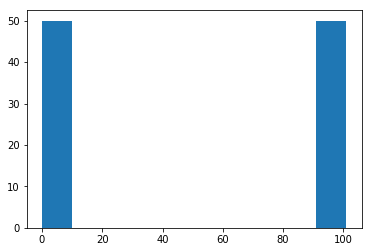

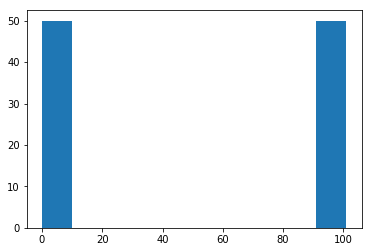

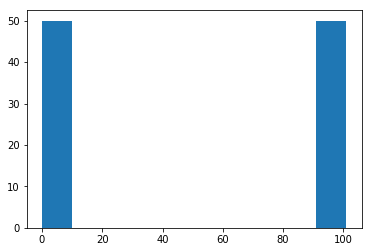

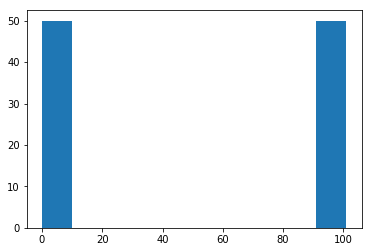

Iter: 500


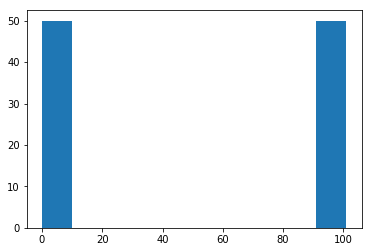

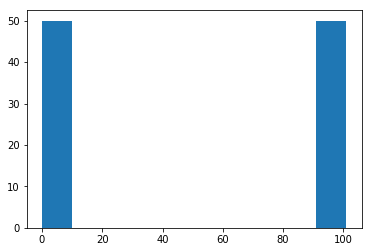

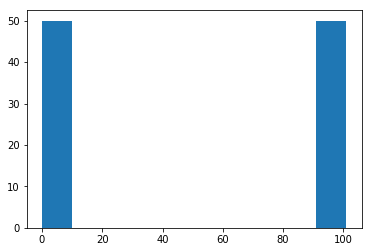

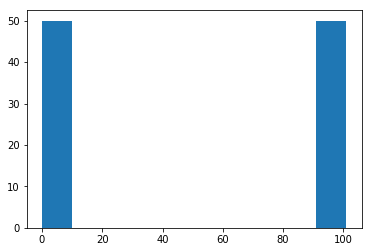

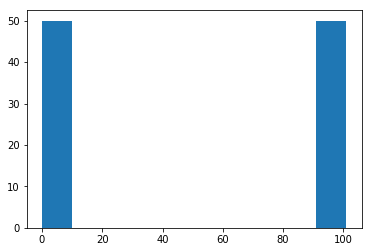

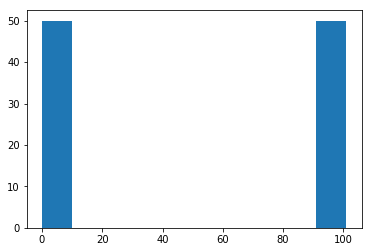

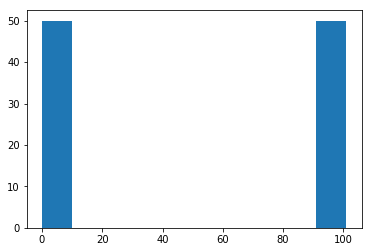

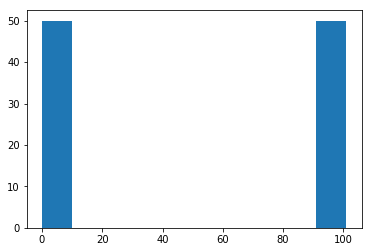

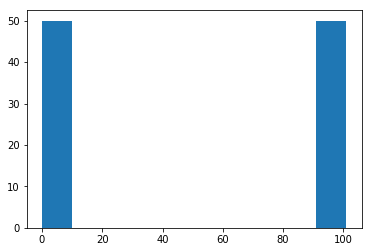

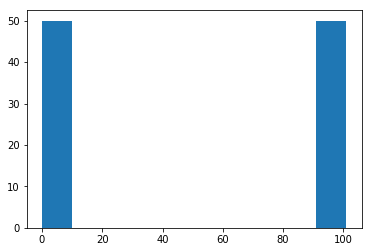

Iter: 600


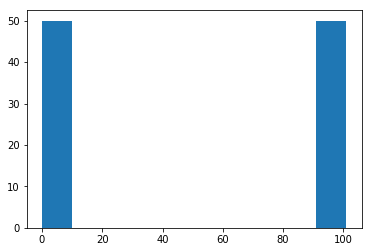

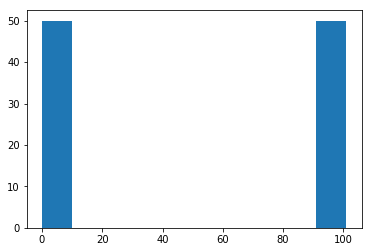

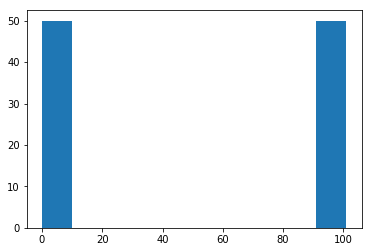

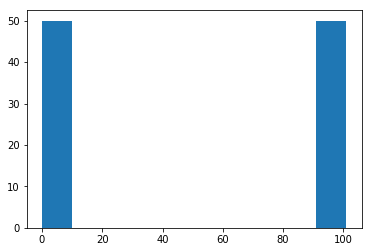

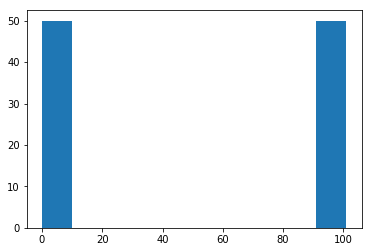

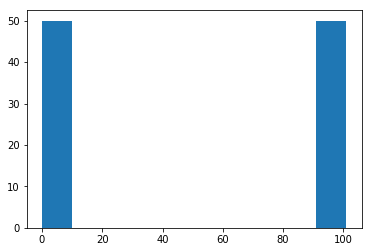

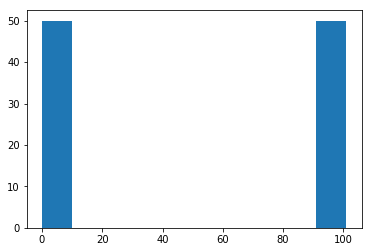

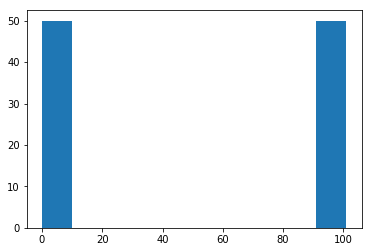

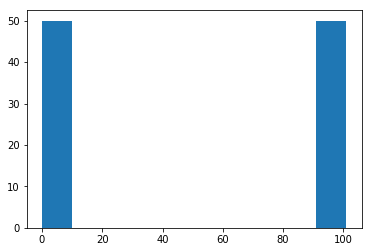

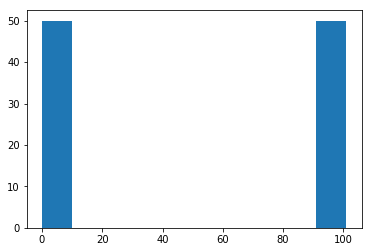

Iter: 700


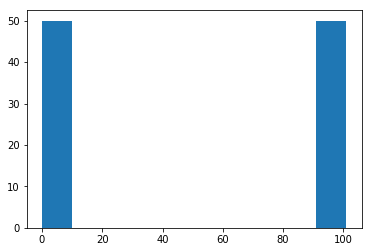

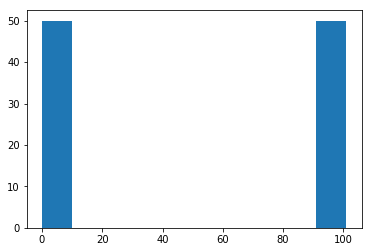

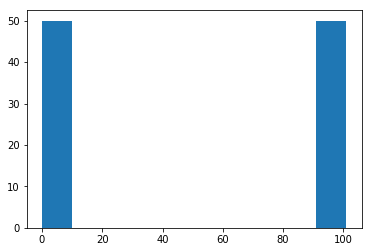

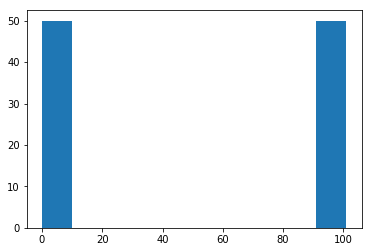

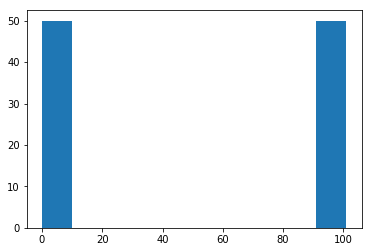

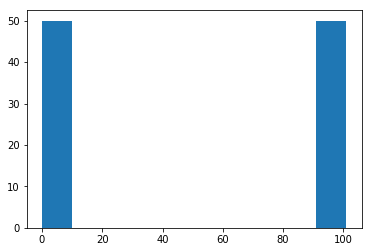

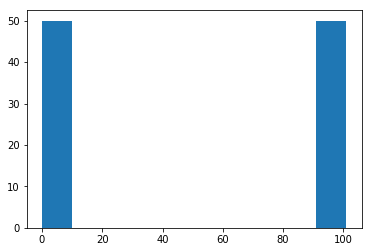

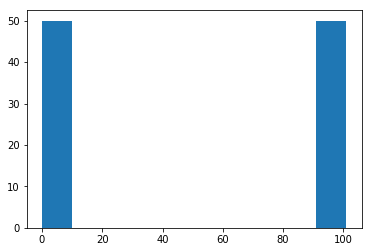

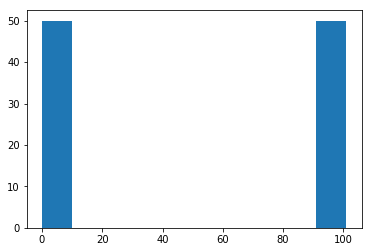

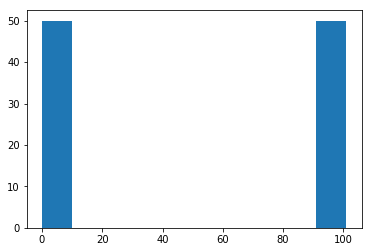

Iter: 800


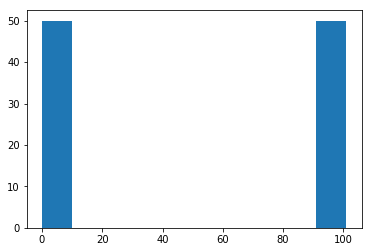

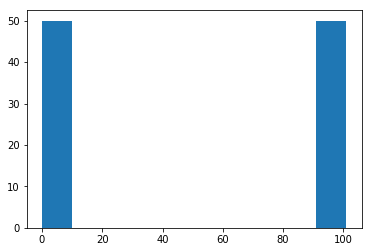

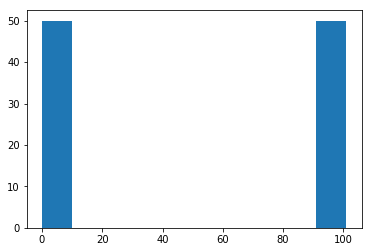

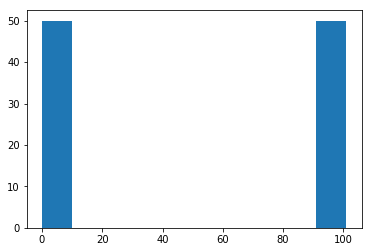

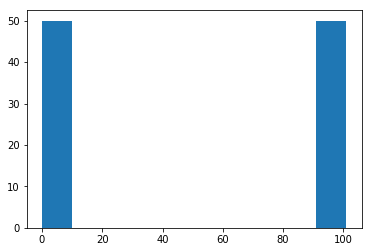

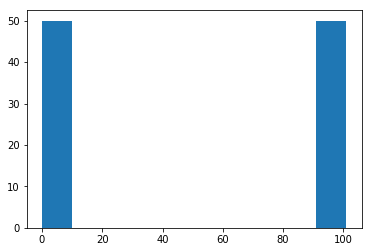

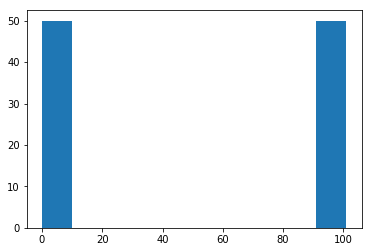

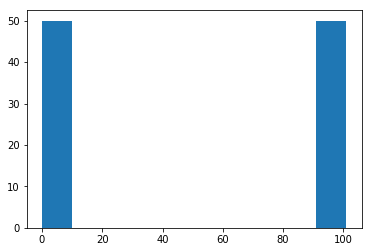

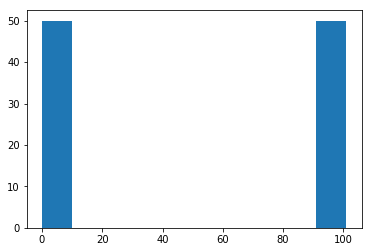

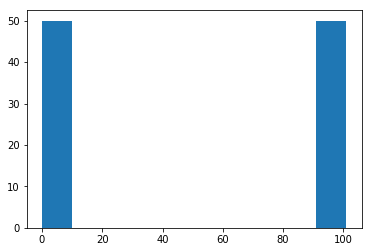

Iter: 900


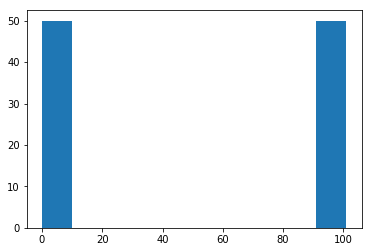

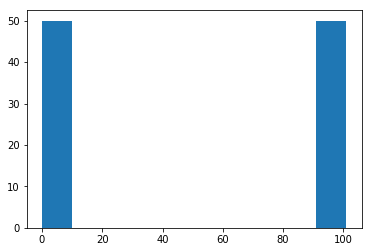

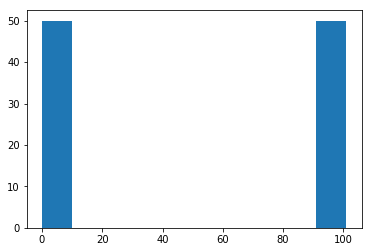

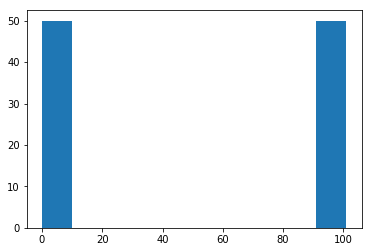

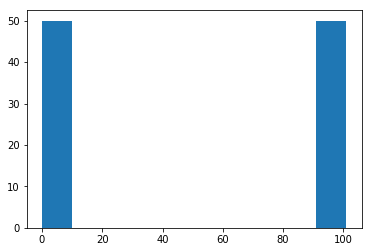

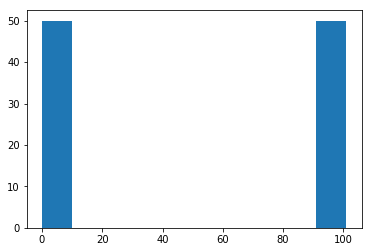

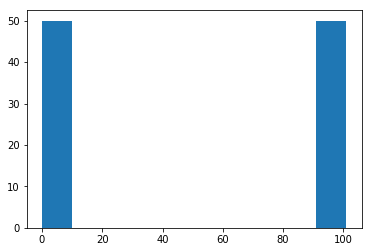

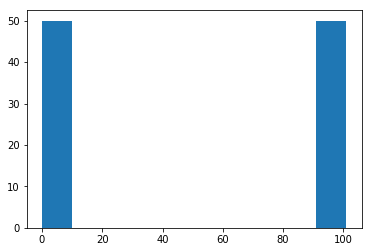

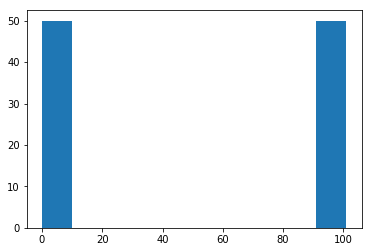

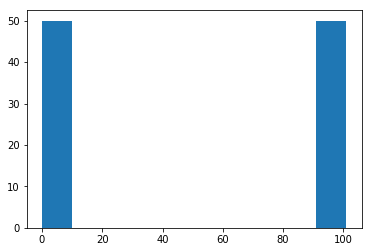

Iter: 0


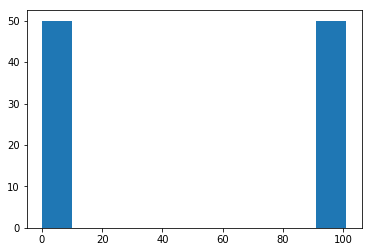

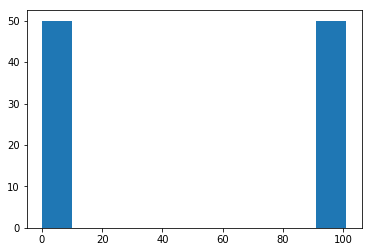

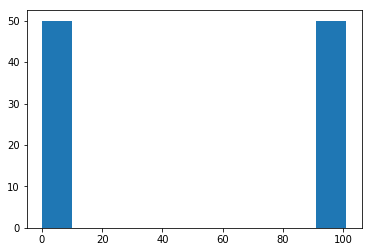

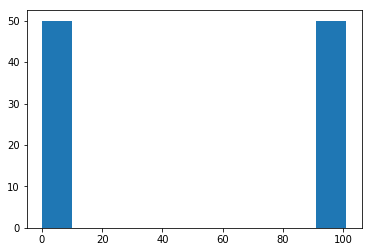

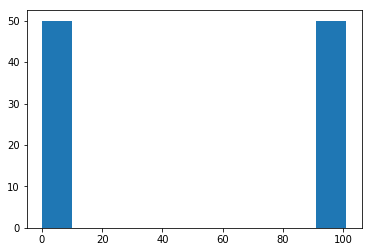

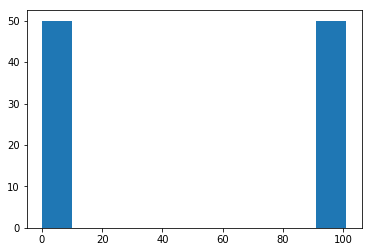

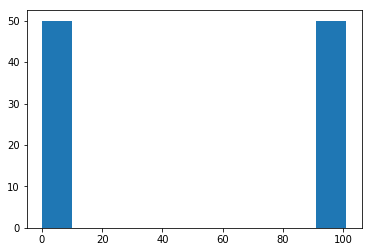

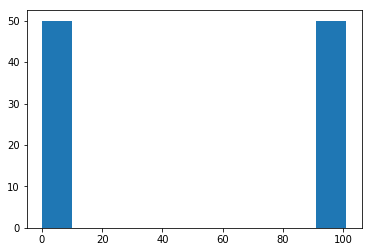

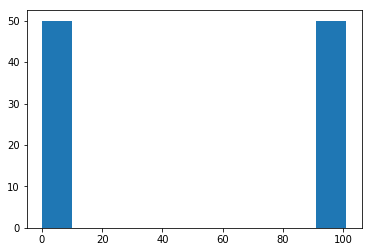

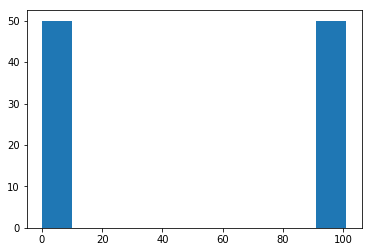

Iter: 100


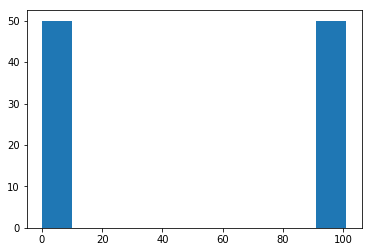

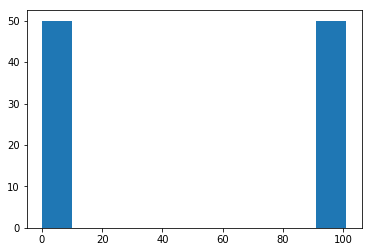

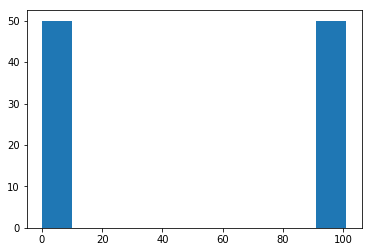

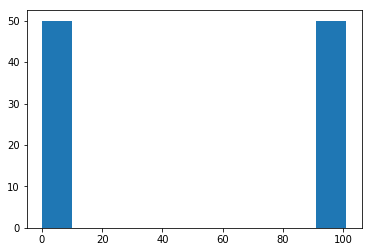

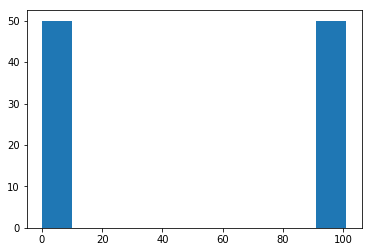

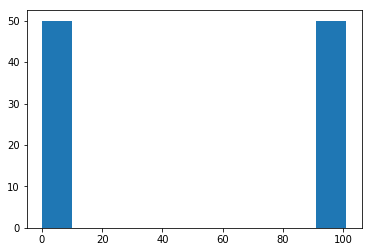

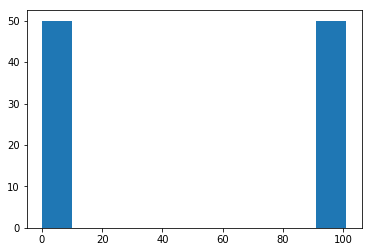

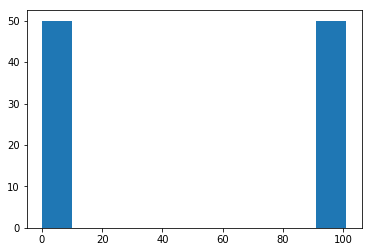

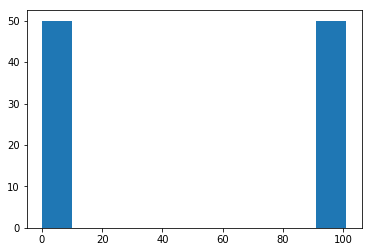

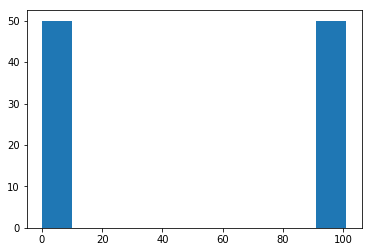

Iter: 200


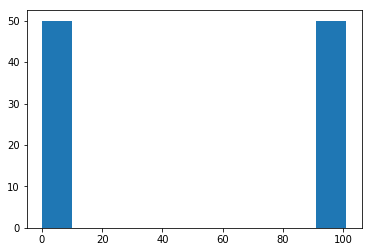

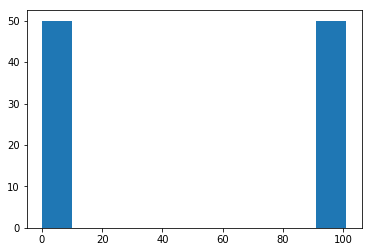

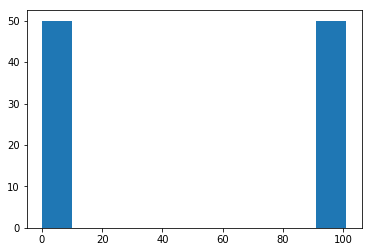

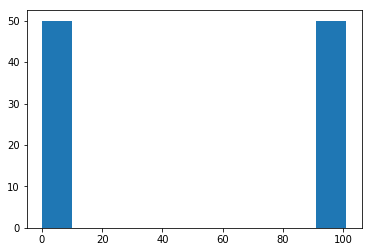

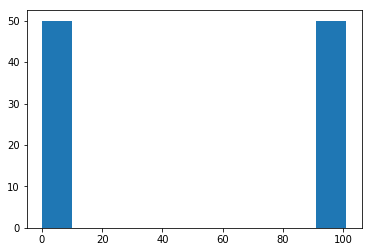

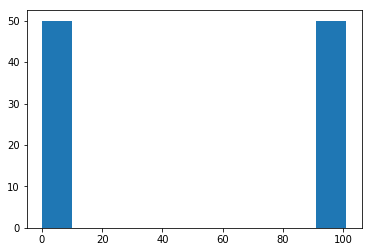

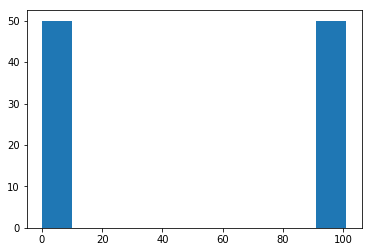

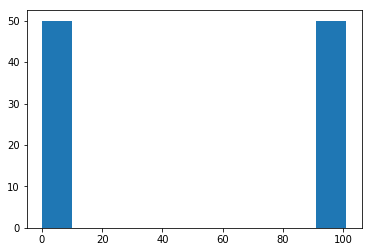

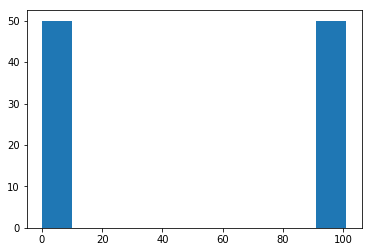

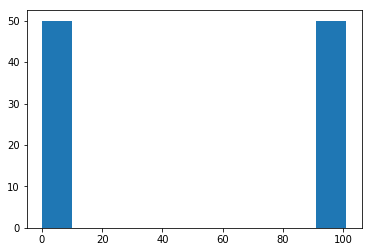

Iter: 300


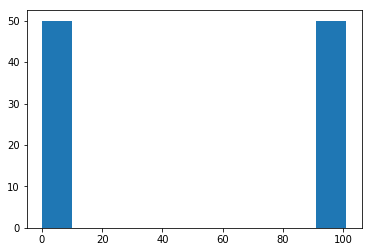

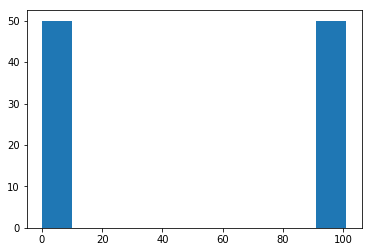

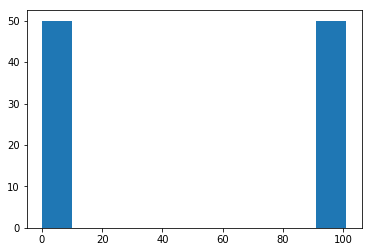

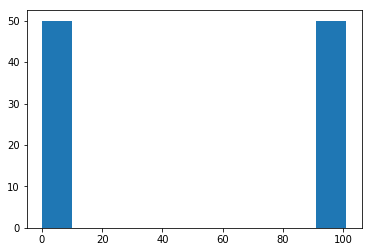

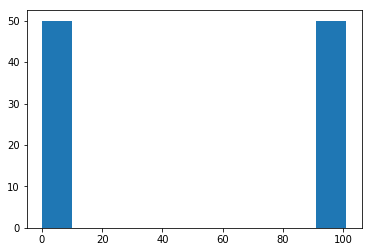

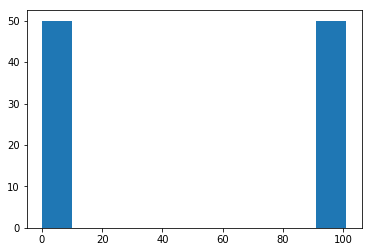

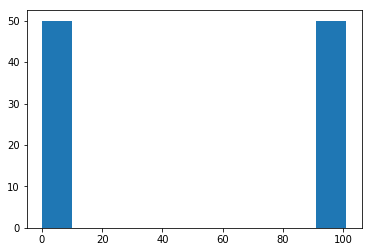

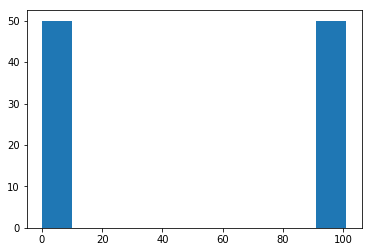

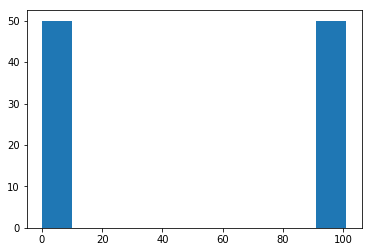

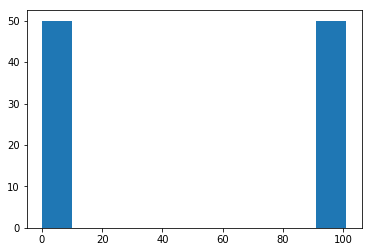

Iter: 400


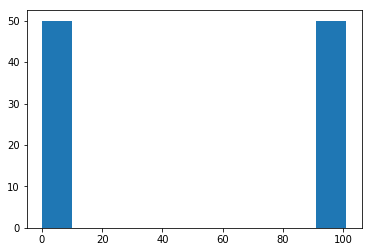

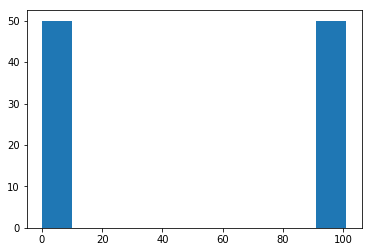

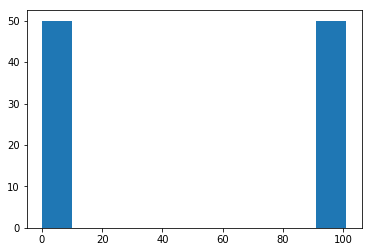

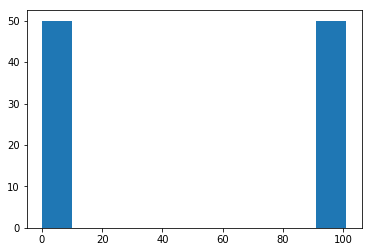

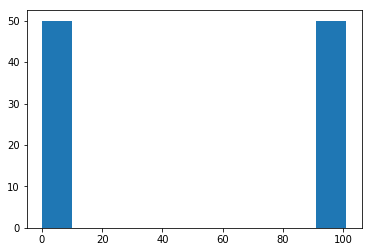

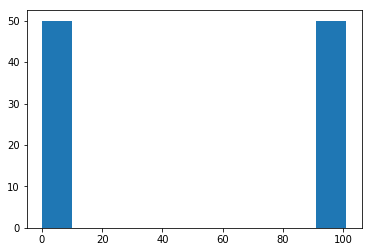

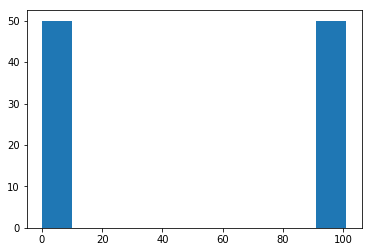

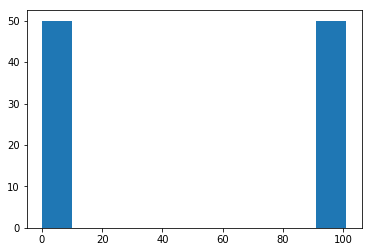

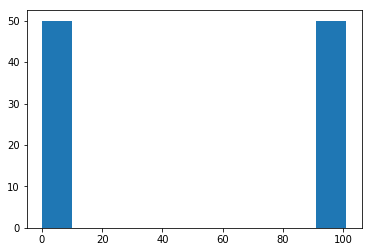

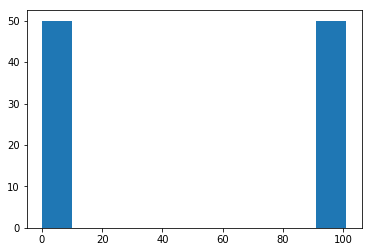

Iter: 500


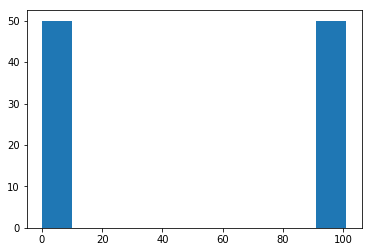

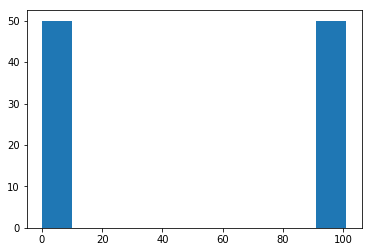

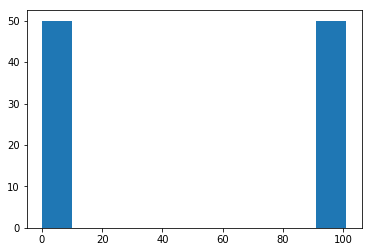

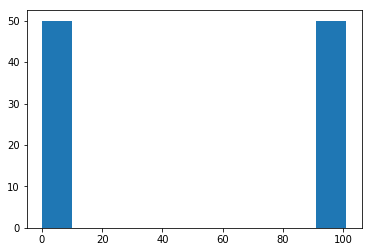

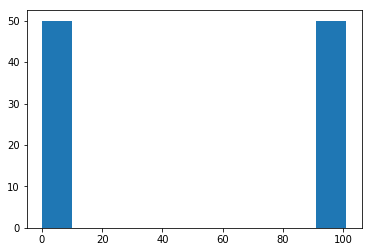

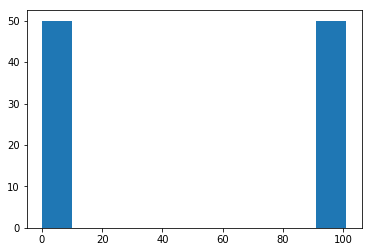

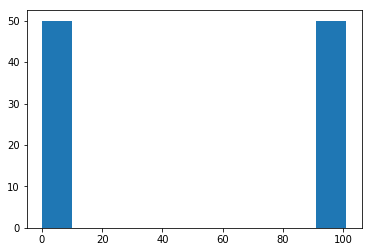

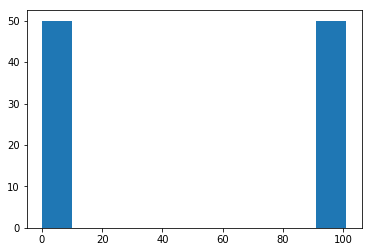

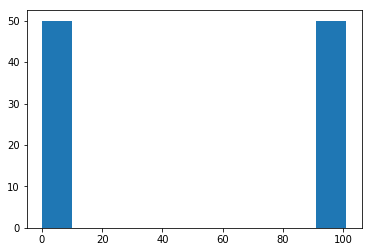

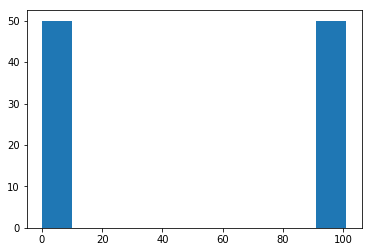

Iter: 600


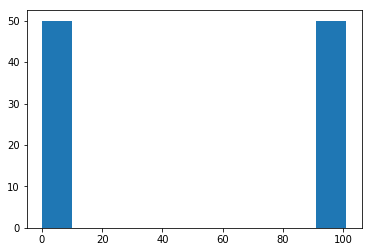

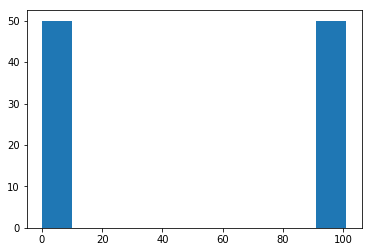

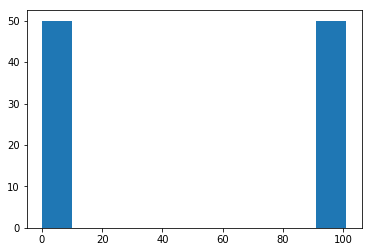

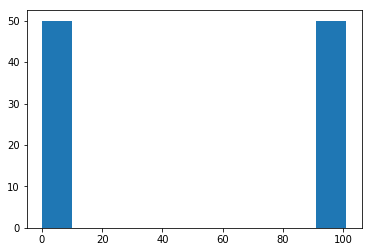

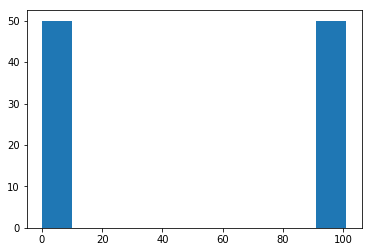

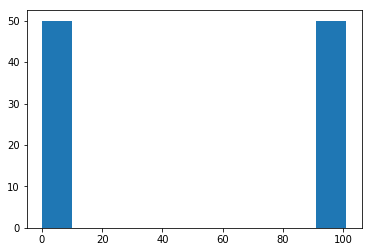

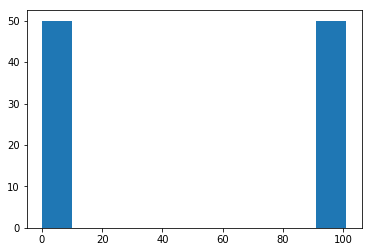

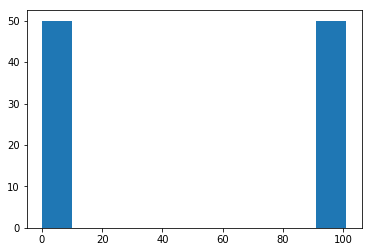

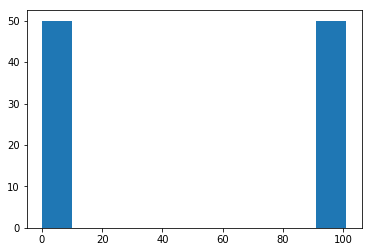

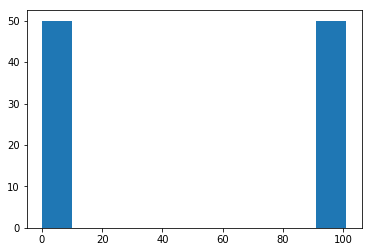

Iter: 700


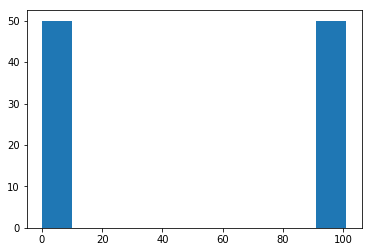

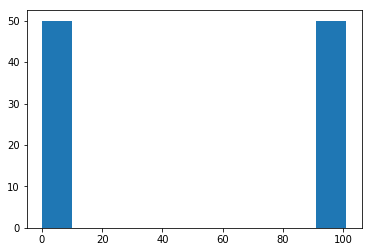

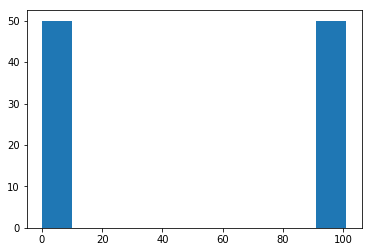

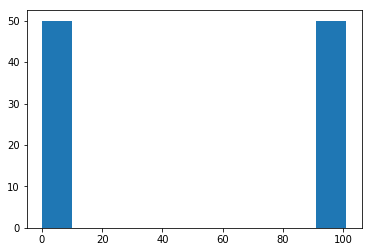

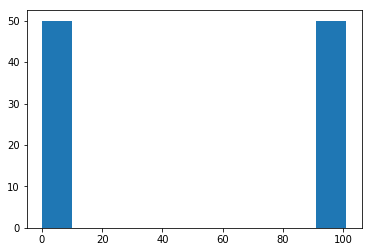

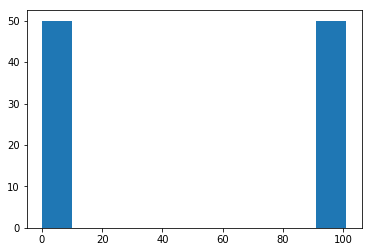

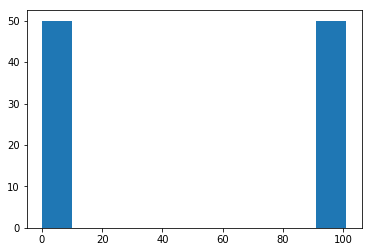

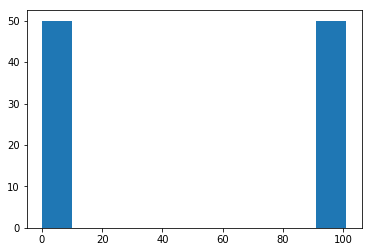

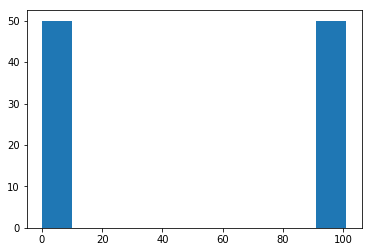

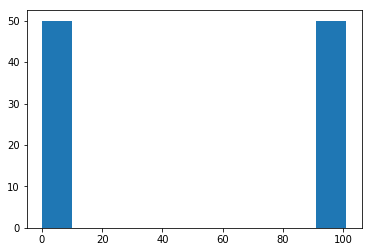

Iter: 800


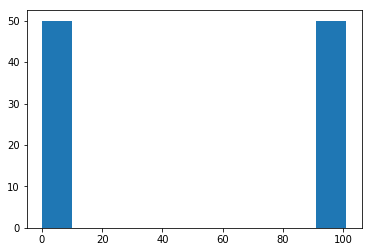

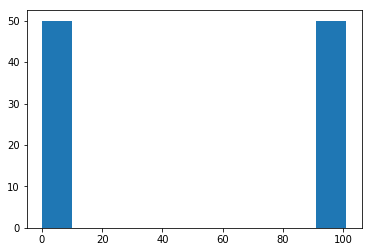

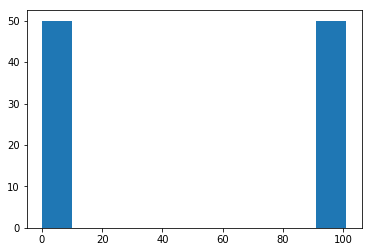

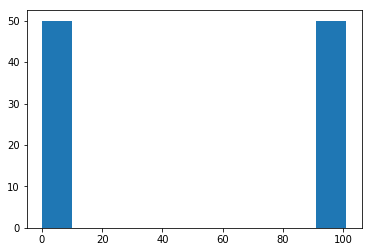

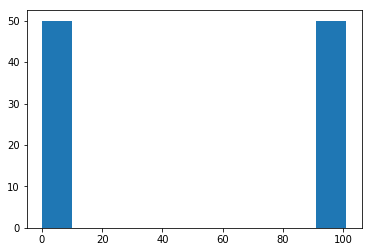

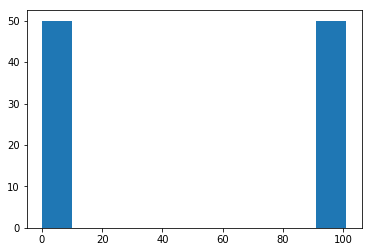

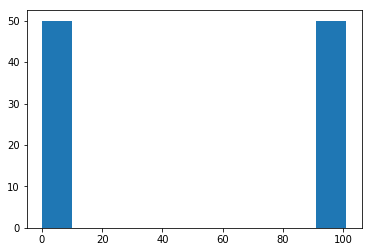

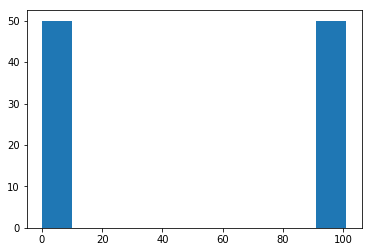

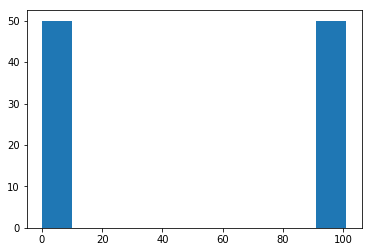

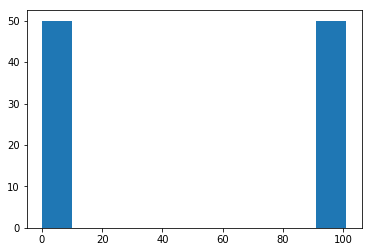

Iter: 900


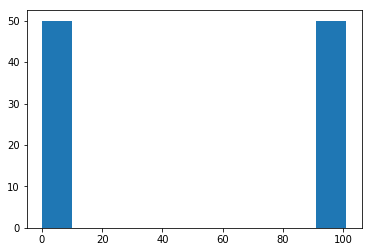

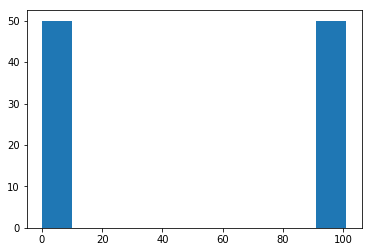

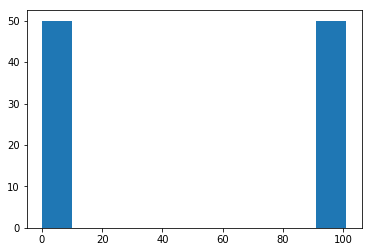

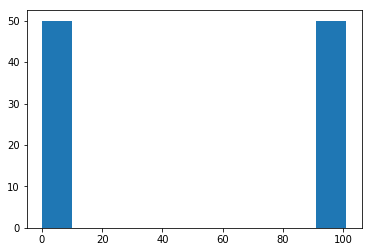

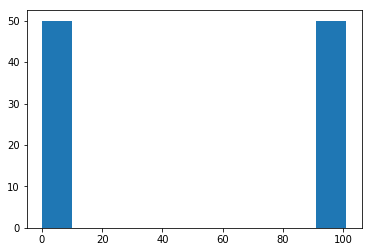

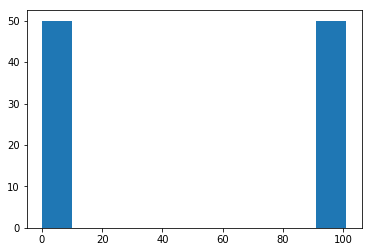

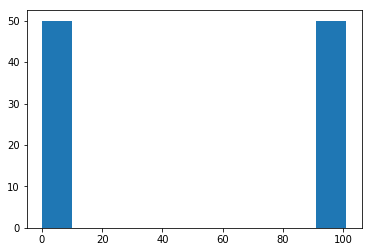

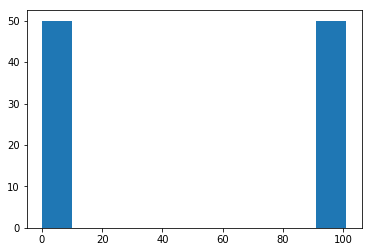

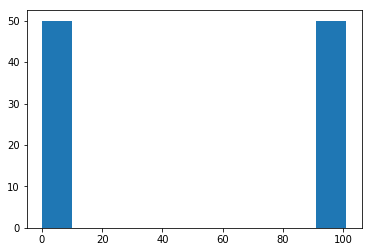

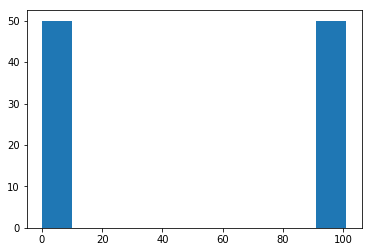

Iter: 0


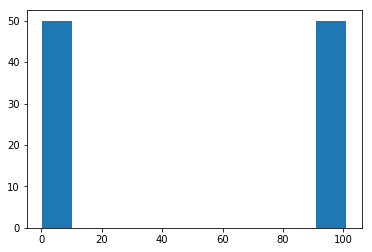

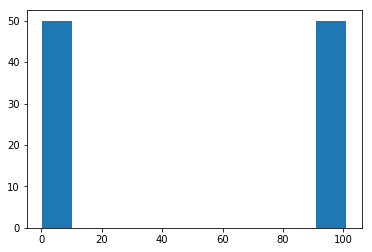

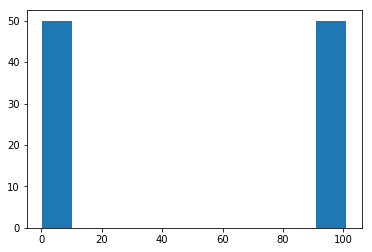

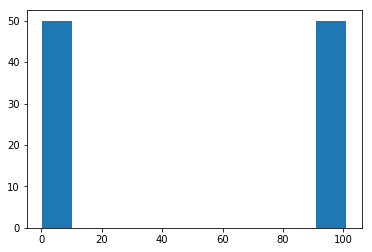

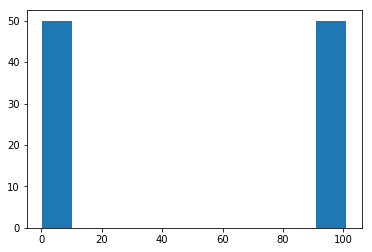

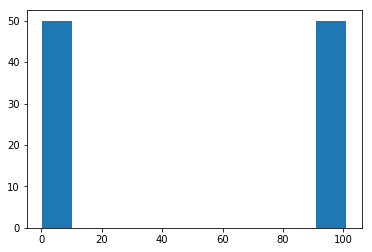

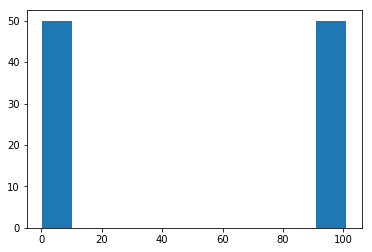

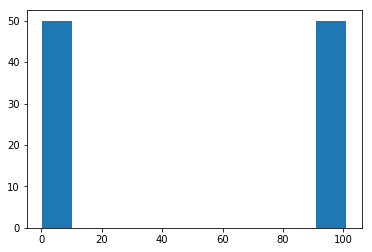

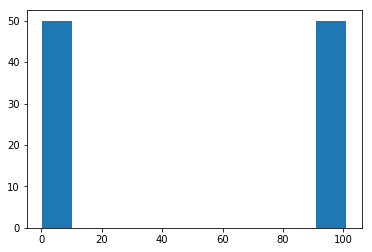

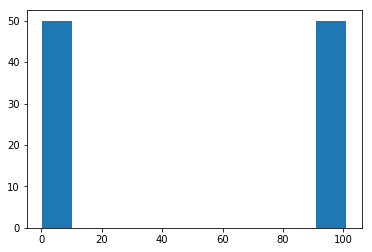

Iter: 100


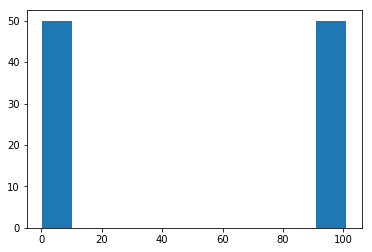

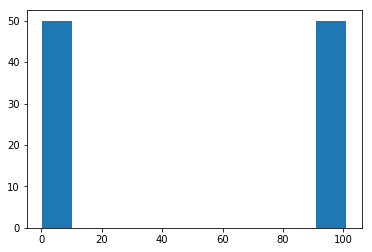

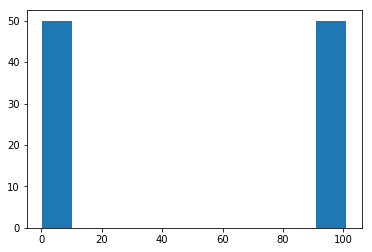

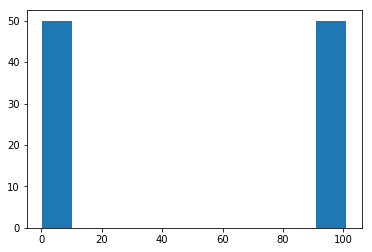

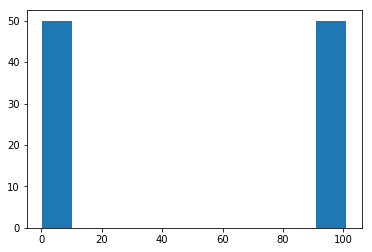

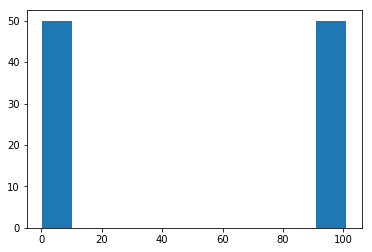

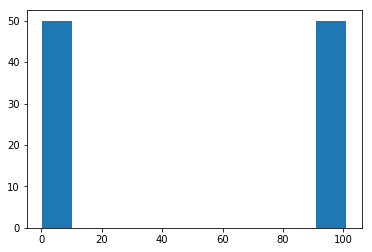

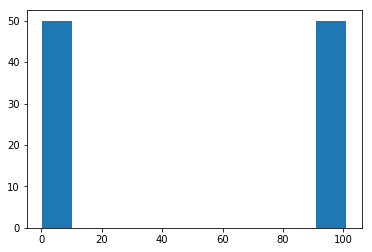

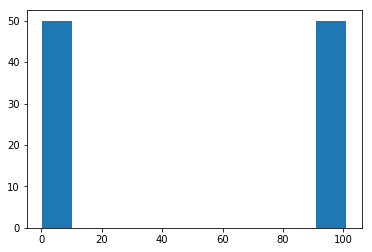

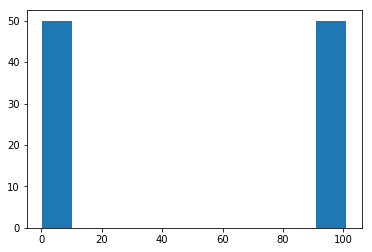

Iter: 200


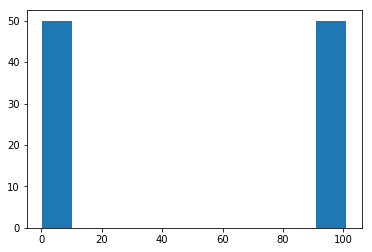

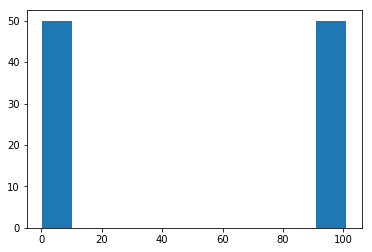

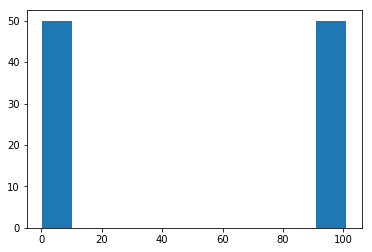

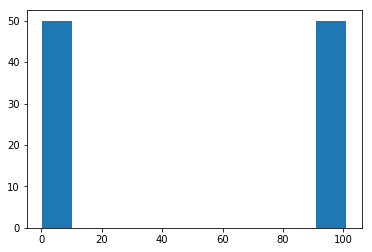

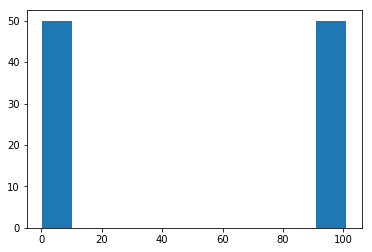

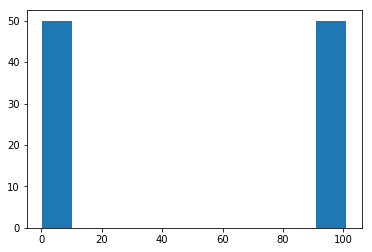

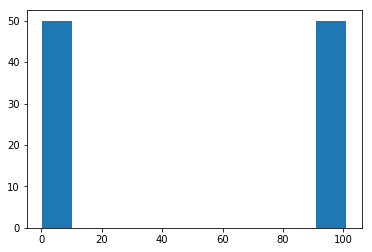

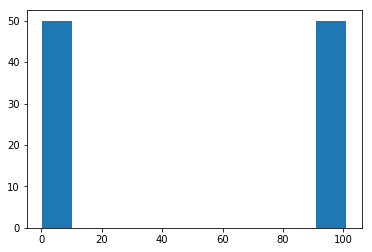

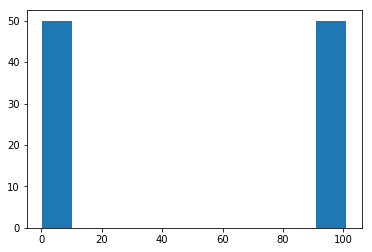

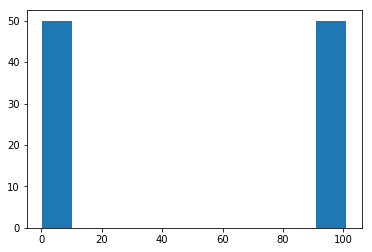

Iter: 300


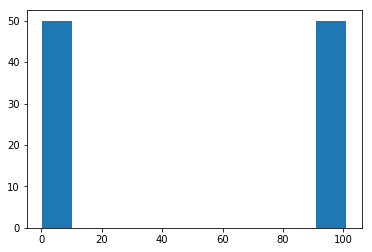

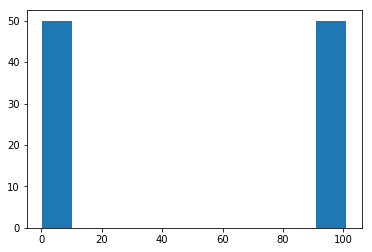

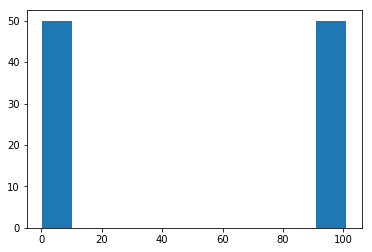

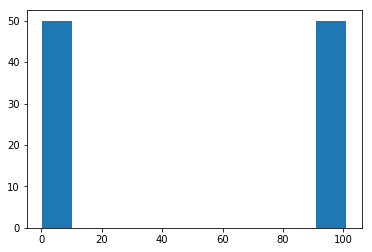

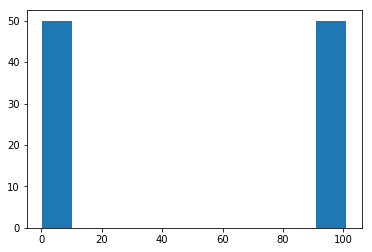

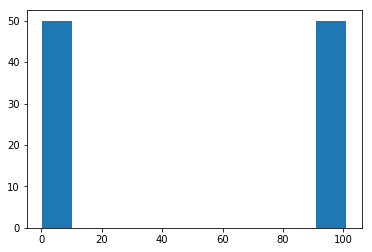

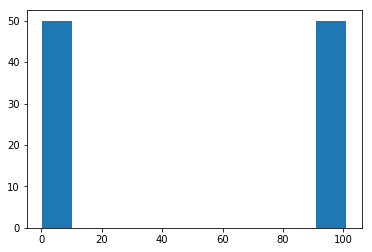

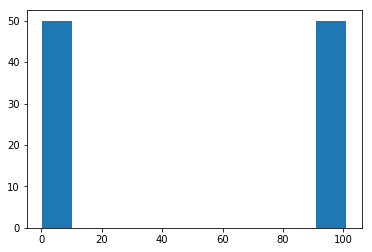

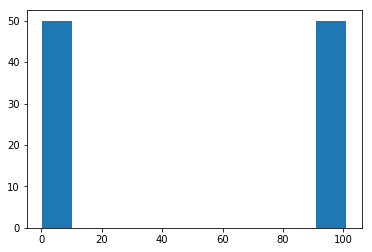

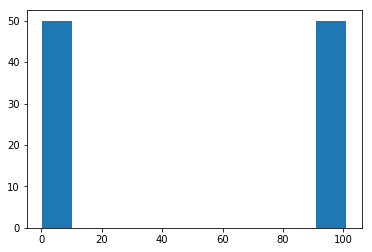

Iter: 400


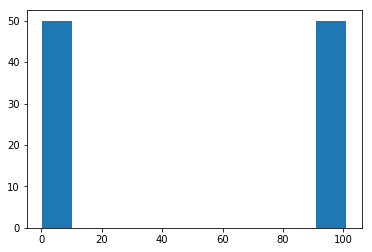

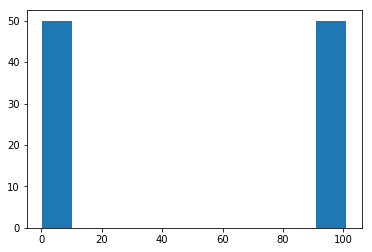

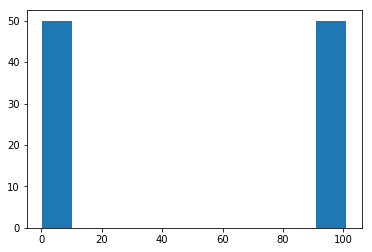

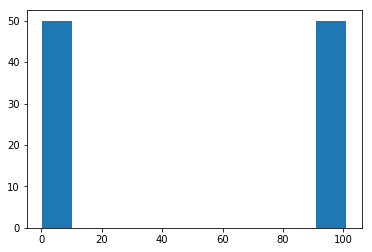

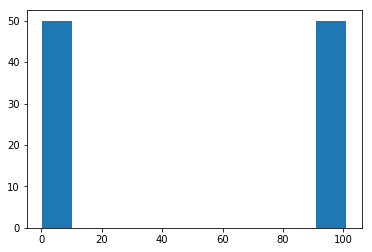

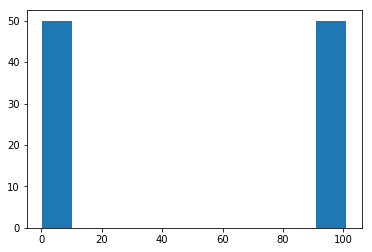

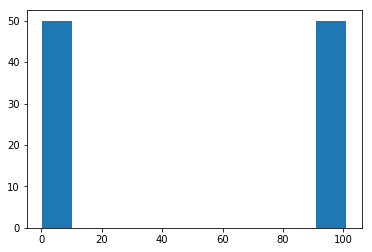

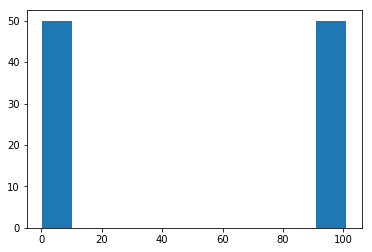

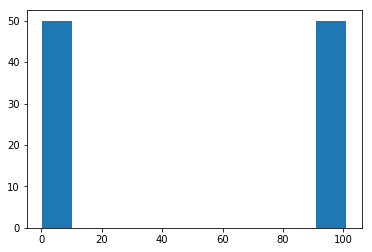

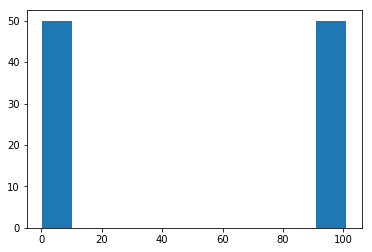

Iter: 500


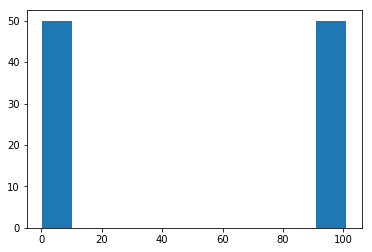

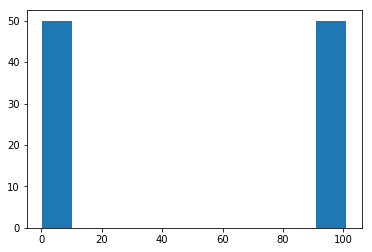

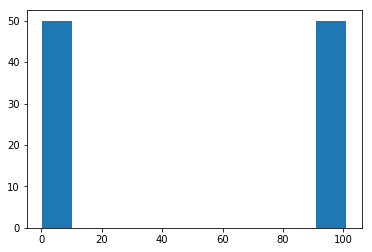

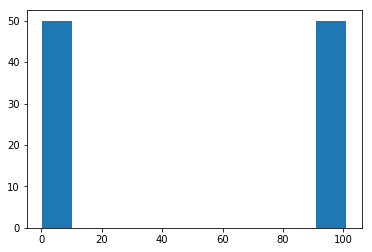

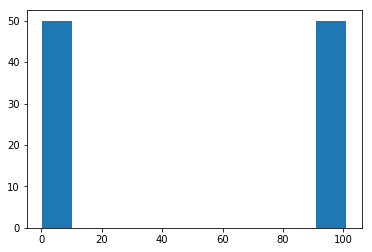

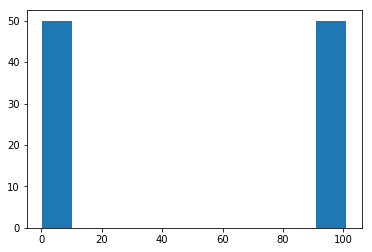

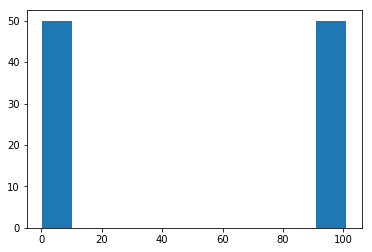

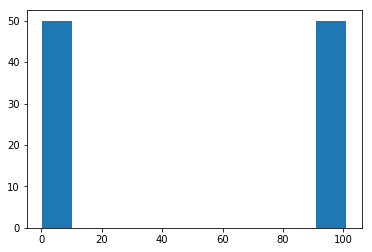

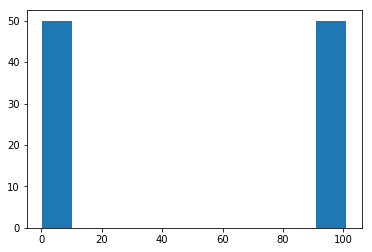

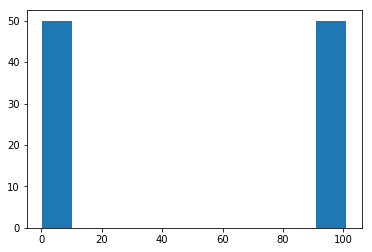

Iter: 600


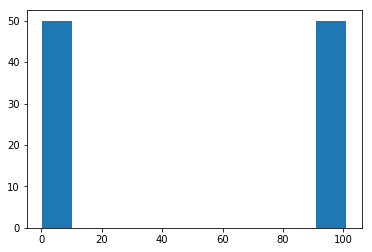

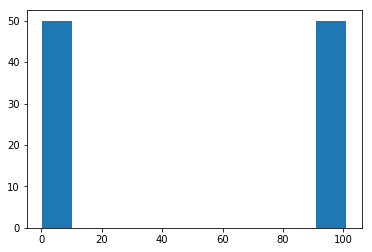

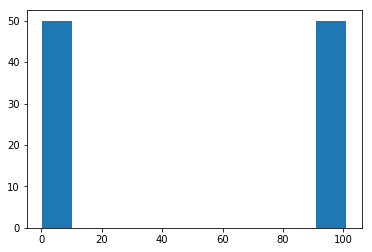

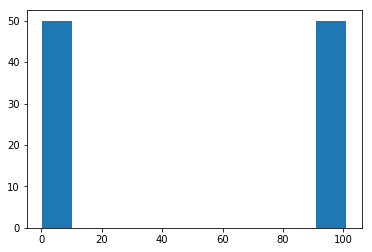

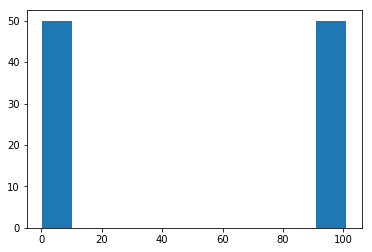

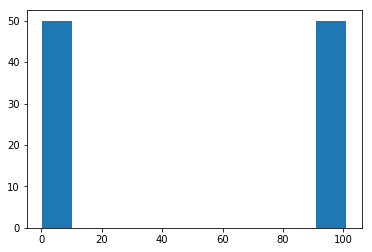

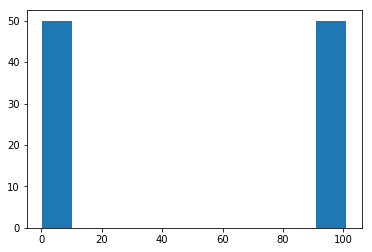

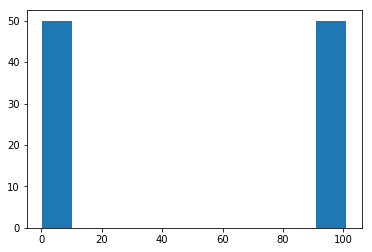

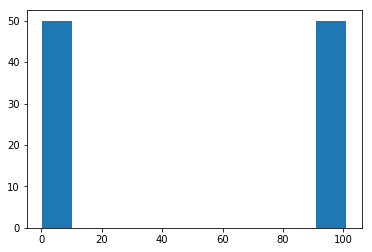

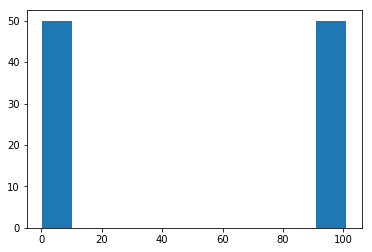

Iter: 700


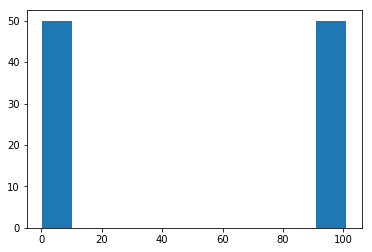

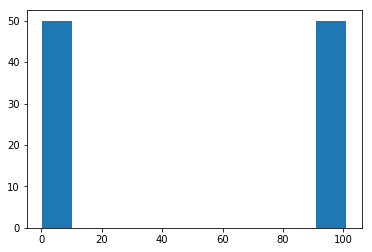

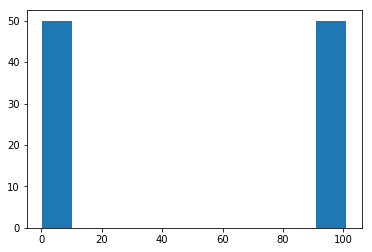

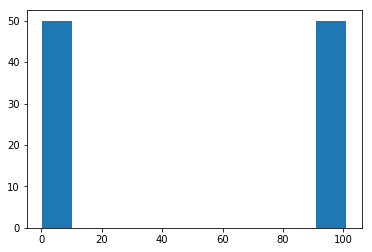

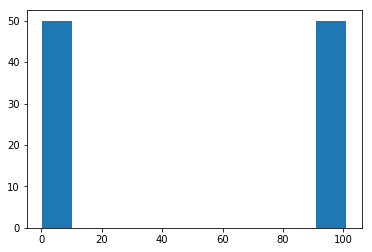

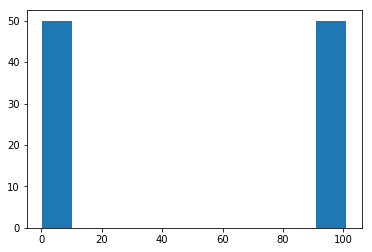

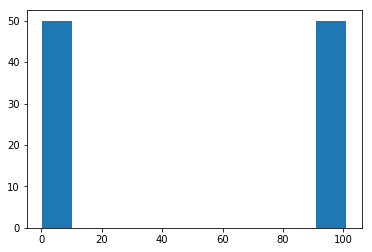

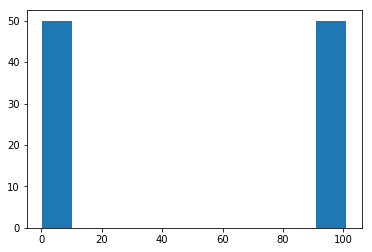

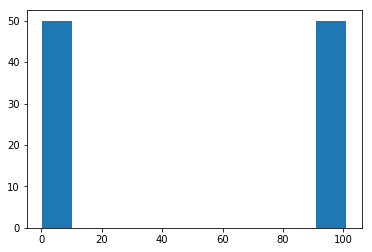

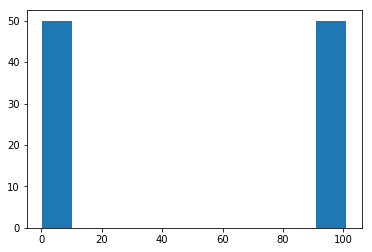

Iter: 800


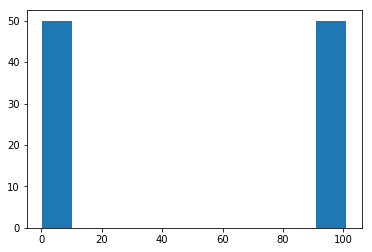

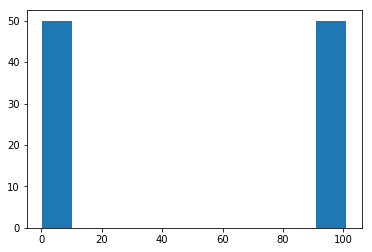

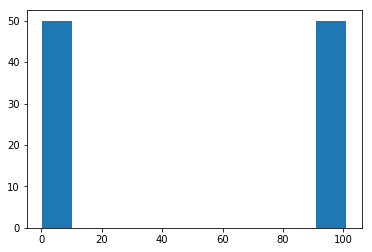

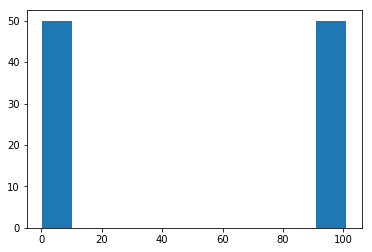

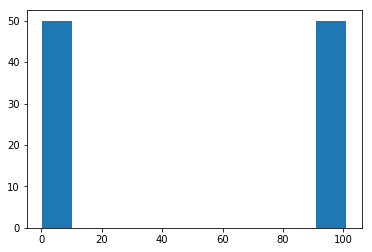

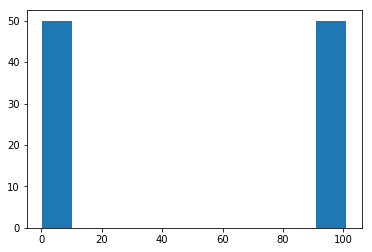

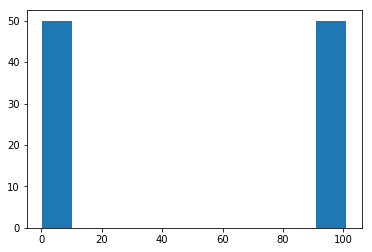

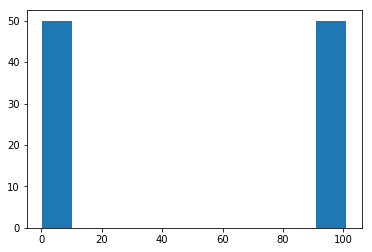

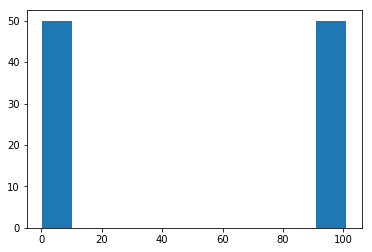

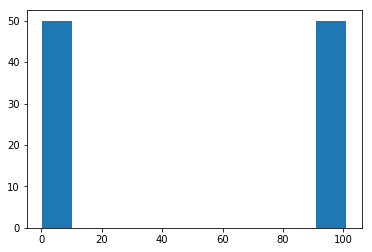

Iter: 900


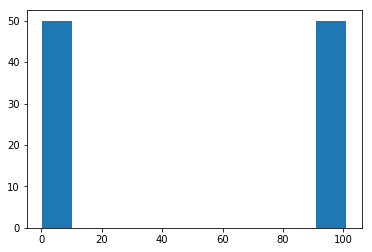

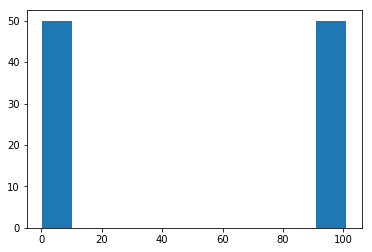

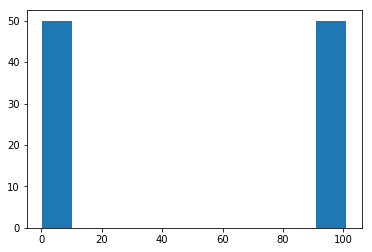

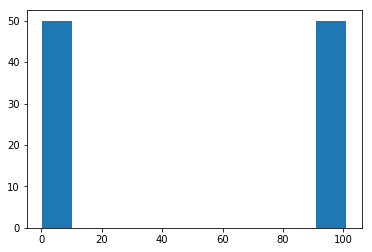

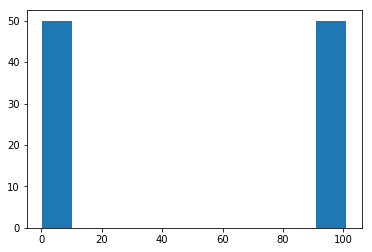

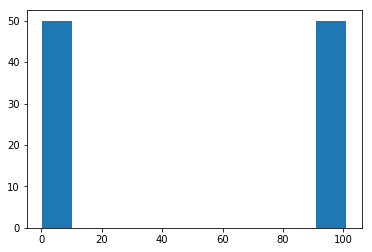

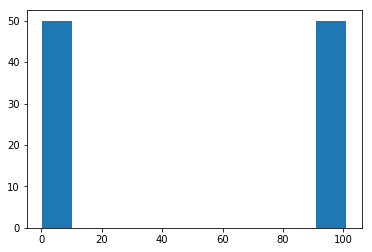

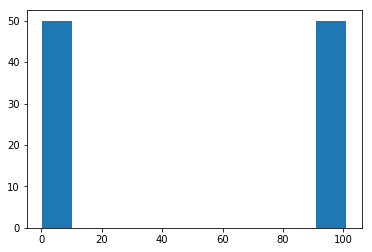

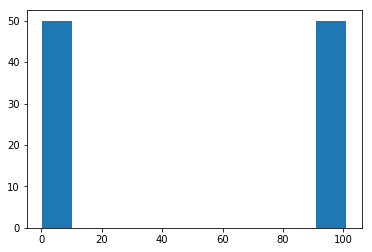

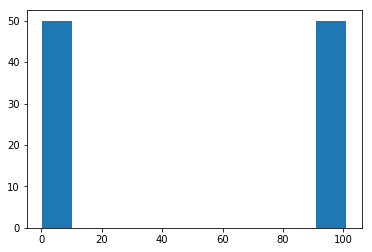

In [311]:
#######################
## Model Hyperparams ##
#######################
K = 50
sigma_A = 1.0
sigma_n = 0.2
#alpha = 0.7
alphas = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]


#############################
## Optimization parameters ##
#############################
rounds = 1000
#elbos = []
elbos = {alpha: [] for alpha in alphas}
lls = {alpha: [] for alpha in alphas}
phis = {}
nus = {}

for alpha in alphas:
    ibp_model = IBP(alpha, K, N, X, D, sigma_A, sigma_n)
    ibp_model.param_updates(rounds, debug=True)
    elbos[alpha] = ibp_model.elbos
    lls[alpha] = ibp_model.predictive_lls
    phis[alpha] = ibp_model.phi
    nus[alpha] = ibp_model.nu

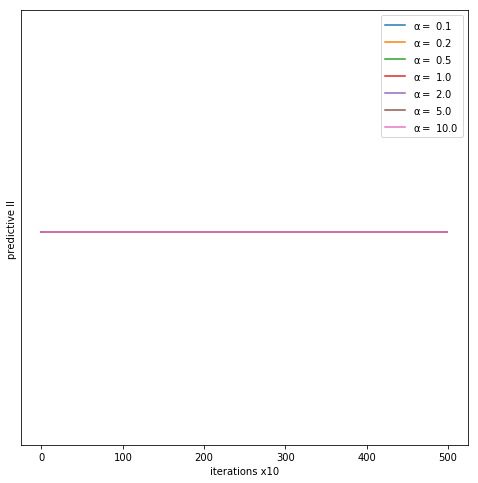

In [308]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for alpha in alphas:
    ax.plot(lls[alpha], label='$\\alpha = $ {}'.format(alpha))
ax.set_yscale('symlog')
plt.xlabel("iterations x10")
plt.ylabel("predictive ll ")
plt.legend()
plt.show()

In [309]:
lls

{0.1: [-30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30389.12037939083,
  -30